<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Accor/Accor_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "ACFREUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-26 16:31:04,737 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-26 16:31:04,738 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for ACFREUR
2019-08-26 16:34:27,252 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-26 16:41:12,095 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-26 16:44:47,176 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-26 16:48:14,533 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-26 16:51:50,116 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-26 16:55:21,467 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-26 16:59:00,664 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-26 17:02:29,545 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-26 17:13:17,603 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_439__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_ACFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-ACFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-ACFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.43217  0.43217  0.42827  0.43167  6.026800
2018-01-02 09:00:00  0.43158  0.43158  0.42908  0.42968  3.741200
2018-01-02 10:00:00  0.42968  0.43118  0.42927  0.43068  4.539700
2018-01-02 11:00:00  0.43068  0.43168  0.43048  0.43067  3.708700
2018-01-02 12:00:00  0.43078  0.43228  0.43077  0.43228  3.749100
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.36708  0.36737  0.36567  0.36638  1.299448
2018-12-31 09:00:00  0.36637  0.36738  0.36587  0.36678  1.158142
2018-12-31 10:00:00  0.36688  0.36818  0.36667  0.36807  0.833073
2018-12-31 11:00:00  0.36807  0.36928  0.36768  0.36927  0.694507
2018-12-31 12:00:00  0.36928  0.37037  0.36858  0.36940  1.440760

[2275 rows x 5 columns]

Open         High          Low        Close       Volume
count  2275.000000  2275.000000  2275.000000  2275.000000  2275.000000
mean      0.434773     0.435904     0.433707     0.434808     2.527511
std       0.027606     0.027578     0.027698     0.027644     1.199283
min       0.354470     0.356280     0.353070     0.354770     0.000190
25%       0.421825     0.422980     0.420625     0.421820     1.706770
50%       0.437680     0.438880     0.436670     0.437770     2.259646
75%       0.454845     0.455980     0.453570     0.454970     3.037897
max       0.488480     0.489380     0.487670     0.488470    13.472698

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.44957  0.45068  0.44937  0.45067  1.921497    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.449033  0.440768  0.444502  0.450796  0.448531  0.446962    0.446875    0.447175  0.444722  0.448225  0.450901  0.448861  0.449409  0.448225  0.450003  0.444104                0.454057                 0.448225                0.442393                0.456974                 0.448225                0.439476                0.459890                 0.448225                0.436560                0.462806                 0.448225                0.433644  0.448531  0.450075  0.444686                0.454363                 0.448531                0.442698                0.457279                 0.448531                0.439782                0.460196                 0.448531                0.436866                0.463112                 0.448531   
2018-01-09 14:00:00  0.45068  0.45069  0.44918  0.44938  4.386767    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.449050  0.440975  0.445200  0.450628  0.448719  0.447400    0.447025    0.447225  0.445263  0.449013  0.450432  0.449535  0.449666  0.449013  0.450025  0.444705                0.453368                 0.449013                0.444657                0.455545                 0.449013                0.442480                0.457723                 0.449013                0.440302                0.459901                 0.449013                0.438124  0.448719  0.449689  0.445299                0.453075                 0.448719                0.444364                0.455252                 0.448719                0.442187                0.457430                 0.448719                0.440009                0.459608                 0.448719   
2018-01-09 15:00:00  0.44938  0.45078  0.44937  0.45067 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000    2225.000000  2225.000000   2225.000000     2225.000000     2225.000000       2225.000000  2225.000000  2225.000000  2225.000000  2225.000000   2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000  2225.000000  2225.000000  2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000   
mean      0.434700     0.435831     0.433626     0.434730     2.522679    16.015281     2.020225   185.529888      30.424270    11.373034      0.034157        0.023820        0.002247          0.004045     6.600000     2.534831    26.955955     2.020225      2.004494    26.955955     0.434967     0.435376     0.007300     0.434729     0.434857     0.434441     0.434821     0.434799     0.434933     0.434857     0.434729     0.434857     0.434815     0.434857     0.434757     0.435115                0.438258                 0.434857                0.431457                0.439958                 0.434857                0.429757                0.441658                 0.434857                0.428057                0.443358                 0.434857                0.426357     0.434857     0.434756     0.435076                0.438258                 0.434857                0.431457                0.439958                 0.434857                0.429757                0.441658   
std       0.027898     0.027869     0.027990     0.027936     1.171116     8.585255     1.412637   101.934398       0.854392     2.621369      0.181674        0.152523        0.047362          0.063485     3.354236     1.103369    14.562870     1.412637      1.403995    14.562870     0.027592     0.026968     0.435762     0.027980     0.027696     0.027654     0.027753     0.027767     0.027720     0.027739     0.027958     0.027758     0.027793     0.027739     0.027904     0.027304                0.027693                 0.027739                0.027973                0.027741                 0.027739                0.028159                0.027836                 0.027739                0.028391                0.027978                 0.027739                0.028666     0.027696     0.027884     0.027372                0.027645                 0.027696                0.027937                0.027690                 0.027696                0.028126                0.027782   
min       0.354470     0.356280     0.3530

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.709648  0.709241  0.715453  0.717278  0.142609    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.710464  0.648230  0.959048  0.722511  0.708749  0.702721    0.693413    0.696457  0.672379  0.704675  0.723182  0.709004  0.714144  0.704675  0.714054  0.676884                0.714210                 0.704675                0.684275                0.670914                 0.704675                0.677776                0.629639                 0.704675                0.671817                0.594582                 0.704675                0.666150  0.708749  0.717456  0.680923                0.727088                 0.708749                0.691275                0.694083                 0.708749                0.684832                0.649362                 0.708749                0.678711                0.611602                 0.708749   
2018-01-09 14:00:00  0.717931  0.709316  0.714042  0.707629  0.325595    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.710597  0.649884  0.959764  0.721245  0.710196  0.706151    0.694560    0.696839  0.676345  0.710695  0.719674  0.714134  0.716099  0.710695  0.714216  0.681586                0.709088                 0.710695                0.701163                0.661165                 0.710695                0.699673                0.616054                 0.710695                0.698416                0.577739                 0.710695                0.697221  0.710196  0.714550  0.685706                0.717318                 0.710196                0.703711                0.679702                 0.710196                0.702322                0.631397                 0.710196                0.701002                0.590611                 0.710196   
2018-01-09 15:00:00  0.708231  0.709993  

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvu1b0kax
  JVM stdout: /tmp/tmpvu1b0kax/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpvu1b0kax/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_0yvzkl
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_172051_mod...  0.754288  0.654659              0.348584  0.468844  0.219814
1  DeepLearning_grid_1_AutoML_20190826_172051_mod...  0.748382  0.662101              0.304045  0.484601  0.234838
2  DeepLearning_grid_1_AutoML_20190826_172051_mod...  0.742476  0.627600              0.309587  0.467418  0.218480
3  DeepLearning_grid_1_AutoML_20190826_172051_mod...  0.736812  0.672654              0.342961  0.478428  0.228893
4  DeepLearning_grid_1_AutoML_20190826_172051_mod...  0.726942  0.632008              0.347856  0.470568  0.221434
5  DeepLearning_grid_1_AutoML_20190826_172051_mod...  0.716909  0.650990              0.336731  0.476234  0.226799
6  DeepLearning_grid_1_AutoML_20190826_172051_mod...  0.697654  0.651205              0.342961  0.471744  0.222543
7  DeepLearning_grid_1_AutoML_20190826_172051_mod...  0.696521  0.658785              0.385356  0.483664  0.233931
8  DeepLearning_grid_1_AutoML_20190826_172051_mod...  0.655218  4.930511              0.383981  0.657575  0.432405
9              DeepLearning_1_AutoML_20190826_172051  0.533252  0.703704              0.500000  0.505214  0.255242

variable  relative_importance  scaled_importance  percentage
0            CDL3WHITESOLDIERS             1.000000           1.000000    0.002343
1              CDLHOMINGPIGEON             0.994238           0.994238    0.002329
2          CDLRISEFALL3METHODS             0.944131           0.944131    0.002212
3          CDLCONCEALBABYSWALL             0.935414           0.935414    0.002191
4                    CDL2CROWS             0.924357           0.924357    0.002165
...                        ...                  ...                ...         ...
1034                    CMO_30             0.361682           0.361682    0.000847
1035  BBANDS_middleband_20_2_5             0.361607           0.361607    0.000847
1036   BBANDS_lowerband_24_5_2             0.360680           0.360680    0.000845
1037                   DEMA_24             0.360123           0.360123    0.000844
1038                    SMA_20             0.353381           0.353381    0.000828

[1039 rows x 4 columns]

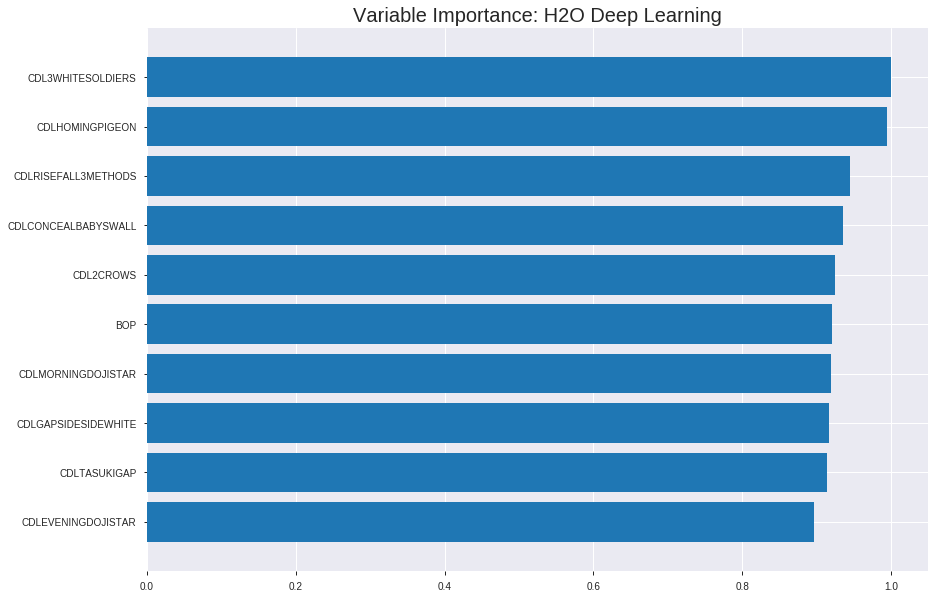

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_172051_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17281586830483836
RMSE: 0.41571127998268026
LogLoss: 0.5432919582503811
Mean Per-Class Error: 0.24467788017443226
AUC: 0.8318601765144267
pr_auc: 0.7965172050519402
Gini: 0.6637203530288533
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30203181029638854: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      474  315  0.3992   (315.0/789.0)
1      89   678  0.116    (89.0/767.0)
Total  563  993  0.2596   (404.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.302032     0.770455  262
max f2                       0.125012     0.861266  334
max f0point5                 0.732512     0.76748   119
max accuracy                 0.561231     0.755141  176
max precision                0.999647     1         0
max recall                   0.000978389  1         398
max specificity              0.999647     1         0
max absolute_mcc             0.434846     0.513668  217
max min_per_class_accuracy   0.533897     0.745247  184
max mean_per_class_accuracy  0.434846     0.755322  217

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 51.67 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.999023           2.02868    2.02868            1                0.999611   1                           0.999611            0.0208605       0.0208605                  102.868   102.868
    2        0.0205656                   0.997527           1.90189    1.96529            0.9375           0.998215   0.96875                     0.998913            0.0195567       0.0404172                  90.189    96.5287
    3        0.0302057                   0.995939           1.89344    1.94236            0.933333         0.996913   0.957447                    0.998274            0.0182529       0.0586701                  89.3438   94.2356
    4        0.0404884                   0.994373           1.7751     1.89988            0.875            0.994965   0.936508                    0.997434            0.0182529       0.0769231                  77.5098   89.9878
    5        0.0501285                   0.992667           2.02868    1.92465            1                0.993532   0.948718                    0.996684            0.0195567       0.0964798                  102.868   92.4648
    6        0.100257                    0.978234           1.74259    1.83362            0.858974         0.986225   0.903846                    0.991454            0.0873533       0.183833                   74.2587   83.3617
    7        0.150386                    0.948688           1.63855    1.7686             0.807692         0.964717   0.871795                    0.982542            0.0821382       0.265971                   63.8552   76.8596
    8        0.200514                    0.912514           1.84662    1.7881             0.910256         0.931392   0.88141                     0.969754            0.0925684       0.35854                    84.6622   78.8102
    9        0.300129                    0.818926           1.51824    1.69853            0.748387         0.871195   0.837259                    0.937042            0.151239        0.509778                   51.824    69.8533
    10       0.400386                    0.692596           1.36546    1.61513            0.673077         0.75875    0.796148                    0.892398            0.136897        0.646675                   36.546    61.5131
    11       0.5                         0.527194           1.02089    1.49674            0.503226         0.612602   0.737789                    0.836654            0.101695        0.74837                    2.08857   49.6741
    12       0.600257                    0.357422           1.00134    1.414              0.49359          0.444675   0.697002                    0.771184            0.100391        0.848761                   0.133721  41.3997
    13       0.699871                    0.226853           0.615149   1.30029            0.303226         0.288783   0.640955                    0.702523            0.0612777       0.910039                   -38.4851  30.0295
    14       0.800129                    0.116349           0.559188   1.20743            0.275641         0.167036   0.595181                    0.635426            0.0560626       0.966102                   -44.0812  20.7433
    15       0.899743                    0.0341038          0.248677   1.10129            0.122581         0.0703237  0.542857                    0.572861            0.0247718       0.990874                   -75.1323  10.1285
    16       1                           7.33072e-09        0.0910307  1                  0.0448718        0.0122864  0.492931 



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21281010446216314
RMSE: 0.46131345575667215
LogLoss: 0.6462633087686137
Mean Per-Class Error: 0.26724243914433243
AUC: 0.7678264076715023
pr_auc: 0.7150263176543392
Gini: 0.5356528153430047
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22413343437372896: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      158  91   0.3655   (91.0/249.0)
1      34   162  0.1735   (34.0/196.0)
Total  192  253  0.2809   (125.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.224133     0.721604  239
max f2                       0.0225213    0.817104  364
max f0point5                 0.270705     0.680212  221
max accuracy                 0.270705     0.725843  221
max precision                0.996191     1         0
max recall                   0.00834213   1         383
max specificity              0.996191     1         0
max absolute_mcc             0.267176     0.463055  223
max min_per_class_accuracy   0.321796     0.69898   200
max mean_per_class_accuracy  0.267176     0.732758  223

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 39.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.988282           2.27041   2.27041            1                0.994226    1                           0.994226            0.0255102       0.0255102                  127.041   127.041
    2        0.0202247                   0.973353           2.27041   2.27041            1                0.980359    1                           0.988063            0.0204082       0.0459184                  127.041   127.041
    3        0.0314607                   0.963926           2.27041   2.27041            1                0.967396    1                           0.980682            0.0255102       0.0714286                  127.041   127.041
    4        0.0404494                   0.951271           2.27041   2.27041            1                0.958218    1                           0.97569             0.0204082       0.0918367                  127.041   127.041
    5        0.0516854                   0.941509           1.81633   2.17169            0.8              0.945232    0.956522                    0.969069            0.0204082       0.112245                   81.6327   117.169
    6        0.101124                    0.900083           1.44481   1.81633            0.636364         0.919273    0.8                         0.944724            0.0714286       0.183673                   44.4805   81.6327
    7        0.150562                    0.844716           1.65121   1.76211            0.727273         0.87354     0.776119                    0.92135             0.0816327       0.265306                   65.1206   76.2108
    8        0.2                         0.790643           1.65121   1.73469            0.727273         0.819716    0.764045                    0.896227            0.0816327       0.346939                   65.1206   73.4694
    9        0.301124                    0.630182           1.4127    1.62656            0.622222         0.708407    0.716418                    0.833153            0.142857        0.489796                   41.2698   62.6561
    10       0.4                         0.45105            0.928803  1.45408            0.409091         0.539074    0.640449                    0.76046             0.0918367       0.581633                   -7.11967  45.4082
    11       0.501124                    0.285218           1.51361   1.46609            0.666667         0.366365    0.64574                     0.680934            0.153061        0.734694                   51.3605   46.6093
    12       0.6                         0.18881            1.032     1.39456            0.454545         0.239713    0.614232                    0.608223            0.102041        0.836735                   3.20037   39.4558
    13       0.698876                    0.102809           0.464402  1.26296            0.204545         0.14282     0.55627                     0.542378            0.0459184       0.882653                   -53.5598  26.296
    14       0.8                         0.0496053          0.454082  1.16071            0.2              0.0729186   0.511236                    0.483037            0.0459184       0.928571                   -54.5918  16.0714
    15       0.898876                    0.0197701          0.567602  1.09547            0.25             0.0352257   0.4825                      0.433777            0.0561224       0.984694                   -43.2398  9.54719
    16       1                           7.51025e-05        0.151361  1                  0.0666667        0.00895424  0.440449  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:26:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 17:26:39  7.716 sec         151 obs/sec       0.465938  1             725        0.62078          3.57536             -0.54178       0.599031        0.312753           1.7751           0.466581                         0.747455           13.5003               -1.26691         0.532385          0.079047             1.0898             0.516854
    2019-08-26 17:27:04  32.645 sec        162 obs/sec       2.86504   6             4458       0.537709         1.59669             -0.156755      0.720979        0.717002           1.64831          0.384961                         0.509574           0.90189               -0.0536065       0.715679          0.648255             1.81633            0.364045
    2019-08-26 17:27:30  58.990 sec        173 obs/sec       5.73715   12            8927       0.499701         0.923771            0.000994676    0.776207        0.770022           1.90189          0.352185                         0.579803           1.26077               -0.364037        0.618822          0.533098             1.81633            0.510112
    2019-08-26 17:27:55  1 min 23.947 sec  180 obs/sec       8.60219   18            13385      0.454723         0.716396            0.172744       0.797473        0.748021           2.02868          0.280206                         0.517464           0.93812               -0.0864877       0.679842          0.597872             1.36224            0.395506
    2019-08-26 17:28:20  1 min 48.179 sec  186 obs/sec       11.5161   24            17919      0.513537         1.01914             -0.0550903     0.720841        0.63455            1.7751           0.355398                         0.571585           1.2514                -0.325641        0.649445          0.636809             2.27041            0.483146
    2019-08-26 17:28:46  2 min 14.687 sec  192 obs/sec       14.838    31            23088      0.506029         0.907409            -0.0244653     0.750808        0.681287           1.90189          0.358612                         0.59028            1.84819               -0.413775        0.694052          0.664586             2.27041            0.406742
    2019-08-26 17:29:12  2 min 40.355 sec  197 obs/sec       18.1973   38            28315      0.415711         0.543292            0.308598       0.83186         0.796517           2.02868          0.25964                          0.461313           0.646263              0.136511         0.767826          0.715026             2.27041            0.280899

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDL3WHITESOLDIERS         1.0                    1.0                  0.0023426202769776666
CDLHOMINGPIGEON           0.9942381381988525     0.9942381381988525   0.0023291224226891553
CDLRISEFALL3METHODS       0.944131076335907      0.944131076335907    0.0022117406035492447
CDLCONCEALBABYSWALL       0.9354138970375061     0.9354138970375061   0.002191319562566761
CDL2CROWS                 0.9243566393852234     0.9243566393852234   0.002165416606582757
---                       ---                    ---                  ---
CMO_30                    0.36168166995048523    0.36168166995048523  0.0008472828138371506
BBANDS_middleband_20_2_5  0.36160746216773987    0.36160746216773987  0.0008471089731805819
BBANDS_lowerband_24_5_2   0.3606800138950348     0.3606800138950348   0.000844936314051095
DEMA_24                   0.36012282967567444    0.36012282967567444  0.0008436310430008095
SMA_20                    0.3533809781074524     0.3533809781074524   0.0008278374448127189


See the whole table with table.as_data_frame()


('accuracy', 0.6905829596412556)

('F1', 0.704626334519573)

('auc', 0.7542880258899677)

('logloss', 0.6546588199496618)

('mean_per_class_error', 0.3164239482200647)

('rmse', 0.4688436966275601)

('mse', 0.2198144118673956)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


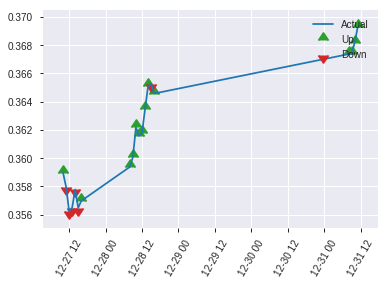


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2198144118673956
RMSE: 0.4688436966275601
LogLoss: 0.6546588199496618
Mean Per-Class Error: 0.3164239482200647
AUC: 0.7542880258899677
pr_auc: 0.7200138646008525
Gini: 0.5085760517799354
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07195229835677946: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      41   79   0.6583   (79.0/120.0)
1      4    99   0.0388   (4.0/103.0)
Total  45   178  0.3722   (83.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0719523    0.704626  177
max f2                       0.0634012    0.84317   180
max f0point5                 0.658873     0.676692  73
max accuracy                 0.658873     0.690583  73
max precision                0.994503     1         0
max recall                   0.019409     1         204
max specificity              0.994503     1         0
max absolute_mcc             0.658873     0.37862   73
max min_per_class_accuracy   0.430468     0.675     108
max mean_per_class_accuracy  0.478768     0.683576  100

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 44.33 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.988448           2.16505    2.16505            1                0.991195   1                           0.991195            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.984817           2.16505    2.16505            1                0.98635    1                           0.989257            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.982473           2.16505    2.16505            1                0.983295   1                           0.987553            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.973184           2.16505    2.16505            1                0.981887   1                           0.986294            0.0194175       0.0873786                  116.505   116.505
    5        0.0538117                   0.966048           1.44337    1.98463            0.666667         0.969965   0.916667                    0.982212            0.0194175       0.106796                   44.3366   98.4628
    6        0.103139                    0.943335           1.7714     1.88265            0.818182         0.953875   0.869565                    0.968659            0.0873786       0.194175                   77.1403   88.2651
    7        0.152466                    0.878256           1.7714     1.84666            0.818182         0.909268   0.852941                    0.949444            0.0873786       0.281553                   77.1403   84.6659
    8        0.201794                    0.807697           1.57458    1.78015            0.727273         0.837098   0.822222                    0.921982            0.0776699       0.359223                   57.4581   78.0151
    9        0.300448                    0.70307            1.18094    1.58339            0.545455         0.766905   0.731343                    0.871061            0.116505        0.475728                   18.0936   58.3394
    10       0.399103                    0.559157           0.885702   1.41093            0.409091         0.628067   0.651685                    0.810995            0.0873786       0.563107                   -11.4298  41.0931
    11       0.502242                    0.402106           1.12959    1.35316            0.521739         0.484339   0.625                       0.743914            0.116505        0.679612                   12.9591   35.3155
    12       0.600897                    0.280671           1.18094    1.32488            0.545455         0.347183   0.61194                     0.678779            0.116505        0.796117                   18.0936   32.488
    13       0.699552                    0.133424           0.78729    1.24907            0.363636         0.200417   0.576923                    0.611318            0.0776699       0.873786                   -21.271   24.9066
    14       0.798206                    0.0703289          0.885702   1.20416            0.409091         0.104228   0.55618                     0.548644            0.0873786       0.961165                   -11.4298  20.4156
    15       0.896861                    0.0280369          0.295234   1.10417            0.136364         0.0419399  0.51                        0.492906            0.0291262       0.990291                   -70.4766  10.4175
    16       1                           3.98142e-05        0.0941325  1                  0.0434783        0.011558   0.461883  

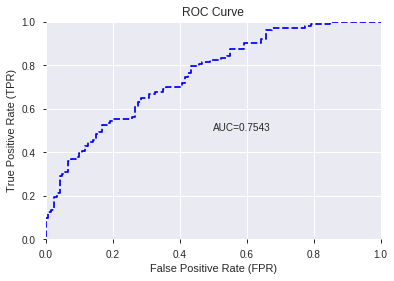

This function is available for GLM models only


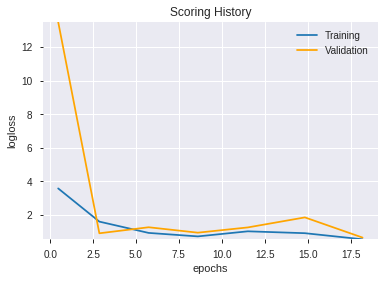

--2019-08-26 17:52:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  51.7MB/s    in 6.5s    

2019-08-26 17:52:12 (54.1 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_172051_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_172051_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_175221_model_5  0.752023  0.601598              0.339563  0.455789  0.207744
1  DeepLearning_grid_1_AutoML_20190826_175221_model_8  0.750000  0.592440              0.349272  0.451317  0.203687
2  DeepLearning_grid_1_AutoML_20190826_175221_model_2  0.747411  0.746609              0.329814  0.470475  0.221347
3  DeepLearning_grid_1_AutoML_20190826_175221_model_3  0.743689  0.724652              0.378439  0.462293  0.213715
4  DeepLearning_grid_1_AutoML_20190826_175221_model_6  0.738430  0.613503              0.370105  0.456460  0.208356
5  DeepLearning_grid_1_AutoML_20190826_175221_model_9  0.732929  0.607923              0.368002  0.457893  0.209666
6  DeepLearning_grid_1_AutoML_20190826_175221_model_7  0.727508  0.656243              0.338066  0.465075  0.216295
7  DeepLearning_grid_1_AutoML_20190826_175221_model_1  0.719337  0.814661              0.355502  0.490070  0.240169
8  DeepLearning_grid_1_AutoML_20190826_175221_model_4  0.706392  0.715216              0.354814  0.484623  0.234859
9               DeepLearning_1_AutoML_20190826_175221  0.702184  0.652540              0.347816  0.475378  0.225984

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.040672
1    CDLCLOSINGMARUBOZU             0.820950           0.820950    0.033390
2           CDLLONGLINE             0.705076           0.705076    0.028677
3                TRANGE             0.704266           0.704266    0.028644
4          CDLSHORTLINE             0.693085           0.693085    0.028189
5        STOCHRSI_fastk             0.656030           0.656030    0.026682
6                   SUB             0.653687           0.653687    0.026587
7          STOCHF_fastk             0.642768           0.642768    0.026143
8                ULTOSC             0.634366           0.634366    0.025801
9                   DIV             0.633204           0.633204    0.025754
10            CORREL_30             0.625264           0.625264    0.025431
11                ADOSC             0.578056           0.578056    0.023511
12              CDLDOJI             0.569221           0.569221    0.023151
13   CDLIDENTICAL3CROWS             0.566168           0.566168    0.023027
14               Volume             0.525629           0.525629    0.021378
15             CORREL_8             0.507054           0.507054    0.020623
16        CDLHANGINGMAN             0.478308           0.478308    0.019454
17            CDLHAMMER             0.473618           0.473618    0.019263
18            CDLTAKURI             0.471887           0.471887    0.019193
19         is_month_end             0.471574           0.471574    0.019180
20      CDLLADDERBOTTOM             0.456497           0.456497    0.018567
21            CDLONNECK             0.454799           0.454799    0.018498
22     CDLDRAGONFLYDOJI             0.454776           0.454776    0.018497
23  CDLXSIDEGAP3METHODS             0.453731           0.453731    0.018454
24  CDLRISEFALL3METHODS             0.450997           0.450997    0.018343
25       is_month_start             0.442390           0.442390    0.017993
26         CDLTASUKIGAP             0.430256           0.430256    0.017499
27  CDLCONCEALBABYSWALL             0.426106           0.426106    0.017331
28      CDLHOMINGPIGEON             0.423099           0.423099    0.017208
29    CDLDARKCLOUDCOVER             0.422625           0.422625    0.017189
30          CDLPIERCING             0.422395           0.422395    0.017180
31    CDLSTALLEDPATTERN             0.422182           0.422182    0.017171
32       CDL3LINESTRIKE             0.419893           0.419893    0.017078
33   CDLMORNINGDOJISTAR             0.416110           0.416110    0.016924
34   CDLSEPARATINGLINES             0.414379           0.414379    0.016854
35    CDL3WHITESOLDIERS             0.409149           0.409149    0.016641
36            CDL2CROWS             0.404789           0.404789    0.016464
37  CDLGAPSIDESIDEWHITE             0.400206           0.400206    0.016277
38          CDLMARUBOZU             0.398905           0.398905    0.016224
39   CDLEVENINGDOJISTAR             0.393678           0.393678    0.016012
40      CDLADVANCEBLOCK             0.389374           0.389374    0.015837
41       CDLEVENINGSTAR             0.388490           0.388490    0.015801
42    CDLINVERTEDHAMMER             0.386303           0.386303    0.015712
43    CDLGRAVESTONEDOJI             0.383659           0.383659    0.015604
44        CDLHIKKAKEMOD             0.380478           0.380478    0.015475
45       CDLMATCHINGLOW             0.379497           0.379497    0.015435
46       CDLMORNINGSTAR             0.363688           0.363688    0.014792
47         CDLTHRUSTING             0.346593           0.346593    0.014097
48      CDLSHOOTINGSTAR             0.328821           0.328821    0.013374
49           CDL3INSIDE             0.312804           0.312804    0.012722

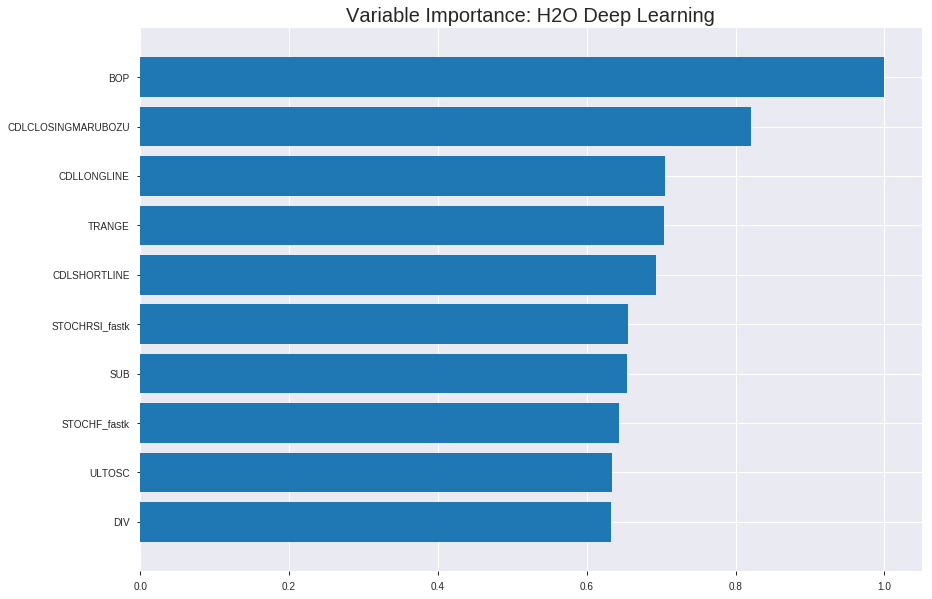

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_175221_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17720273812378298
RMSE: 0.42095455588909236
LogLoss: 0.5250222493732969
Mean Per-Class Error: 0.268602839235049
AUC: 0.8106014412645849
pr_auc: 0.8083216370364997
Gini: 0.6212028825291698
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3803613603909729: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      440  349   0.4423   (349.0/789.0)
1      106  661   0.1382   (106.0/767.0)
Total  546  1010  0.2924   (455.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380361     0.74395   250
max f2                       0.0913667    0.849688  362
max f0point5                 0.545929     0.740078  170
max accuracy                 0.512228     0.732005  184
max precision                0.997395     1         0
max recall                   0.0474842    1         382
max specificity              0.997395     1         0
max absolute_mcc             0.512228     0.465157  184
max min_per_class_accuracy   0.477903     0.722295  200
max mean_per_class_accuracy  0.506398     0.731397  187

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 49.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.969015           2.02868   2.02868            1                0.979783   1                           0.979783            0.0208605       0.0208605                  102.868   102.868
    2        0.0205656                   0.956672           1.90189   1.96529            0.9375           0.961188   0.96875                     0.970486            0.0195567       0.0404172                  90.189    96.5287
    3        0.0302057                   0.952984           1.89344   1.94236            0.933333         0.954398   0.957447                    0.965351            0.0182529       0.0586701                  89.3438   94.2356
    4        0.0404884                   0.948265           2.02868   1.96428            1                0.950413   0.968254                    0.961557            0.0208605       0.0795306                  102.868   96.4281
    5        0.0501285                   0.940392           1.89344   1.95066            0.933333         0.944617   0.961538                    0.9583              0.0182529       0.0977836                  89.3438   95.0657
    6        0.100257                    0.892923           1.87263   1.91164            0.923077         0.917234   0.942308                    0.937767            0.0938722       0.191656                   87.2631   91.1644
    7        0.150386                    0.847006           1.7686    1.86396            0.871795         0.8699     0.918803                    0.915144            0.0886571       0.280313                   76.8596   86.3961
    8        0.200514                    0.780449           1.66456   1.81411            0.820513         0.816134   0.894231                    0.890392            0.083442        0.363755                   66.4561   81.4111
    9        0.300129                    0.655931           1.42662   1.6855             0.703226         0.723046   0.830835                    0.834849            0.142112        0.505867                   42.6622   68.5501
    10       0.400386                    0.555795           1.17039   1.55652            0.576923         0.603724   0.767255                    0.776975            0.11734         0.623207                   17.0394   55.6518
    11       0.5                         0.475086           1.02089   1.4498             0.503226         0.512613   0.714653                    0.724306            0.101695        0.724902                   2.08857   44.9804
    12       0.600257                    0.413142           0.871293  1.35318            0.429487         0.445179   0.667024                    0.677685            0.0873533       0.812256                   -12.8707  35.3179
    13       0.699871                    0.333905           0.811473  1.27608            0.4              0.375766   0.629017                    0.634713            0.0808344       0.89309                    -18.8527  27.6077
    14       0.800129                    0.217561           0.585197  1.18951            0.288462         0.278688   0.586345                    0.590102            0.0586701       0.95176                    -41.4803  18.9509
    15       0.899743                    0.0986385          0.353384  1.09694            0.174194         0.153637   0.540714                    0.541779            0.0352021       0.986962                   -64.6616  9.6938
    16       1                           0.000245404        0.130044  1                  0.0641026        0.0524825  0.492931                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19152202873850888
RMSE: 0.4376322985549728
LogLoss: 0.5582607107918289
Mean Per-Class Error: 0.28759937710023764
AUC: 0.7785427423981641
pr_auc: 0.7301489327292211
Gini: 0.5570854847963282
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4042974747164175: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  100  0.4016   (100.0/249.0)
1      39   157  0.199    (39.0/196.0)
Total  188  257  0.3124   (139.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404297     0.693157  229
max f2                       0.16551      0.831169  333
max f0point5                 0.481101     0.674603  180
max accuracy                 0.481101     0.714607  180
max precision                0.969035     1         0
max recall                   0.077086     1         362
max specificity              0.969035     1         0
max absolute_mcc             0.481101     0.423407  180
max min_per_class_accuracy   0.472026     0.709184  187
max mean_per_class_accuracy  0.481101     0.712401  180

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 46.44 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.953225           2.27041    2.27041            1                0.96447    1                           0.96447             0.0255102       0.0255102                  127.041   127.041
    2        0.0202247                   0.939358           2.27041    2.27041            1                0.94508    1                           0.955852            0.0204082       0.0459184                  127.041   127.041
    3        0.0314607                   0.930084           2.27041    2.27041            1                0.932434   1                           0.947489            0.0255102       0.0714286                  127.041   127.041
    4        0.0404494                   0.92634            2.27041    2.27041            1                0.928023   1                           0.943163            0.0204082       0.0918367                  127.041   127.041
    5        0.0516854                   0.9225             1.36224    2.07298            0.6              0.923681   0.913043                    0.938928            0.0153061       0.107143                   36.2245   107.298
    6        0.101124                    0.875983           1.75441    1.91723            0.772727         0.897764   0.844444                    0.918803            0.0867347       0.193878                   75.4406   91.7234
    7        0.150562                    0.814165           1.65121    1.82988            0.727273         0.844255   0.80597                     0.894325            0.0816327       0.27551                    65.1206   82.9881
    8        0.2                         0.74721            1.96081    1.86224            0.863636         0.78298    0.820225                    0.866802            0.0969388       0.372449                   96.0807   86.2245
    9        0.301124                    0.620268           1.16043    1.62656            0.511111         0.676923   0.716418                    0.803037            0.117347        0.489796                   16.0431   62.6561
    10       0.4                         0.511114           1.1868     1.51786            0.522727         0.561115   0.668539                    0.743236            0.117347        0.607143                   18.6804   51.7857
    11       0.501124                    0.452868           1.10998    1.43555            0.488889         0.481052   0.632287                    0.690329            0.112245        0.719388                   10.9977   43.555
    12       0.6                         0.383687           0.928803   1.35204            0.409091         0.419524   0.595506                    0.645702            0.0918367       0.811224                   -7.11967  35.2041
    13       0.698876                    0.296975           0.722403   1.26296            0.318182         0.341217   0.55627                     0.602624            0.0714286       0.882653                   -27.7597  26.296
    14       0.8                         0.192392           0.756803   1.19898            0.333333         0.244443   0.52809                     0.557348            0.0765306       0.959184                   -24.3197  19.898
    15       0.898876                    0.0776615          0.361201   1.10682            0.159091         0.143647   0.4875                      0.511841            0.0357143       0.994898                   -63.8799  10.6824
    16       1                           0.000641425        0.0504535  1                  0.0222222        0.0424116  0.440449    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:56:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 17:56:13  1 min 26.914 sec  1287 obs/sec      1.71465   1             2668       0.446746         0.584798            0.201511       0.775551        0.766523           1.7751           0.323907                         0.440814           0.564701              0.211548         0.776934          0.724008             2.27041            0.330337
    2019-08-26 17:56:19  1 min 32.967 sec  2114 obs/sec      10.2879   6             16008      0.432496         0.554251            0.251638       0.795328        0.78408            1.90189          0.312982                         0.442682           0.580652              0.20485          0.777129          0.707527             1.36224            0.355056
    2019-08-26 17:56:25  1 min 39.285 sec  2405 obs/sec      20.6247   12            32092      0.420955         0.525022            0.291047       0.810601        0.808322           2.02868          0.292416                         0.437632           0.558261              0.222888         0.778543          0.730149             2.27041            0.31236
    2019-08-26 17:56:31  1 min 45.499 sec  2537 obs/sec      30.973    18            48194      0.414454         0.511726            0.312773       0.825115        0.819341           2.02868          0.284704                         0.44254            0.582795              0.205362         0.776299          0.73284              2.27041            0.332584
    2019-08-26 17:56:38  1 min 51.545 sec  2625 obs/sec      41.3374   24            64321      0.411492         0.503167            0.322563       0.828431        0.824036           2.02868          0.282776                         0.451145           0.621519              0.174157         0.75877           0.70617              2.27041            0.323596
    2019-08-26 17:56:43  1 min 57.383 sec  2701 obs/sec      51.671    30            80400      0.403055         0.484157            0.350058       0.841425        0.84049            2.02868          0.255141                         0.444636           0.603009              0.197816         0.768083          0.728162             2.27041            0.348315
    2019-08-26 17:56:44  1 min 57.984 sec  2699 obs/sec      51.671    30            80400      0.420955         0.525022            0.291047       0.810601        0.808322           2.02868          0.292416                         0.437632           0.558261              0.222888         0.778543          0.730149             2.27041            0.31236

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04067209567951323
CDLCLOSINGMARUBOZU  0.8209496736526489     0.8209496736526489   0.0333897436748657
CDLLONGLINE         0.705076277256012      0.705076277256012    0.028676929809911517
TRANGE              0.7042657136917114     0.7042657136917114   0.028643962491069958
CDLSHORTLINE        0.6930850744247437     0.6930850744247437   0.028189222461045722
---                 ---                    ---                  ---
CDLMATCHINGLOW      0.379496693611145      0.379496693611145    0.015434925832611407
CDLMORNINGSTAR      0.3636881411075592     0.3636881411075592   0.014791958872630956
CDLTHRUSTING        0.346592515707016      0.346592515707016    0.014096643960638946
CDLSHOOTINGSTAR     0.32882094383239746    0.32882094383239746  0.013373836888979114
CDL3INSIDE          0.31280428171157837    0.31280428171157837  0.012722405674734726


See the whole table with table.as_data_frame()


('accuracy', 0.7040358744394619)

('F1', 0.7117437722419928)

('auc', 0.7520226537216829)

('logloss', 0.601597632342838)

('mean_per_class_error', 0.2990695792880258)

('rmse', 0.45578912641276076)

('mse', 0.2077437277561076)

deeplearning prediction progress: |███████████████████████████████████████| 100%


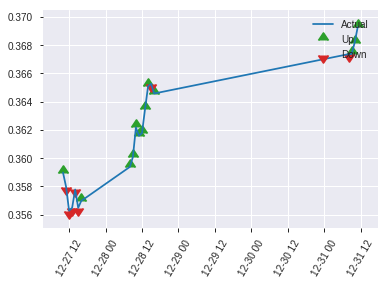


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2077437277561076
RMSE: 0.45578912641276076
LogLoss: 0.601597632342838
Mean Per-Class Error: 0.2990695792880258
AUC: 0.7520226537216829
pr_auc: 0.7060405879276651
Gini: 0.5040453074433657
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16505172027455559: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   78   0.65     (78.0/120.0)
1      3    100  0.0291   (3.0/103.0)
Total  45   178  0.3632   (81.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.165052     0.711744  177
max f2                       0.165052     0.847458  177
max f0point5                 0.709665     0.68254   52
max accuracy                 0.459695     0.704036  98
max precision                0.992279     1         0
max recall                   0.0552109    1         206
max specificity              0.992279     1         0
max absolute_mcc             0.459695     0.403233  98
max min_per_class_accuracy   0.434898     0.679612  106
max mean_per_class_accuracy  0.459695     0.70093   98

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 44.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.965593           2.16505    2.16505            1                0.976987   1                           0.976987            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.9564             1.08252    1.73204            0.5              0.961332   0.8                         0.970725            0.00970874      0.038835                   8.25243   73.2039
    3        0.0313901                   0.950563           2.16505    1.85576            1                0.953414   0.857143                    0.965779            0.0194175       0.0582524                  116.505   85.5756
    4        0.0403587                   0.937961           1.08252    1.68393            0.5              0.948197   0.777778                    0.961872            0.00970874      0.0679612                  8.25243   68.3927
    5        0.0538117                   0.926825           2.16505    1.80421            1                0.930153   0.833333                    0.953942            0.0291262       0.0970874                  116.505   80.4207
    6        0.103139                    0.842958           1.7714     1.78852            0.818182         0.893443   0.826087                    0.925008            0.0873786       0.184466                   77.1403   78.8518
    7        0.152466                    0.794818           1.96823    1.84666            0.909091         0.814963   0.852941                    0.889405            0.0970874       0.281553                   96.8226   84.6659
    8        0.201794                    0.754394           1.18094    1.68393            0.545455         0.773234   0.777778                    0.861008            0.0582524       0.339806                   18.0936   68.3927
    9        0.300448                    0.619459           1.27935    1.55108            0.590909         0.680297   0.716418                    0.80167             0.126214        0.466019                   27.9347   55.108
    10       0.399103                    0.47909            1.27935    1.48391            0.590909         0.529719   0.685393                    0.734446            0.126214        0.592233                   27.9347   48.391
    11       0.502242                    0.42759            0.941325   1.37249            0.434783         0.451936   0.633929                    0.67643             0.0970874       0.68932                    -5.86745  37.2486
    12       0.600897                    0.346298           0.688879   1.26025            0.318182         0.394383   0.58209                     0.630124            0.0679612       0.757282                   -31.1121  26.0252
    13       0.699552                    0.255935           1.18094    1.24907            0.545455         0.29206    0.576923                    0.582448            0.116505        0.873786                   18.0936   24.9066
    14       0.798206                    0.163557           0.984113   1.21632            0.454545         0.204781   0.561798                    0.53577             0.0970874       0.970874                   -1.5887   21.6319
    15       0.896861                    0.0780258          0.196823   1.10417            0.0909091        0.120935   0.51                        0.490138            0.0194175       0.990291                   -80.3177  10.4175
    16       1                           0.00898946         0.0941325  1                  0.0434783        0.0433145  0.461883   

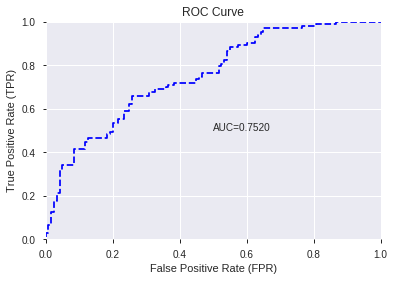

This function is available for GLM models only


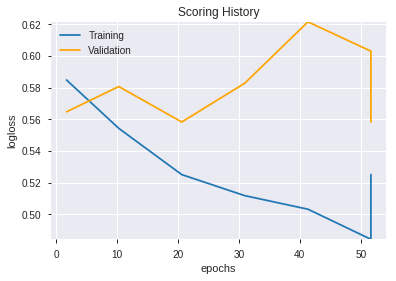

--2019-08-26 18:00:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.0.152
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.0.152|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_175221_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_175221_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'TRANGE',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'SUB',
 'STOCHF_fastk',
 'ULTOSC',
 'DIV',
 'CORREL_30',
 'ADOSC',
 'CDLDOJI',
 'CDLIDENTICAL3CROWS',
 'Volume',
 'CORREL_8',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'CDLTAKURI',
 'is_month_end',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'CDLDRAGONFLYDOJI',
 'CDLXSIDEGAP3METHODS',
 'CDLRISEFALL3METHODS',
 'is_month_start',
 'CDLTASUKIGAP',
 'CDLCONCEALBABYSWALL',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLPIERCING',
 'CDLSTALLEDPATTERN',
 'CDL3LINESTRIKE',
 'CDLMORNINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CDL3WHITESOLDIERS',
 'CDL2CROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDLMARUBOZU',
 'CDLEVENINGDOJISTAR',
 'CDLADVANCEBLOCK',
 'CDLEVENINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLHIKKAKEMOD',
 'CDLMATCHINGLOW',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING',
 'CDLSHOOTINGSTAR',
 'CDL3INSIDE']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_180052_model_1  0.727104  0.604208              0.379126  0.457823  0.209602

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.633125           1.000000    0.144266
1    CDLCLOSINGMARUBOZU             0.316761           0.500314    0.072179
2                TRANGE             0.225496           0.356164    0.051382
3    CDLIDENTICAL3CROWS             0.170223           0.268863    0.038788
4           CDLLONGLINE             0.169451           0.267642    0.038612
5                   SUB             0.164280           0.259474    0.037433
6             CDLTAKURI             0.156954           0.247903    0.035764
7        CDL3LINESTRIKE             0.133964           0.211592    0.030526
8          CDLSHORTLINE             0.117954           0.186304    0.026877
9   CDLXSIDEGAP3METHODS             0.116946           0.184712    0.026648
10          CDLMARUBOZU             0.112622           0.177882    0.025662
11            CDLHAMMER             0.106774           0.168647    0.024330
12  CDLRISEFALL3METHODS             0.096338           0.152163    0.021952
13  CDLCONCEALBABYSWALL             0.095843           0.151381    0.021839
14   CDLEVENINGDOJISTAR             0.093454           0.147608    0.021295
15   CDLSEPARATINGLINES             0.092784           0.146550    0.021142
16      CDLHOMINGPIGEON             0.091285           0.144181    0.020800
17    CDLINVERTEDHAMMER             0.086944           0.137325    0.019811
18        CDLHANGINGMAN             0.086644           0.136852    0.019743
19       CDLMORNINGSTAR             0.085124           0.134451    0.019397
20        CDLHIKKAKEMOD             0.082644           0.130534    0.018832
21            CDL2CROWS             0.081886           0.129336    0.018659
22           CDL3INSIDE             0.079211           0.125111    0.018049
23         CDLTASUKIGAP             0.077354           0.122178    0.017626
24     CDLDRAGONFLYDOJI             0.068912           0.108845    0.015703
25    CDLSTALLEDPATTERN             0.064128           0.101288    0.014612
26    CDLGRAVESTONEDOJI             0.061549           0.097215    0.014025
27                  DIV             0.058350           0.092162    0.013296
28               ULTOSC             0.056069           0.088560    0.012776
29             CORREL_8             0.049739           0.078562    0.011334
30    CDL3WHITESOLDIERS             0.047874           0.075615    0.010909
31   CDLMORNINGDOJISTAR             0.046614           0.073625    0.010622
32       is_month_start             0.046141           0.072878    0.010514
33       CDLEVENINGSTAR             0.045842           0.072406    0.010446
34              CDLDOJI             0.040871           0.064555    0.009313
35       STOCHRSI_fastk             0.039501           0.062390    0.009001
36      CDLLADDERBOTTOM             0.038600           0.060967    0.008795
37                ADOSC             0.034619           0.054679    0.007888
38    CDLDARKCLOUDCOVER             0.032325           0.051056    0.007366
39               Volume             0.028350           0.044778    0.006460
40            CORREL_30             0.027671           0.043705    0.006305
41      CDLSHOOTINGSTAR             0.025650           0.040514    0.005845
42      CDLADVANCEBLOCK             0.024863           0.039271    0.005665
43       CDLMATCHINGLOW             0.020863           0.032952    0.004754
44          CDLPIERCING             0.016356           0.025834    0.003727
45         STOCHF_fastk             0.013330           0.021054    0.003037
46         is_month_end             0.011301           0.017850    0.002575
47         CDLTHRUSTING             0.008070           0.012747    0.001839
48            CDLONNECK             0.004466           0.007053    0.001018
49  CDLGAPSIDESIDEWHITE             0.002466           0.003895    0.000562

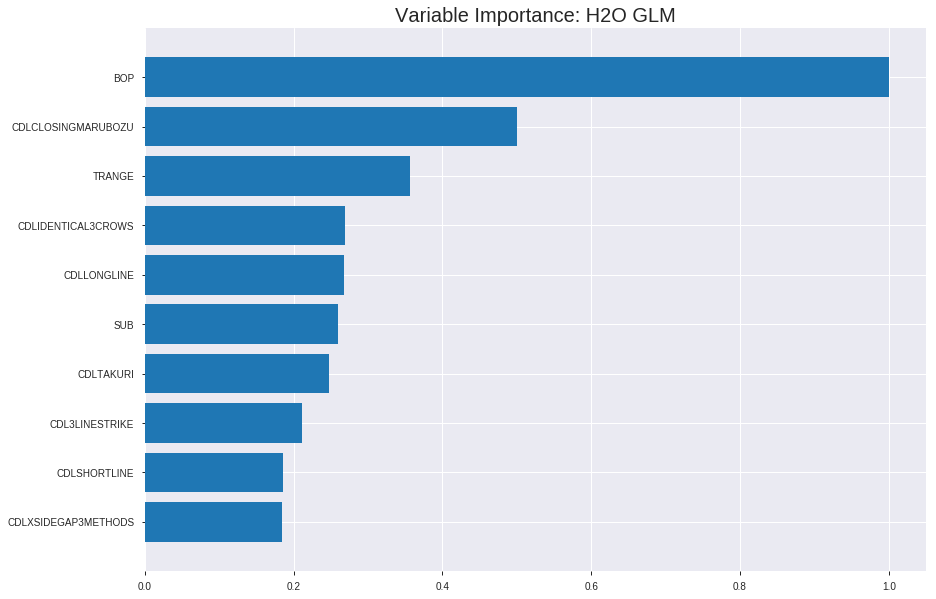

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_180052_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19090317261547393
RMSE: 0.4369246761347703
LogLoss: 0.5630281945344466
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2156.7629615535493
Residual deviance: 1752.143741391198
AIC: 1854.143741391198
AUC: 0.7811201279655234
pr_auc: 0.7774340520813915
Gini: 0.5622402559310469
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43004216544633045: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      476  313  0.3967   (313.0/789.0)
1      152  615  0.1982   (152.0/767.0)
Total  628  928  0.2988   (465.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430042     0.725664  231
max f2                       0.226996     0.838644  325
max f0point5                 0.548555     0.729013  171
max accuracy                 0.548555     0.72108   171
max precision                0.981661     1         0
max recall                   0.0690773    1         383
max specificity              0.981661     1         0
max absolute_mcc             0.548555     0.445424  171
max min_per_class_accuracy   0.493645     0.706649  197
max mean_per_class_accuracy  0.548555     0.720024  171

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 49.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.933196           2.02868   2.02868            1                0.957216   1                           0.957216            0.0208605       0.0208605                  102.868   102.868
    2        0.0205656                   0.915078           1.7751    1.90189            0.875            0.923806   0.9375                      0.940511            0.0182529       0.0391134                  77.5098   90.189
    3        0.0302057                   0.90037            2.02868   1.94236            1                0.909074   0.957447                    0.930478            0.0195567       0.0586701                  102.868   94.2356
    4        0.0404884                   0.886199           1.90189   1.93208            0.9375           0.894884   0.952381                    0.921438            0.0195567       0.0782269                  90.189    93.2079
    5        0.0501285                   0.872671           1.75819   1.89864            0.866667         0.880206   0.935897                    0.913509            0.0169492       0.095176                   75.8192   89.8639
    6        0.100257                    0.814612           1.82061   1.85963            0.897436         0.841675   0.916667                    0.877592            0.0912647       0.186441                   82.0613   85.9626
    7        0.150386                    0.773322           1.63855   1.78593            0.807692         0.791788   0.880342                    0.84899             0.0821382       0.268579                   63.8552   78.5935
    8        0.200514                    0.71229            1.58653   1.73608            0.782051         0.742779   0.855769                    0.822437            0.0795306       0.34811                    58.6534   73.6085
    9        0.300129                    0.633567           1.42662   1.63337            0.703226         0.672125   0.805139                    0.772548            0.142112        0.490222                   42.6622   63.3372
    10       0.400386                    0.564853           1.27443   1.54349            0.628205         0.597974   0.760835                    0.728834            0.127771        0.617992                   27.4429   54.3493
    11       0.5                         0.49061            0.929268  1.42112            0.458065         0.525704   0.700514                    0.688365            0.0925684       0.710561                   -7.07322  42.1121
    12       0.600257                    0.427101           0.936315  1.34015            0.461538         0.45934    0.6606                      0.650112            0.0938722       0.804433                   -6.36847  34.0147
    13       0.699871                    0.353209           0.615149  1.23696            0.303226         0.390654   0.609734                    0.613183            0.0612777       0.865711                   -38.4851  23.6957
    14       0.800129                    0.276035           0.62421   1.16018            0.307692         0.313817   0.571888                    0.575672            0.0625815       0.928292                   -37.579   16.0179
    15       0.899743                    0.163093           0.405737  1.07665            0.2              0.223854   0.530714                    0.536721            0.0404172       0.968709                   -59.4263  7.66511
    16       1                           0.0018551          0.312105  1                  0.153846         0.0999412  0.492931                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1903989817346087
RMSE: 0.43634731778092634
LogLoss: 0.5600829969474249
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 615.4911432999108
Residual deviance: 498.4738672832082
AIC: 600.4738672832082
AUC: 0.7779895090566348
pr_auc: 0.7211814458180594
Gini: 0.5559790181132696
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42351399748464735: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      147  102  0.4096   (102.0/249.0)
1      40   156  0.2041   (40.0/196.0)
Total  187  258  0.3191   (142.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423514     0.687225  230
max f2                       0.222917     0.83118   335
max f0point5                 0.578546     0.694444  139
max accuracy                 0.578546     0.719101  139
max precision                0.840799     0.909091  21
max recall                   0.140752     1         361
max specificity              0.955837     0.995984  0
max absolute_mcc             0.578546     0.425611  139
max min_per_class_accuracy   0.49263      0.709184  189
max mean_per_class_accuracy  0.49263      0.712022  189

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 46.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.905545           1.36224   1.36224            0.6              0.931284   0.6                         0.931284            0.0153061       0.0153061                  36.2245   36.2245
    2        0.0202247                   0.894585           2.27041   1.76587            1                0.899814   0.777778                    0.917297            0.0204082       0.0357143                  127.041   76.5873
    3        0.0314607                   0.867815           2.27041   1.94606            1                0.88122    0.857143                    0.904412            0.0255102       0.0612245                  127.041   94.6064
    4        0.0404494                   0.849643           2.27041   2.01814            1                0.856539   0.888889                    0.893774            0.0204082       0.0816327                  127.041   101.814
    5        0.0516854                   0.828203           1.81633   1.97427            0.8              0.842556   0.869565                    0.882639            0.0204082       0.102041                   81.6327   97.4268
    6        0.101124                    0.782429           2.06401   2.01814            0.909091         0.797326   0.888889                    0.840931            0.102041        0.204082                   106.401   101.814
    7        0.150562                    0.717085           1.85761   1.96543            0.818182         0.75196    0.865672                    0.811716            0.0918367       0.295918                   85.7607   96.5428
    8        0.2                         0.674248           1.44481   1.83673            0.636364         0.692416   0.808989                    0.782226            0.0714286       0.367347                   44.4805   83.6735
    9        0.301124                    0.607863           1.36224   1.67739            0.6              0.640957   0.738806                    0.734785            0.137755        0.505102                   36.2245   67.7391
    10       0.4                         0.536552           1.0836    1.53061            0.477273         0.568152   0.674157                    0.693595            0.107143        0.612245                   8.36039   53.0612
    11       0.501124                    0.471305           1.10998   1.44573            0.488889         0.502964   0.636771                    0.655127            0.112245        0.72449                    10.9977   44.5731
    12       0.6                         0.399899           0.774003  1.33503            0.340909         0.439094   0.588015                    0.619526            0.0765306       0.80102                    -22.5997  33.5034
    13       0.698876                    0.340092           0.670802  1.24106            0.295455         0.367945   0.546624                    0.583932            0.0663265       0.867347                   -32.9198  24.1059
    14       0.8                         0.267807           0.85771   1.1926             0.377778         0.297563   0.525281                    0.547734            0.0867347       0.954082                   -14.229   19.2602
    15       0.898876                    0.160346           0.309601  1.09547            0.136364         0.215438   0.4825                      0.511181            0.0306122       0.984694                   -69.0399  9.54719
    16       1                           0.023278           0.151361  1                  0.0666667        0.0975866  0.440449                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 18:00:53  0.000 sec   2            .2E2      48            1.369025247124896   1.3667926196722844
     2019-08-26 18:00:53  0.024 sec   4            .13E2     50            1.3597096194687013  1.3578345411470125
     2019-08-26 18:00:53  0.042 sec   6            .78E1     51            1.3462162563136268  1.344809796764743
     2019-08-26 18:00:53  0.054 sec   8            .48E1     51            1.3276521310954665  1.3267751446132436
     2019-08-26 18:00:53  0.076 sec   10           .3E1      51            1.3038958637039821  1.303498439898478
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 18:00:53  0.258 sec   36           .61E-2    51            1.1252372573642682  1.1202813368138003
     2019-08-26 18:00:53  0.276 sec   38           .38E-2    51            1.1247220475739046  1.121202977249767
     2019-08-26 18:00:53  0.285 sec   39           .24E-2    51            1.1243687372523266  1.122526596660376
     2019-08-26 18:00:53  0.295 sec   40           .15E-2    51            1.1240623500056153  1.1246141877801785
     2019-08-26 18:00:53  0.305 sec   41           .91E-3    51            1.1237736624267793  1.1273955591283766


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.695067264573991)

('F1', 0.6830985915492959)

('auc', 0.7271035598705501)

('logloss', 0.60420772159549)

('mean_per_class_error', 0.31978155339805825)

('rmse', 0.45782294350811026)

('mse', 0.20960184760243034)

glm prediction progress: |████████████████████████████████████████████████| 100%


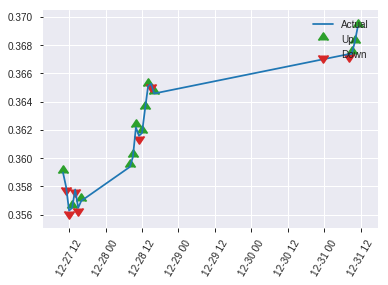


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20960184760243034
RMSE: 0.45782294350811026
LogLoss: 0.60420772159549
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.7074742286341
Residual deviance: 269.4766438315885
AIC: 371.4766438315885
AUC: 0.7271035598705501
pr_auc: 0.6887252296209423
Gini: 0.4542071197411002
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2143084402792057: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      36   84   0.7      (84.0/120.0)
1      6    97   0.0583   (6.0/103.0)
Total  42   181  0.4036   (90.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.214308     0.683099  180
max f2                       0.134566     0.829268  202
max f0point5                 0.596724     0.690141  62
max accuracy                 0.596724     0.695067  62
max precision                0.978849     1         0
max recall                   0.0975573    1         210
max specificity              0.978849     1         0
max absolute_mcc             0.596724     0.397601  62
max min_per_class_accuracy   0.450156     0.666667  108
max mean_per_class_accuracy  0.590252     0.680218  64

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 45.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.914391           2.16505   2.16505            1                0.946824   1                           0.946824            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.910437           1.08252   1.73204            0.5              0.910691   0.8                         0.932371            0.00970874      0.038835                   8.25243   73.2039
    3        0.0313901                   0.889276           1.08252   1.54646            0.5              0.901564   0.714286                    0.923569            0.00970874      0.0485437                  8.25243   54.6463
    4        0.0403587                   0.87444            2.16505   1.68393            1                0.883745   0.777778                    0.914719            0.0194175       0.0679612                  116.505   68.3927
    5        0.0538117                   0.850336           2.16505   1.80421            1                0.85958    0.833333                    0.900934            0.0291262       0.0970874                  116.505   80.4207
    6        0.103139                    0.773103           1.57458   1.69439            0.727273         0.805384   0.782609                    0.855236            0.0776699       0.174757                   57.4581   69.4386
    7        0.152466                    0.735935           1.96823   1.78298            0.909091         0.751528   0.823529                    0.821684            0.0970874       0.271845                   96.8226   78.2981
    8        0.201794                    0.687851           1.7714    1.78015            0.818182         0.714223   0.822222                    0.795416            0.0873786       0.359223                   77.1403   78.0151
    9        0.300448                    0.578495           1.27935   1.61571            0.590909         0.630373   0.746269                    0.741223            0.126214        0.485437                   27.9347   61.5708
    10       0.399103                    0.50486            0.78729   1.41093            0.363636         0.544637   0.651685                    0.692628            0.0776699       0.563107                   -21.271   41.0931
    11       0.502242                    0.438153           1.22372   1.37249            0.565217         0.470068   0.633929                    0.646924            0.126214        0.68932                    22.3723   37.2486
    12       0.600897                    0.365734           0.393645  1.21178            0.181818         0.400931   0.559701                    0.606537            0.038835        0.728155                   -60.6355  21.1781
    13       0.699552                    0.303398           0.885702  1.1658             0.409091         0.334718   0.538462                    0.568204            0.0873786       0.815534                   -11.4298  16.5795
    14       0.798206                    0.225526           1.08252   1.1555             0.5              0.267121   0.533708                    0.530991            0.106796        0.92233                    8.25243   15.5503
    15       0.896861                    0.153209           0.590468  1.09335            0.272727         0.184296   0.505                       0.492855            0.0582524       0.980583                   -40.9532  9.33495
    16       1                           0.0125749          0.188265  1                  0.0869565        0.0841591  0.461883                   

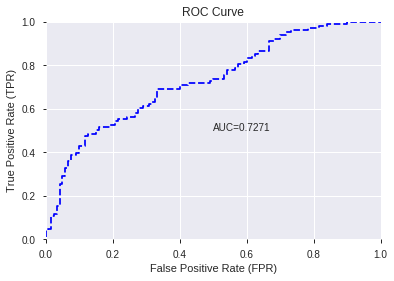

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


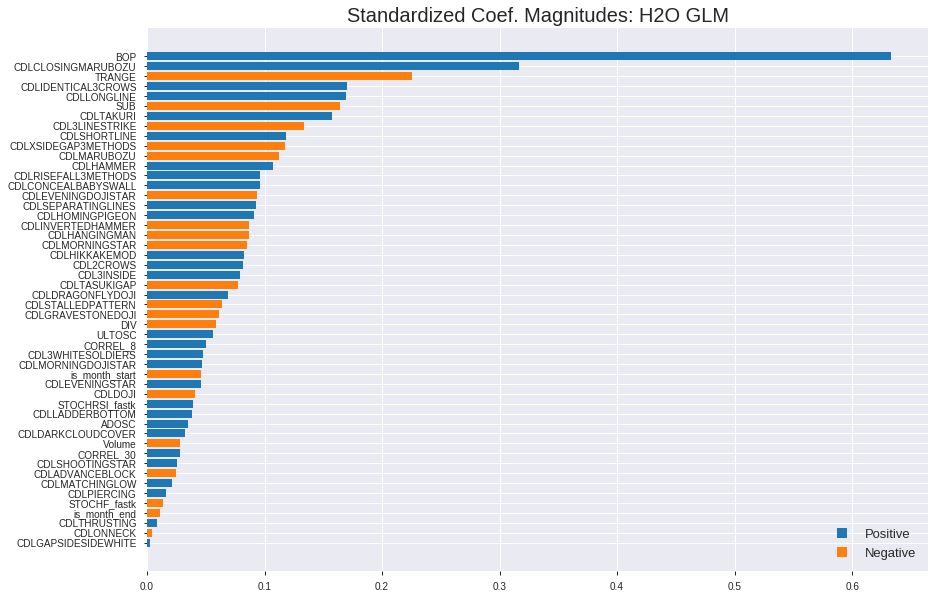

'log_likelihood'
--2019-08-26 18:00:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_180052_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_180052_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'CDLIDENTICAL3CROWS',
 'CDLLONGLINE',
 'SUB',
 'CDLTAKURI',
 'CDL3LINESTRIKE',
 'CDLSHORTLINE',
 'CDLXSIDEGAP3METHODS',
 'CDLMARUBOZU',
 'CDLHAMMER',
 'CDLRISEFALL3METHODS',
 'CDLCONCEALBABYSWALL',
 'CDLEVENINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CDLHOMINGPIGEON',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLMORNINGSTAR',
 'CDLHIKKAKEMOD',
 'CDL2CROWS',
 'CDL3INSIDE',
 'CDLTASUKIGAP',
 'CDLDRAGONFLYDOJI',
 'CDLSTALLEDPATTERN',
 'CDLGRAVESTONEDOJI',
 'DIV',
 'ULTOSC',
 'CORREL_8',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'is_month_start',
 'CDLEVENINGSTAR',
 'CDLDOJI',
 'STOCHRSI_fastk',
 'CDLLADDERBOTTOM',
 'ADOSC',
 'CDLDARKCLOUDCOVER',
 'Volume',
 'CORREL_30',
 'CDLSHOOTINGSTAR',
 'CDLADVANCEBLOCK',
 'CDLMATCHINGLOW',
 'CDLPIERCING',
 'STOCHF_fastk',
 'is_month_end',
 'CDLTHRUSTING',
 'CDLONNECK',
 'CDLGAPSIDESIDEWHITE']

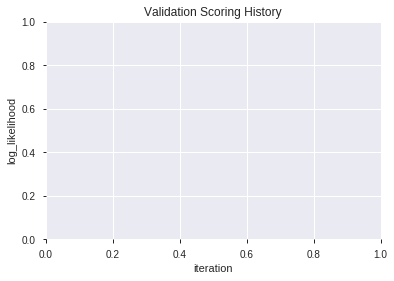

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_180103_model_4  0.772654  0.573628              0.344417  0.442432  0.195746
1  XGBoost_grid_1_AutoML_20190826_180103_model_6  0.767152  0.571670              0.310963  0.441723  0.195119
2               XGBoost_1_AutoML_20190826_180103  0.766748  0.572839              0.285922  0.443148  0.196380
3               XGBoost_2_AutoML_20190826_180103  0.765534  0.578476              0.279652  0.444918  0.197952
4               XGBoost_3_AutoML_20190826_180103  0.761974  0.569602              0.317921  0.442112  0.195463
5  XGBoost_grid_1_AutoML_20190826_180103_model_7  0.761812  0.575646              0.342273  0.444032  0.197165
6  XGBoost_grid_1_AutoML_20190826_180103_model_2  0.761003  0.581410              0.354814  0.445523  0.198491
7  XGBoost_grid_1_AutoML_20190826_180103_model_5  0.759709  0.591688              0.285963  0.449532  0.202079
8  XGBoost_grid_1_AutoML_20190826_180103_model_1  0.755583  0.578398              0.303277  0.445665  0.198618
9  XGBoost_grid_1_AutoML_20190826_180103_model_3  0.740777  0.589325              0.378439  0.449807  0.202327

variable  relative_importance  scaled_importance  percentage
0                  BOP          2048.653076           1.000000    0.454948
1                  DIV           572.716125           0.279557    0.127184
2               TRANGE           385.664703           0.188253    0.085645
3               Volume           266.517792           0.130094    0.059186
4            CORREL_30           263.674896           0.128706    0.058555
5               ULTOSC           246.117157           0.120136    0.054656
6         STOCHF_fastk           200.128677           0.097688    0.044443
7                  SUB           181.857666           0.088769    0.040385
8       STOCHRSI_fastk           173.103760           0.084496    0.038441
9                ADOSC           147.293106           0.071898    0.032710
10         CDLLONGLINE            12.672489           0.006186    0.002814
11  CDLCLOSINGMARUBOZU             4.653879           0.002272    0.001033

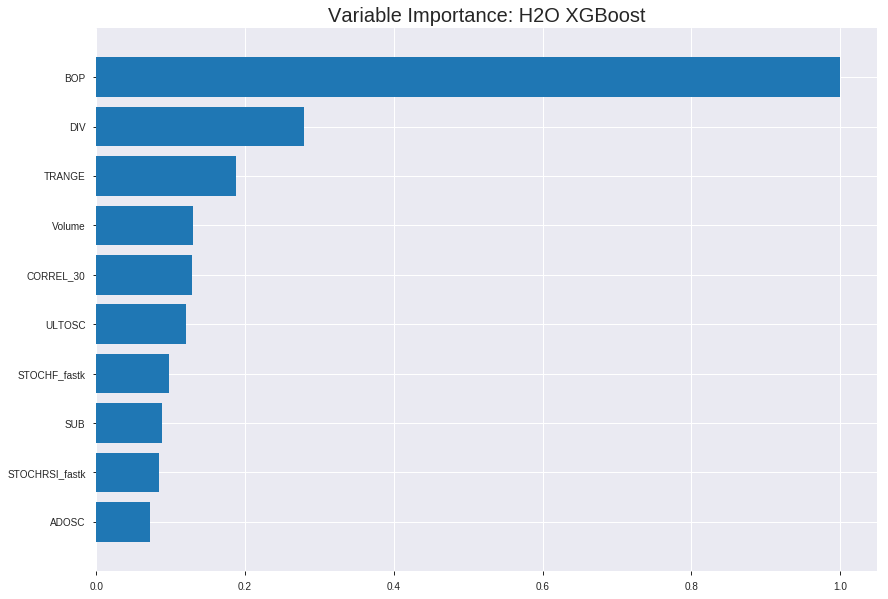

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_180103_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1774759455069126
RMSE: 0.4212789402603845
LogLoss: 0.5336797458124182
Mean Per-Class Error: 0.25337057949676367
AUC: 0.8163651776463531
pr_auc: 0.8049890857520696
Gini: 0.6327303552927062
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4363441109657288: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      524  265  0.3359   (265.0/789.0)
1      135  632  0.176    (135.0/767.0)
Total  659  897  0.2571   (400.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436344     0.759615  232
max f2                       0.260182     0.848947  323
max f0point5                 0.550146     0.747567  173
max accuracy                 0.469533     0.746144  213
max precision                0.890284     1         0
max recall                   0.119122     1         388
max specificity              0.890284     1         0
max absolute_mcc             0.438581     0.494606  231
max min_per_class_accuracy   0.496907     0.740548  201
max mean_per_class_accuracy  0.467504     0.746629  214

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 49.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.864041           1.90189   1.90189            0.9375           0.873837  0.9375                      0.873837            0.0195567       0.0195567                  90.189    90.189
    2        0.0205656                   0.854348           2.02868   1.96529            1                0.858393  0.96875                     0.866115            0.0208605       0.0404172                  102.868   96.5287
    3        0.0302057                   0.84676            2.02868   1.98552            1                0.850249  0.978723                    0.861051            0.0195567       0.0599739                  102.868   98.552
    4        0.0404884                   0.839216           1.90189   1.96428            0.9375           0.842835  0.968254                    0.856425            0.0195567       0.0795306                  90.189    96.4281
    5        0.0501285                   0.833297           2.02868   1.97667            1                0.836183  0.974359                    0.852532            0.0195567       0.0990874                  102.868   97.6666
    6        0.100257                    0.794326           1.74259   1.85963            0.858974         0.811683  0.916667                    0.832108            0.0873533       0.186441                   74.2587   85.9626
    7        0.150386                    0.764874           1.69057   1.80327            0.833333         0.779209  0.888889                    0.814475            0.0847458       0.271186                   69.0569   80.3274
    8        0.200514                    0.734853           1.53452   1.73608            0.75641          0.749963  0.855769                    0.798347            0.0769231       0.34811                    53.4517   73.6085
    9        0.300129                    0.655377           1.51824   1.66378            0.748387         0.69749   0.820128                    0.764872            0.151239        0.499348                   51.824    66.3781
    10       0.400386                    0.570182           1.33945   1.58257            0.660256         0.611179  0.780096                    0.726387            0.134289        0.633638                   33.9451   58.2568
    11       0.5                         0.493437           1.12559   1.49153            0.554839         0.52989   0.735219                    0.687239            0.112125        0.745763                   12.5592   49.1525
    12       0.600257                    0.415897           0.923311  1.39662            0.455128         0.454279  0.688437                    0.648329            0.0925684       0.838331                   -7.66891  39.662
    13       0.699871                    0.33826            0.615149  1.28539            0.303226         0.374424  0.633609                    0.609344            0.0612777       0.899609                   -38.4851  28.5392
    14       0.800129                    0.262127           0.507171  1.18788            0.25             0.298867  0.585542                    0.570441            0.0508475       0.950456                   -49.2829  18.788
    15       0.899743                    0.186683           0.314119  1.09114            0.154839         0.230062  0.537857                    0.532756            0.0312907       0.981747                   -68.5881  9.11417
    16       1                           0.098579           0.182061  1                  0.0897436        0.136894  0.492931                    0.493068            0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18072067533939998
RMSE: 0.4251125443213832
LogLoss: 0.53898423694273
Mean Per-Class Error: 0.27484427505942133
AUC: 0.8040017211703959
pr_auc: 0.7489769749126499
Gini: 0.6080034423407918
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2965640723705292: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  130  0.5221   (130.0/249.0)
1      15   181  0.0765   (15.0/196.0)
Total  134  311  0.3258   (145.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.296564     0.714004  287
max f2                       0.284333     0.840072  299
max f0point5                 0.570675     0.717949  138
max accuracy                 0.570675     0.734831  138
max precision                0.896098     1         0
max recall                   0.153453     1         367
max specificity              0.896098     1         0
max absolute_mcc             0.570675     0.45982   138
max min_per_class_accuracy   0.447426     0.719388  196
max mean_per_class_accuracy  0.447426     0.725156  196

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 45.38 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.840917           2.27041    2.27041            1                0.869235  1                           0.869235            0.0255102       0.0255102                  127.041   127.041
    2        0.0202247                   0.8275             1.70281    2.01814            0.75             0.833647  0.888889                    0.853418            0.0153061       0.0408163                  70.2806   101.814
    3        0.0314607                   0.819156           2.27041    2.10824            1                0.823015  0.928571                    0.84256             0.0255102       0.0663265                  127.041   110.824
    4        0.0404494                   0.807146           2.27041    2.14427            1                0.814058  0.944444                    0.836226            0.0204082       0.0867347                  127.041   114.427
    5        0.0516854                   0.801645           1.36224    1.97427            0.6              0.803482  0.869565                    0.829108            0.0153061       0.102041                   36.2245   97.4268
    6        0.101124                    0.757858           1.96081    1.96769            0.863636         0.780782  0.866667                    0.805482            0.0969388       0.19898                    96.0807   96.7687
    7        0.150562                    0.730208           1.75441    1.89765            0.772727         0.745977  0.835821                    0.785943            0.0867347       0.285714                   75.4406   89.7655
    8        0.2                         0.690162           1.75441    1.86224            0.772727         0.713084  0.820225                    0.767933            0.0867347       0.372449                   75.4406   86.2245
    9        0.301124                    0.599624           1.56406    1.76211            0.688889         0.646092  0.776119                    0.727016            0.158163        0.530612                   56.4059   76.2108
    10       0.4                         0.50616            1.1352     1.60714            0.5              0.549802  0.707865                    0.68321             0.112245        0.642857                   13.5204   60.7143
    11       0.501124                    0.427513           0.958617   1.47627            0.422222         0.465697  0.650224                    0.639318            0.0969388       0.739796                   -4.13832  47.6274
    12       0.6                         0.370498           0.774003   1.36054            0.340909         0.396521  0.599251                    0.599306            0.0765306       0.816327                   -22.5997  36.0544
    13       0.698876                    0.294472           1.0836     1.32136            0.477273         0.332849  0.581994                    0.561608            0.107143        0.923469                   8.36039   32.1363
    14       0.8                         0.249109           0.454082   1.21173            0.2              0.273226  0.533708                    0.525155            0.0459184       0.969388                   -54.5918  21.1735
    15       0.898876                    0.16495            0.258001   1.10682            0.113636         0.206217  0.4875                      0.490072            0.0255102       0.994898                   -74.1999  10.6824
    16       1                           0.101877           0.0504535  1                  0.0222222        0.131551  0.440449                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:01:17  3.184 sec   0                  0.5              0.693147            0.5             0                  1                0.507069                         0.5                0.693147              0.5               0                    1                  0.559551
    2019-08-26 18:01:17  3.239 sec   5                  0.47804          0.649935            0.782016        0.736039           2.02868          0.304627                         0.477022           0.647965              0.79182           0.724829             2.27041            0.301124
    2019-08-26 18:01:17  3.277 sec   10                 0.462795         0.620215            0.788398        0.763032           1.90189          0.280206                         0.461057           0.616834              0.797455          0.757508             2.27041            0.289888
    2019-08-26 18:01:17  3.319 sec   15                 0.452538         0.599952            0.791127        0.778485           2.02868          0.280848                         0.44948            0.593961              0.802905          0.764211             2.27041            0.332584
    2019-08-26 18:01:17  3.359 sec   20                 0.445634         0.585933            0.793875        0.78306            1.90189          0.291774                         0.442482           0.579467              0.802444          0.761826             2.27041            0.332584
    2019-08-26 18:01:17  3.408 sec   25                 0.440739         0.575662            0.795353        0.783937           1.90189          0.282776                         0.437508           0.56887               0.803551          0.762724             2.27041            0.330337
    2019-08-26 18:01:18  3.453 sec   30                 0.436806         0.567273            0.797417        0.784524           1.90189          0.284062                         0.433581           0.56017               0.804596          0.763722             2.27041            0.319101
    2019-08-26 18:01:18  3.496 sec   35                 0.434077         0.561505            0.800536        0.786431           1.90189          0.282776                         0.431152           0.554567              0.8052            0.762909             2.27041            0.323596
    2019-08-26 18:01:18  3.553 sec   40                 0.431823         0.556633            0.802037        0.787421           1.90189          0.271851                         0.429789           0.551392              0.80643           0.761047             2.27041            0.32809
    2019-08-26 18:01:18  3.612 sec   45                 0.429977         0.552358            0.803107        0.790714           1.90189          0.271851                         0.427097           0.544907              0.80771           0.762393             2.27041            0.32809
    2019-08-26 18:01:18  3.681 sec   50                 0.428138         0.548378            0.805873        0.79534            2.02868          0.274422                         0.426291           0.543211              0.809503          0.758992             2.27041            0.32809
    2019-08-26 18:01:18  3.732 sec   55                 0.426533         0.545032            0.808742        0.797992           1.90189          0.261568                         0.42587            0.541905              0.807751          0.75

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 2048.65                1                    0.454948
DIV                 572.716                0.279557             0.127184
TRANGE              385.665                0.188253             0.0856452
Volume              266.518                0.130094             0.059186
CORREL_30           263.675                0.128706             0.0585547
ULTOSC              246.117                0.120136             0.0546556
STOCHF_fastk        200.129                0.0976879            0.0444429
SUB                 181.858                0.0887694            0.0403854
STOCHRSI_fastk      173.104                0.0844964            0.0384414
ADOSC               147.293                0.0718975            0.0327096
CDLLONGLINE         12.6725                0.00618577           0.0028142
CDLCLOSINGMARUBOZU  4.65388                0.00227168           0.00103349

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.7071428571428572)

('auc', 0.772653721682848)

('logloss', 0.5736279553053041)

('mean_per_class_error', 0.2879854368932039)

('rmse', 0.4424321611483486)

('mse', 0.19574621721839833)

xgboost prediction progress: |████████████████████████████████████████████| 100%


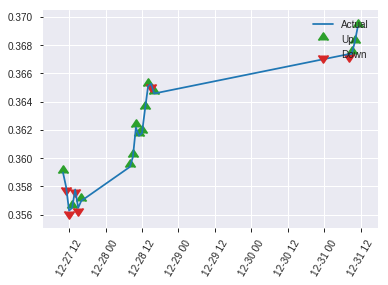


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19574621721839833
RMSE: 0.4424321611483486
LogLoss: 0.5736279553053041
Mean Per-Class Error: 0.2879854368932039
AUC: 0.772653721682848
pr_auc: 0.7391452602983183
Gini: 0.5453074433656959
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2022911161184311: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   78   0.65     (78.0/120.0)
1      4    99   0.0388   (4.0/103.0)
Total  46   177  0.3677   (82.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.202291     0.707143  176
max f2                       0.202291     0.840407  176
max f0point5                 0.495006     0.701149  82
max accuracy                 0.495006     0.713004  82
max precision                0.895045     1         0
max recall                   0.133693     1         207
max specificity              0.895045     1         0
max absolute_mcc             0.423623     0.423515  104
max min_per_class_accuracy   0.420482     0.708333  107
max mean_per_class_accuracy  0.423623     0.712015  104

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 41.98 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.85174            2.16505    2.16505            1                0.869035  1                           0.869035            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.840152           2.16505    2.16505            1                0.845748  1                           0.85972             0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.820063           1.08252    1.85576            0.5              0.829039  0.857143                    0.850954            0.00970874      0.0582524                  8.25243   85.5756
    4        0.0403587                   0.814646           2.16505    1.92449            1                0.818514  0.888889                    0.843745            0.0194175       0.0776699                  116.505   92.4488
    5        0.0538117                   0.793384           1.44337    1.80421            0.666667         0.803479  0.833333                    0.833679            0.0194175       0.0970874                  44.3366   80.4207
    6        0.103139                    0.734021           2.16505    1.97678            1                0.753769  0.913043                    0.795461            0.106796        0.203883                   116.505   97.6783
    7        0.152466                    0.675705           1.7714     1.91034            0.818182         0.698948  0.882353                    0.764236            0.0873786       0.291262                   77.1403   91.0337
    8        0.201794                    0.643326           1.37776    1.78015            0.636364         0.660363  0.822222                    0.738845            0.0679612       0.359223                   37.7758   78.0151
    9        0.300448                    0.541551           1.47617    1.68034            0.681818         0.59815   0.776119                    0.692647            0.145631        0.504854                   47.6169   68.0336
    10       0.399103                    0.471638           1.08252    1.53256            0.5              0.506378  0.707865                    0.646603            0.106796        0.61165                    8.25243   53.2562
    11       0.502242                    0.410235           0.941325   1.41115            0.434783         0.436343  0.651786                    0.603424            0.0970874       0.708738                   -5.86745  41.1148
    12       0.600897                    0.315219           0.688879   1.29257            0.318182         0.364551  0.597015                    0.564206            0.0679612       0.776699                   -31.1121  29.2566
    13       0.699552                    0.267598           0.885702   1.23519            0.409091         0.289653  0.570513                    0.525487            0.0873786       0.864078                   -11.4298  23.5188
    14       0.798206                    0.19647            0.984113   1.20416            0.454545         0.232844  0.55618                     0.489318            0.0970874       0.961165                   -1.5887   20.4156
    15       0.896861                    0.143107           0.295234   1.10417            0.136364         0.164884  0.51                        0.45363             0.0291262       0.990291                   -70.4766  10.4175
    16       1                           0.099039           0.0941325  1                  0.0434783        0.125735  0.461883                   

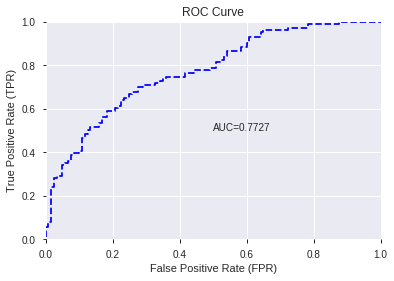

This function is available for GLM models only


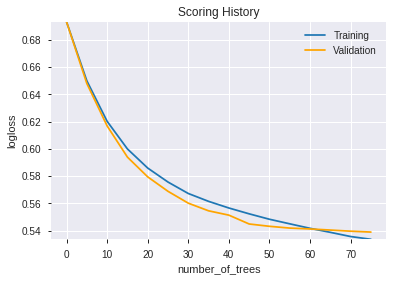

--2019-08-26 18:01:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_180103_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_180103_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'Volume',
 'CORREL_30',
 'ULTOSC',
 'STOCHF_fastk',
 'SUB',
 'STOCHRSI_fastk',
 'ADOSC',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190826_180133_model_1  0.752994  0.589765              0.333981  0.44998  0.202482

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.386358           1.000000  2.270327e-02
1                       ULTOSC             0.264403           0.684347  1.553692e-02
2                        ADOSC             0.237883           0.615706  1.397853e-02
3                 STOCHF_fastk             0.201028           0.520316  1.181287e-02
4                  CDLLONGLINE             0.196932           0.509712  1.157213e-02
...                        ...                  ...                ...           ...
1034                    SMA_12             0.000056           0.000146  3.311305e-06
1035                PLUS_DM_12             0.000050           0.000130  2.952461e-06
1036    BBANDS_lowerband_8_1_5             0.000045           0.000117  2.660412e-06
1037  BBANDS_middleband_20_0_3             0.000015           0.000039  8.781756e-07
1038   BBANDS_lowerband_30_5_2             0.000010           0.000027  6.134320e-07

[1039 rows x 4 columns]

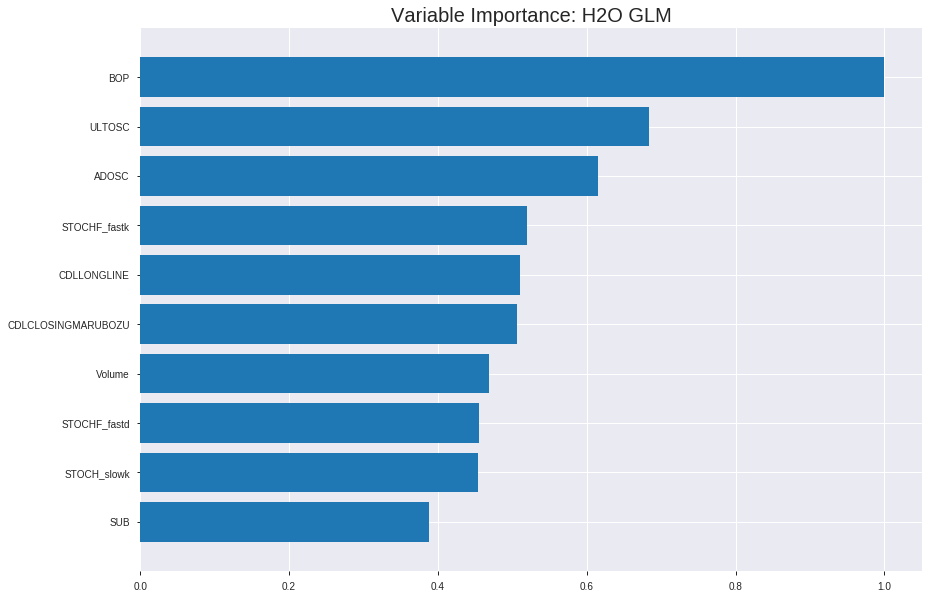

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_180133_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17272789379996611
RMSE: 0.4156054544877462
LogLoss: 0.5194657439528015
Null degrees of freedom: 1555
Residual degrees of freedom: 516
Null deviance: 2156.7629615535493
Residual deviance: 1616.5773951811184
AIC: 3696.5773951811184
AUC: 0.8234698750584554
pr_auc: 0.8134234884219672
Gini: 0.6469397501169107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3279602021447743: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      397  392   0.4968   (392.0/789.0)
1      64   703   0.0834   (64.0/767.0)
Total  461  1095  0.2931   (456.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.32796      0.755102  273
max f2                       0.208413     0.853379  323
max f0point5                 0.633124     0.757258  137
max accuracy                 0.497575     0.747429  197
max precision                0.975966     1         0
max recall                   0.0572725    1         385
max specificity              0.975966     1         0
max absolute_mcc             0.496279     0.494908  198
max min_per_class_accuracy   0.497575     0.745247  197
max mean_per_class_accuracy  0.496279     0.747479  198

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 49.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.939026           2.02868   2.02868            1                0.956258   1                           0.956258            0.0208605       0.0208605                  102.868   102.868
    2        0.0205656                   0.927953           2.02868   2.02868            1                0.933061   1                           0.944659            0.0208605       0.041721                   102.868   102.868
    3        0.0302057                   0.912305           1.75819   1.94236            0.866667         0.920537   0.957447                    0.936961            0.0169492       0.0586701                  75.8192   94.2356
    4        0.0404884                   0.89968            1.90189   1.93208            0.9375           0.906349   0.952381                    0.929186            0.0195567       0.0782269                  90.189    93.2079
    5        0.0501285                   0.886816           1.75819   1.89864            0.866667         0.892119   0.935897                    0.922058            0.0169492       0.095176                   75.8192   89.8639
    6        0.100257                    0.839221           1.7686    1.83362            0.871795         0.862386   0.903846                    0.892222            0.0886571       0.183833                   76.8596   83.3617
    7        0.150386                    0.783869           1.82061   1.82928            0.897436         0.807407   0.901709                    0.86395             0.0912647       0.275098                   82.0613   82.9283
    8        0.200514                    0.74246            1.61254   1.7751             0.794872         0.760783   0.875                       0.838159            0.0808344       0.355932                   61.2543   77.5098
    9        0.300129                    0.659328           1.59677   1.71591            0.787097         0.700531   0.845824                    0.792479            0.159061        0.514993                   59.677    71.591
    10       0.400386                    0.577839           1.1964    1.58582            0.589744         0.618482   0.781701                    0.74891             0.119948        0.634941                   19.6403   58.5825
    11       0.5                         0.495027           1.16486   1.50196            0.574194         0.533805   0.74036                     0.706055            0.116037        0.750978                   16.4857   50.1956
    12       0.600257                    0.411987           0.806272  1.38576            0.397436         0.452185   0.683084                    0.663653            0.0808344       0.831812                   -19.3728  38.576
    13       0.699871                    0.330443           0.811473  1.30402            0.4              0.372332   0.642792                    0.622188            0.0808344       0.912647                   -18.8527  30.402
    14       0.800129                    0.243943           0.442149  1.19603            0.217949         0.286373   0.589558                    0.58011             0.0443286       0.956975                   -55.7851  19.6027
    15       0.899743                    0.150575           0.287942  1.09549            0.141935         0.19788    0.54                        0.537792            0.0286832       0.985658                   -71.2058  9.54889
    16       1                           0.000512389        0.143048  1                  0.0705128        0.0903299  0.492931                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18278610303281792
RMSE: 0.4275349144021081
LogLoss: 0.5418016580237098
Null degrees of freedom: 444
Residual degrees of freedom: -595
Null deviance: 615.4911432999108
Residual deviance: 482.20347564110176
AIC: 2562.2034756411017
AUC: 0.7975063519383657
pr_auc: 0.7375266271408908
Gini: 0.5950127038767314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43658397110229036: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      162  87   0.3494   (87.0/249.0)
1      40   156  0.2041   (40.0/196.0)
Total  202  243  0.2854   (127.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436584     0.710706  223
max f2                       0.224725     0.828221  320
max f0point5                 0.612413     0.717949  136
max accuracy                 0.560273     0.741573  162
max precision                0.975885     1         0
max recall                   0.0832905    1         375
max specificity              0.975885     1         0
max absolute_mcc             0.560273     0.471745  162
max min_per_class_accuracy   0.480074     0.719388  193
max mean_per_class_accuracy  0.512632     0.735032  179

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 46.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.917836           1.81633   1.81633            0.8              0.937676   0.8                         0.937676            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.884233           2.27041   2.01814            1                0.907119   0.888889                    0.924095            0.0204082       0.0408163                  127.041   101.814
    3        0.0314607                   0.873463           2.27041   2.10824            1                0.877619   0.928571                    0.907496            0.0255102       0.0663265                  127.041   110.824
    4        0.0404494                   0.863397           1.70281   2.01814            0.75             0.870629   0.888889                    0.899304            0.0153061       0.0816327                  70.2806   101.814
    5        0.0516854                   0.850966           2.27041   2.07298            1                0.857739   0.913043                    0.890268            0.0255102       0.107143                   127.041   107.298
    6        0.101124                    0.803692           1.65121   1.86678            0.727273         0.824625   0.822222                    0.858176            0.0816327       0.188776                   65.1206   86.678
    7        0.150562                    0.76522            1.85761   1.86377            0.818182         0.785254   0.820896                    0.834231            0.0918367       0.280612                   85.7607   86.3768
    8        0.2                         0.719891           1.75441   1.83673            0.772727         0.743034   0.808989                    0.811688            0.0867347       0.367347                   75.4406   83.6735
    9        0.301124                    0.622514           1.51361   1.72822            0.666667         0.670614   0.761194                    0.764313            0.153061        0.520408                   51.3605   72.8221
    10       0.4                         0.544825           1.39321   1.64541            0.613636         0.589287   0.724719                    0.721048            0.137755        0.658163                   39.3205   64.5408
    11       0.501124                    0.460003           0.807256  1.47627            0.355556         0.499453   0.650224                    0.676331            0.0816327       0.739796                   -19.2744  47.6274
    12       0.6                         0.377488           0.877203  1.37755            0.386364         0.429351   0.606742                    0.63563             0.0867347       0.826531                   -12.2797  37.7551
    13       0.698876                    0.291217           0.722403  1.28486            0.318182         0.328955   0.565916                    0.592242            0.0714286       0.897959                   -27.7597  28.4861
    14       0.8                         0.225595           0.605442  1.19898            0.266667         0.25594    0.52809                     0.549732            0.0612245       0.959184                   -39.4558  19.898
    15       0.898876                    0.122439           0.309601  1.10115            0.136364         0.182955   0.485                       0.509387            0.0306122       0.989796                   -69.0399  10.1148
    16       1                           0.012696           0.100907  1                  0.0444444        0.0745098  0.440449                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 18:01:36  0.000 sec   2            .2E2      1037          1.3555887297444553  1.3791526266465683
     2019-08-26 18:01:38  1.644 sec   4            .15E2     1038          1.3480467602561528  1.369570595745749
     2019-08-26 18:01:40  3.295 sec   6            .11E2     1038          1.3387438671094247  1.360164748268841
     2019-08-26 18:01:41  4.929 sec   8            .78E1     1038          1.3274863094819191  1.348197909907455
     2019-08-26 18:01:43  6.544 sec   10           .57E1     1039          1.314045271290954   1.333197383864867
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 18:02:13  36.486 sec  46           .19E-1    1040          1.0311101139728651  1.0851588445283524
     2019-08-26 18:02:14  38.156 sec  48           .14E-1    1040          1.0237947636034976  1.0884088283866553
     2019-08-26 18:02:16  39.808 sec  50           .99E-2    1040          1.0168888346262683  1.0931951828208861
     2019-08-26 18:02:18  41.461 sec  52           .72E-2    1040          1.0102539948091904  1.0997427987695818
     2019-08-26 18:02:19  43.128 sec  54           .52E-2    1040          1.003790847050919   1.1081452213843055


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.7084870848708487)

('auc', 0.7529935275080906)

('logloss', 0.589764867235146)

('mean_per_class_error', 0.2976132686084143)

('rmse', 0.4499797860392067)

('mse', 0.20248180784389022)

glm prediction progress: |████████████████████████████████████████████████| 100%


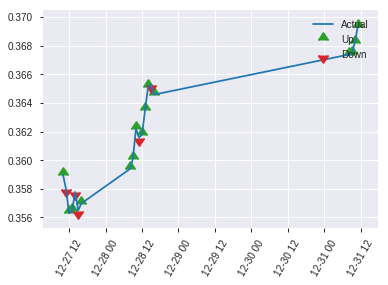


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20248180784389022
RMSE: 0.4499797860392067
LogLoss: 0.589764867235146
Null degrees of freedom: 222
Residual degrees of freedom: -817
Null deviance: 308.7074742286341
Residual deviance: 263.03513078687513
AIC: 2343.035130786875
AUC: 0.7529935275080906
pr_auc: 0.6791932632660567
Gini: 0.5059870550161811
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2716870861046032: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      48   72   0.6      (72.0/120.0)
1      7    96   0.068    (7.0/103.0)
Total  55   168  0.3543   (79.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.271687     0.708487  167
max f2                       0.156186     0.848435  194
max f0point5                 0.600025     0.708861  72
max accuracy                 0.600025     0.713004  72
max precision                0.971293     1         0
max recall                   0.156186     1         194
max specificity              0.971293     1         0
max absolute_mcc             0.600025     0.427123  72
max min_per_class_accuracy   0.451486     0.669903  107
max mean_per_class_accuracy  0.589114     0.702387  76

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 47.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.948431           1.44337   1.44337            0.666667         0.960731   0.666667                    0.960731            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.914499           1.08252   1.29903            0.5              0.929929   0.6                         0.94841             0.00970874      0.0291262                  8.25243   29.9029
    3        0.0313901                   0.910044           2.16505   1.54646            1                0.911827   0.714286                    0.937958            0.0194175       0.0485437                  116.505   54.6463
    4        0.0403587                   0.903568           2.16505   1.68393            1                0.907356   0.777778                    0.931157            0.0194175       0.0679612                  116.505   68.3927
    5        0.0538117                   0.892826           2.16505   1.80421            1                0.898172   0.833333                    0.922911            0.0291262       0.0970874                  116.505   80.4207
    6        0.103139                    0.8485             1.57458   1.69439            0.727273         0.866323   0.782609                    0.895847            0.0776699       0.174757                   57.4581   69.4386
    7        0.152466                    0.793727           1.37776   1.59195            0.636364         0.822683   0.735294                    0.872177            0.0679612       0.242718                   37.7758   59.1947
    8        0.201794                    0.729108           1.7714    1.63581            0.818182         0.76864    0.755556                    0.846868            0.0873786       0.330097                   77.1403   63.5814
    9        0.300448                    0.648729           1.67299   1.64802            0.772727         0.693086   0.761194                    0.796372            0.165049        0.495146                   67.2992   64.8022
    10       0.399103                    0.546079           1.08252   1.50824            0.5              0.587608   0.696629                    0.744767            0.106796        0.601942                   8.25243   50.8236
    11       0.502242                    0.444037           0.941325  1.39182            0.434783         0.490774   0.642857                    0.692608            0.0970874       0.699029                   -5.86745  39.1817
    12       0.600897                    0.362219           0.688879  1.27641            0.318182         0.396072   0.589552                    0.643923            0.0679612       0.76699                    -31.1121  27.6409
    13       0.699552                    0.299276           1.08252   1.24907            0.5              0.334047   0.576923                    0.600223            0.106796        0.873786                   8.25243   24.9066
    14       0.798206                    0.22392            0.688879  1.17983            0.318182         0.26835    0.544944                    0.559205            0.0679612       0.941748                   -31.1121  17.983
    15       0.896861                    0.126796           0.590468  1.115              0.272727         0.171218   0.515                       0.516526            0.0582524       1                          -40.9532  11.5
    16       1                           0.00991038         0         1                  0                0.0746083  0.461883                    0.4

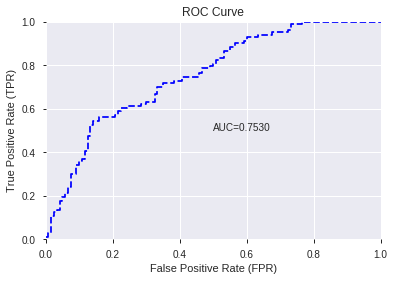

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


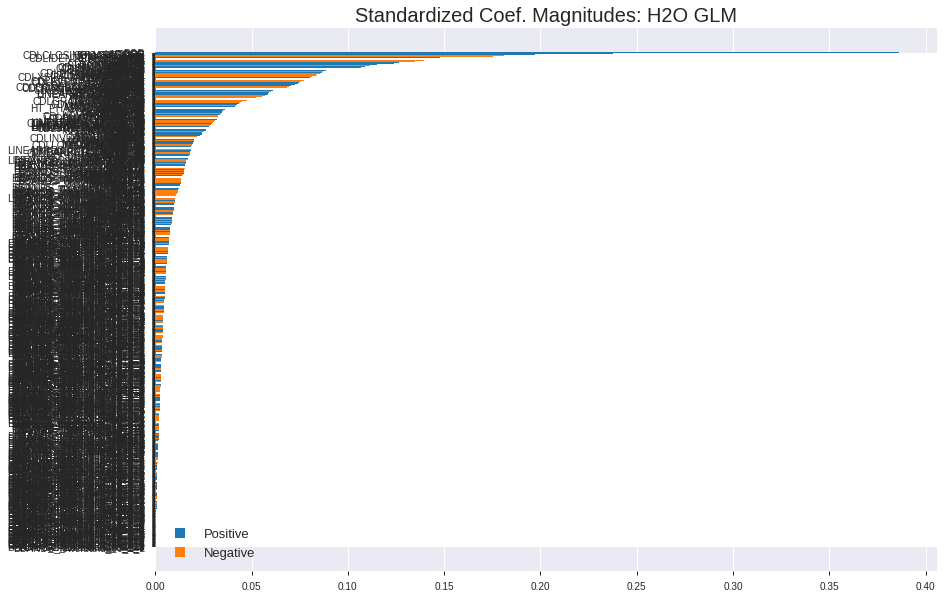

'log_likelihood'
--2019-08-26 18:02:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.116
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.116|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_180133_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_180133_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

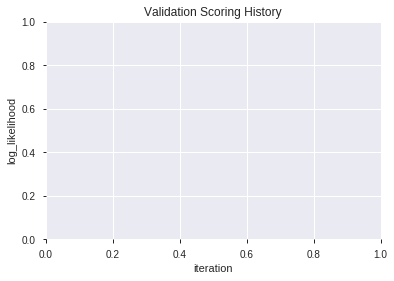

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_180243_model_3  0.787298  0.574681              0.279005  0.441531  0.194950
1               XGBoost_2_AutoML_20190826_180243  0.782282  0.560088              0.318002  0.434884  0.189124
2               XGBoost_1_AutoML_20190826_180243  0.780825  0.563465              0.255380  0.436591  0.190612
3  XGBoost_grid_1_AutoML_20190826_180243_model_6  0.780583  0.598635              0.313107  0.452524  0.204778
4  XGBoost_grid_1_AutoML_20190826_180243_model_1  0.780178  0.591518              0.283859  0.450906  0.203316
5  XGBoost_grid_1_AutoML_20190826_180243_model_2  0.778236  0.587455              0.254652  0.446622  0.199471
6  XGBoost_grid_1_AutoML_20190826_180243_model_7  0.777346  0.579233              0.284587  0.443699  0.196868
7               XGBoost_3_AutoML_20190826_180243  0.775485  0.586143              0.270631  0.448041  0.200740
8  XGBoost_grid_1_AutoML_20190826_180243_model_4  0.771602  0.573006              0.346481  0.440801  0.194305
9  XGBoost_grid_1_AutoML_20190826_180243_model_5  0.757929  0.631568              0.328398  0.469552  0.220479

variable  relative_importance  scaled_importance  percentage
0                        BOP          1136.575928           1.000000    0.135358
1                        DIV           336.472992           0.296041    0.040071
2                        SUB           289.331512           0.254564    0.034457
3             STOCHRSI_fastk           267.324860           0.235202    0.031836
4               STOCHF_fastk           215.339920           0.189464    0.025645
..                       ...                  ...                ...         ...
321       LINEARREG_ANGLE_12             1.191700           0.001049    0.000142
322  BBANDS_lowerband_20_6_2             0.981201           0.000863    0.000117
323               PLUS_DM_24             0.660773           0.000581    0.000079
324                 MAVP_8_3             0.300701           0.000265    0.000036
325  BBANDS_upperband_20_3_5             0.071120           0.000063    0.000008

[326 rows x 4 columns]

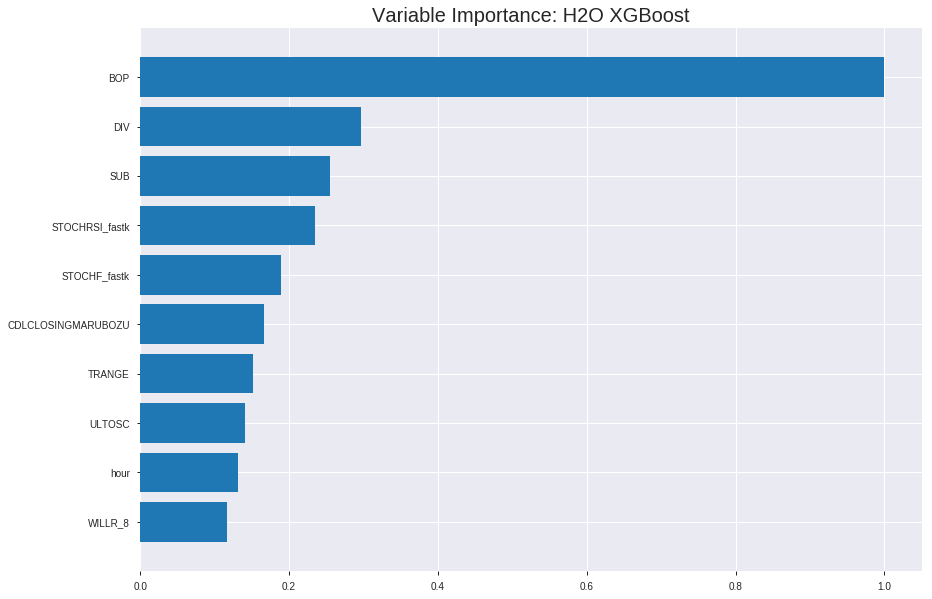

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_180243_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11776291808166928
RMSE: 0.34316602116420164
LogLoss: 0.3978221280449908
Mean Per-Class Error: 0.12785398314173202
AUC: 0.9512486718454367
pr_auc: 0.9536548833047507
Gini: 0.9024973436908734
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.449050173163414: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      656  133  0.1686   (133.0/789.0)
1      70   697  0.0913   (70.0/767.0)
Total  726  830  0.1305   (203.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44905      0.872887  221
max f2                       0.344092     0.914857  271
max f0point5                 0.612653     0.902342  145
max accuracy                 0.476353     0.872108  206
max precision                0.937332     1         0
max recall                   0.172939     1         361
max specificity              0.937332     1         0
max absolute_mcc             0.476353     0.744227  206
max min_per_class_accuracy   0.477895     0.870722  205
max mean_per_class_accuracy  0.476353     0.872146  206

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 49.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.906925           2.02868    2.02868            1                0.917782  1                           0.917782            0.0208605       0.0208605                  102.868   102.868
    2        0.0205656                   0.895999           2.02868    2.02868            1                0.901771  1                           0.909776            0.0208605       0.041721                   102.868   102.868
    3        0.0302057                   0.886351           2.02868    2.02868            1                0.890578  1                           0.903649            0.0195567       0.0612777                  102.868   102.868
    4        0.0404884                   0.880169           2.02868    2.02868            1                0.882905  1                           0.898381            0.0208605       0.0821382                  102.868   102.868
    5        0.0501285                   0.867048           2.02868    2.02868            1                0.874384  1                           0.893766            0.0195567       0.101695                   102.868   102.868
    6        0.100257                    0.827441           2.02868    2.02868            1                0.845495  1                           0.869631            0.101695        0.20339                    102.868   102.868
    7        0.150386                    0.786697           2.02868    2.02868            1                0.808517  1                           0.849259            0.101695        0.305085                   102.868   102.868
    8        0.200514                    0.751706           2.02868    2.02868            1                0.769018  1                           0.829199            0.101695        0.40678                    102.868   102.868
    9        0.300129                    0.672473           1.92398    1.99393            0.948387         0.71693   0.982869                    0.791936            0.191656        0.598435                   92.3977   99.3931
    10       0.400386                    0.581106           1.62555    1.90169            0.801282         0.6272    0.9374                      0.750686            0.162973        0.761408                   62.5547   90.1687
    11       0.5                         0.47342            1.15177    1.75228            0.567742         0.525138  0.863753                    0.705751            0.114733        0.876141                   15.1769   75.2282
    12       0.600257                    0.39063            0.74125    1.58342            0.365385         0.432991  0.780514                    0.660193            0.0743155       0.950456                   -25.875   58.3415
    13       0.699871                    0.312802           0.340295   1.40648            0.167742         0.352714  0.693297                    0.616429            0.0338983       0.984355                   -65.9705  40.6479
    14       0.800129                    0.240494           0.104035   1.24328            0.0512821        0.273749  0.612851                    0.573491            0.0104302       0.994785                   -89.5965  24.3281
    15       0.899743                    0.175586           0.0392648  1.10998            0.0193548        0.207225  0.547143                    0.53294             0.00391134      0.998696                   -96.0735  10.998
    16       1                           0.0721096          0.0130044  1                  0.00641026       0.135763  0.492931                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18901990505603153
RMSE: 0.43476419477232886
LogLoss: 0.5605554095882113
Mean Per-Class Error: 0.2671297434636506
AUC: 0.8055282353905419
pr_auc: 0.7344589222933137
Gini: 0.6110564707810837
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41738611459732056: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      132  117  0.4699   (117.0/249.0)
1      16   180  0.0816   (16.0/196.0)
Total  148  297  0.2989   (133.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417386     0.730223  268
max f2                       0.356852     0.847458  300
max f0point5                 0.702657     0.705521  104
max accuracy                 0.555048     0.730337  192
max precision                0.935749     1         0
max recall                   0.203398     1         367
max specificity              0.935749     1         0
max absolute_mcc             0.459763     0.473337  242
max min_per_class_accuracy   0.561425     0.722892  189
max mean_per_class_accuracy  0.459763     0.73287   242

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 53.12 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.89384            1.81633    1.81633            0.8              0.915663  0.8                         0.915663            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.874922           2.27041    2.01814            1                0.881664  0.888889                    0.900552            0.0204082       0.0408163                  127.041   101.814
    3        0.0314607                   0.869231           1.81633    1.94606            0.8              0.872737  0.857143                    0.890618            0.0204082       0.0612245                  81.6327   94.6064
    4        0.0404494                   0.858464           2.27041    2.01814            1                0.863181  0.888889                    0.884521            0.0204082       0.0816327                  127.041   101.814
    5        0.0516854                   0.848409           1.81633    1.97427            0.8              0.853447  0.869565                    0.877766            0.0204082       0.102041                   81.6327   97.4268
    6        0.101124                    0.812277           1.85761    1.91723            0.818182         0.827415  0.844444                    0.85315             0.0918367       0.193878                   85.7607   91.7234
    7        0.150562                    0.781236           1.85761    1.89765            0.818182         0.798579  0.835821                    0.835231            0.0918367       0.285714                   85.7607   89.7655
    8        0.2                         0.748387           1.75441    1.86224            0.772727         0.766404  0.820225                    0.818218            0.0867347       0.372449                   75.4406   86.2245
    9        0.301124                    0.680331           1.26134    1.66045            0.555556         0.708301  0.731343                    0.781305            0.127551        0.5                        26.1338   66.0448
    10       0.4                         0.618425           1.2384     1.55612            0.545455         0.649689  0.685393                    0.748771            0.122449        0.622449                   23.8404   55.6122
    11       0.501124                    0.530372           1.26134    1.49664            0.555556         0.573034  0.659193                    0.713308            0.127551        0.75                       26.1338   49.6637
    12       0.6                         0.461268           1.0836     1.42857            0.477273         0.498868  0.629213                    0.67797             0.107143        0.857143                   8.36039   42.8571
    13       0.698876                    0.396229           0.825603   1.34326            0.363636         0.431304  0.59164                     0.643072            0.0816327       0.938776                   -17.4397  34.3264
    14       0.8                         0.324383           0.302721   1.21173            0.133333         0.358905  0.533708                    0.607152            0.0306122       0.969388                   -69.7279  21.1735
    15       0.898876                    0.227537           0.258001   1.10682            0.113636         0.277266  0.4875                      0.570864            0.0255102       0.994898                   -74.1999  10.6824
    16       1                           0.0902403          0.0504535  1                  0.0222222        0.178985  0.440449                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:03:04  5.986 sec   0                  0.5              0.693147            0.5             0                  1                0.507069                         0.5                0.693147              0.5               0                    1                  0.559551
    2019-08-26 18:03:05  6.573 sec   5                  0.474189         0.642579            0.846388        0.840802           2.02868          0.228792                         0.484667           0.662826              0.763626          0.69956              2.27041            0.305618
    2019-08-26 18:03:05  6.823 sec   10                 0.450626         0.597689            0.874825        0.87313            2.02868          0.225578                         0.467678           0.629772              0.794904          0.733244             2.27041            0.283146
    2019-08-26 18:03:05  7.086 sec   15                 0.434725         0.567661            0.885956        0.889222           2.02868          0.203085                         0.457411           0.609646              0.800119          0.739615             2.27041            0.276404
    2019-08-26 18:03:05  7.346 sec   20                 0.416696         0.533493            0.893682        0.898807           2.02868          0.210797                         0.445969           0.586841              0.806317          0.751481             2.27041            0.292135
    2019-08-26 18:03:06  7.614 sec   25                 0.402813         0.50708             0.901973        0.905609           2.02868          0.199229                         0.435683           0.566133              0.816306          0.762848             2.27041            0.269663
    2019-08-26 18:03:06  7.889 sec   30                 0.391528         0.485615            0.909378        0.916              2.02868          0.18509                          0.432343           0.559046              0.815866          0.754415             2.27041            0.253933
    2019-08-26 18:03:06  8.157 sec   35                 0.385027         0.473485            0.915764        0.921718           2.02868          0.176093                         0.433296           0.560335              0.815486          0.752974             2.27041            0.278652
    2019-08-26 18:03:07  8.439 sec   40                 0.376635         0.458033            0.92374         0.927494           2.02868          0.172237                         0.431873           0.557025              0.814462          0.744306             2.27041            0.269663
    2019-08-26 18:03:07  8.799 sec   45                 0.36778          0.44147             0.931039        0.935361           2.02868          0.159383                         0.430675           0.553758              0.815271          0.74958              2.27041            0.274157
    2019-08-26 18:03:07  9.267 sec   50                 0.362001         0.431105            0.936932        0.938794           2.02868          0.151028                         0.430481           0.552983              0.81478           0.743997             1.81633            0.276404
    2019-08-26 18:03:08  9.588 sec   55                 0.356337         0.420819            0.941304        0.944525           2.02868          0.150386                         0.430619           0.552798              0.812894          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1136.575927734375      1.0                     0.13535761641491484
DIV                      336.4729919433594      0.29604092760795764     0.040071394322273496
SUB                      289.3315124511719      0.25456417419284855     0.034457199843375155
STOCHRSI_fastk           267.3248596191406      0.235201936884252       0.03183637355282359
STOCHF_fastk             215.3399200439453      0.18946373470463965     0.0256453595266878
---                      ---                    ---                     ---
LINEARREG_ANGLE_12       1.1916999816894531     0.0010485001068648015   0.00014192247527600302
BBANDS_lowerband_20_6_2  0.981201171875         0.0008632957534398114   0.0001168536554467309
PLUS_DM_24               0.6607732772827148     0.0005813718742045553   7.869311114300032e-05
MAVP_8_3                 0.3007011413574219     0.00026456757883024394  3.58112368511269e-05
BBANDS_upperband_20_3_5  0.0711202621459961     6.257414081236581e-05   8.469886549573079e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7488789237668162)

('F1', 0.7149321266968326)

('auc', 0.7872977346278317)

('logloss', 0.5746812538805378)

('mean_per_class_error', 0.2567152103559871)

('rmse', 0.44153148418307575)

('mse', 0.19495005152490966)

xgboost prediction progress: |████████████████████████████████████████████| 100%


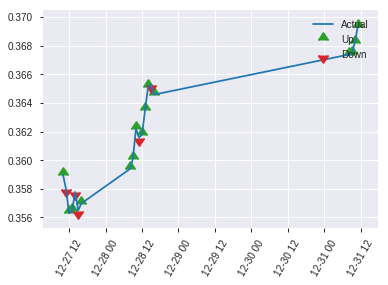


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19495005152490966
RMSE: 0.44153148418307575
LogLoss: 0.5746812538805378
Mean Per-Class Error: 0.2567152103559871
AUC: 0.7872977346278317
pr_auc: 0.7242412609360793
Gini: 0.5745954692556634
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5176438689231873: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   39   0.325    (39.0/120.0)
1      24   79   0.233    (24.0/103.0)
Total  105  118  0.2825   (63.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.517644     0.714932  117
max f2                       0.334359     0.846024  178
max f0point5                 0.638022     0.742794  86
max accuracy                 0.638022     0.748879  86
max precision                0.899848     1         0
max recall                   0.180796     1         214
max specificity              0.899848     1         0
max absolute_mcc             0.638022     0.494496  86
max min_per_class_accuracy   0.568085     0.718447  105
max mean_per_class_accuracy  0.632626     0.743285  90

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 54.01 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.89309            1.44337    1.44337            0.666667         0.896745  0.666667                    0.896745            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.884148           2.16505    1.73204            1                0.890388  0.8                         0.894202            0.0194175       0.038835                   116.505   73.2039
    3        0.0313901                   0.877506           2.16505    1.85576            1                0.878798  0.857143                    0.889801            0.0194175       0.0582524                  116.505   85.5756
    4        0.0403587                   0.872124           2.16505    1.92449            1                0.875663  0.888889                    0.886659            0.0194175       0.0776699                  116.505   92.4488
    5        0.0538117                   0.861652           1.44337    1.80421            0.666667         0.866165  0.833333                    0.881536            0.0194175       0.0970874                  44.3366   80.4207
    6        0.103139                    0.823552           1.57458    1.69439            0.727273         0.844739  0.782609                    0.863937            0.0776699       0.174757                   57.4581   69.4386
    7        0.152466                    0.788006           1.57458    1.65563            0.727273         0.802938  0.764706                    0.844202            0.0776699       0.252427                   57.4581   65.5625
    8        0.201794                    0.748769           1.96823    1.73204            0.909091         0.773     0.8                         0.826797            0.0970874       0.349515                   96.8226   73.2039
    9        0.300448                    0.678119           1.67299    1.71265            0.772727         0.713237  0.791045                    0.789509            0.165049        0.514563                   67.2992   71.265
    10       0.399103                    0.633043           1.47617    1.65419            0.681818         0.657382  0.764045                    0.756848            0.145631        0.660194                   47.6169   65.4194
    11       0.502242                    0.534126           0.658928   1.44981            0.304348         0.594683  0.669643                    0.723546            0.0679612       0.728155                   -34.1072  44.9809
    12       0.600897                    0.462834           0.688879   1.32488            0.318182         0.501031  0.61194                     0.687014            0.0679612       0.796117                   -31.1121  32.488
    13       0.699552                    0.407529           0.885702   1.26294            0.409091         0.435198  0.583333                    0.651502            0.0873786       0.883495                   -11.4298  26.2945
    14       0.798206                    0.335042           0.78729    1.20416            0.363636         0.37027   0.55618                     0.616743            0.0776699       0.961165                   -21.271   20.4156
    15       0.896861                    0.235565           0.295234   1.10417            0.136364         0.283816  0.51                        0.580121            0.0291262       0.990291                   -70.4766  10.4175
    16       1                           0.14856            0.0941325  1                  0.0434783        0.192119  0.461883                    0

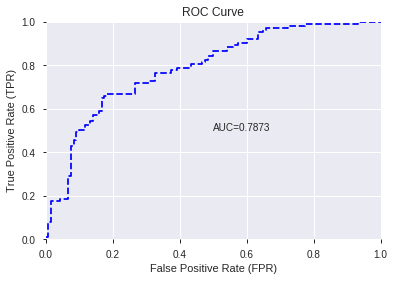

This function is available for GLM models only


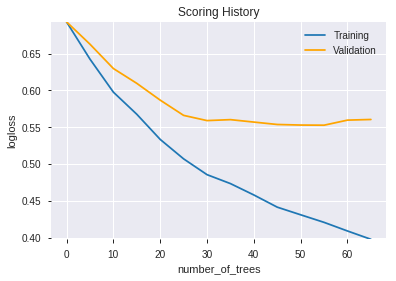

--2019-08-26 18:03:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_180243_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_180243_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_180339_model_2  0.749757  0.678609              0.297168  0.464236  0.215516
1  DeepLearning_grid_1_AutoML_20190826_180339_model_3  0.741343  0.696531              0.367314  0.463808  0.215118
2  DeepLearning_grid_1_AutoML_20190826_180339_model_7  0.740291  0.713863              0.343689  0.475975  0.226552
3  DeepLearning_grid_1_AutoML_20190826_180339_model_4  0.737621  0.687673              0.337379  0.475986  0.226563
4  DeepLearning_grid_1_AutoML_20190826_180339_model_6  0.736812  0.626717              0.366626  0.462191  0.213620
5  DeepLearning_grid_1_AutoML_20190826_180339_model_9  0.735437  0.600346              0.368002  0.455228  0.207232
6  DeepLearning_grid_1_AutoML_20190826_180339_model_8  0.734709  0.620416              0.339563  0.459233  0.210895
7  DeepLearning_grid_1_AutoML_20190826_180339_model_5  0.728155  0.610931              0.371521  0.460150  0.211738
8               DeepLearning_1_AutoML_20190826_180339  0.726861  0.623540              0.331189  0.460918  0.212445
9  DeepLearning_grid_1_AutoML_20190826_180339_model_1  0.671926  1.057455              0.374879  0.516458  0.266729

variable  relative_importance  scaled_importance  percentage
0    CDLIDENTICAL3CROWS             1.000000           1.000000    0.044289
1    CDLMORNINGDOJISTAR             0.695309           0.695309    0.030794
2        STOCHRSI_fastk             0.675046           0.675046    0.029897
3       CDLHOMINGPIGEON             0.629777           0.629777    0.027892
4                   BOP             0.627173           0.627173    0.027777
5     CDL3WHITESOLDIERS             0.619520           0.619520    0.027438
6   CDLCONCEALBABYSWALL             0.611139           0.611139    0.027067
7   CDLRISEFALL3METHODS             0.610551           0.610551    0.027041
8   CDLGAPSIDESIDEWHITE             0.608533           0.608533    0.026951
9                ULTOSC             0.601610           0.601610    0.026645
10            CDL2CROWS             0.600699           0.600699    0.026604
11         STOCHF_fastk             0.596212           0.596212    0.026405
12         CDLTASUKIGAP             0.582501           0.582501    0.025798
13            CDLONNECK             0.561821           0.561821    0.024882
14                ADOSC             0.532077           0.532077    0.023565
15         CDLTHRUSTING             0.519602           0.519602    0.023013
16            CORREL_30             0.513890           0.513890    0.022760
17   CDLEVENINGDOJISTAR             0.512872           0.512872    0.022714
18       CDLEVENINGSTAR             0.504432           0.504432    0.022341
19    CDLSTALLEDPATTERN             0.495329           0.495329    0.021937
20      CDLLADDERBOTTOM             0.495041           0.495041    0.021925
21       CDL3LINESTRIKE             0.491340           0.491340    0.021761
22               Volume             0.482170           0.482170    0.021355
23          CDLPIERCING             0.476874           0.476874    0.021120
24       CDLMORNINGSTAR             0.466654           0.466654    0.020668
25    CDLDARKCLOUDCOVER             0.466020           0.466020    0.020639
26        CDLHIKKAKEMOD             0.452935           0.452935    0.020060
27              CDLDOJI             0.452214           0.452214    0.020028
28               TRANGE             0.391403           0.391403    0.017335
29         CDLSHORTLINE             0.384603           0.384603    0.017034
30  CDLXSIDEGAP3METHODS             0.373592           0.373592    0.016546
31                  SUB             0.368967           0.368967    0.016341
32            CDLTAKURI             0.352676           0.352676    0.015620
33          CDLLONGLINE             0.349013           0.349013    0.015457
34       is_month_start             0.348789           0.348789    0.015447
35                  DIV             0.347342           0.347342    0.015383
36     CDLDRAGONFLYDOJI             0.345788           0.345788    0.015315
37   CDLCLOSINGMARUBOZU             0.331040           0.331040    0.014661
38   CDLSEPARATINGLINES             0.315588           0.315588    0.013977
39             CORREL_8             0.298936           0.298936    0.013240
40        CDLHANGINGMAN             0.286843           0.286843    0.012704
41    CDLINVERTEDHAMMER             0.260963           0.260963    0.011558
42      CDLADVANCEBLOCK             0.257755           0.257755    0.011416
43          CDLMARUBOZU             0.254648           0.254648    0.011278
44         is_month_end             0.253109           0.253109    0.011210
45            CDLHAMMER             0.246493           0.246493    0.010917
46      CDLSHOOTINGSTAR             0.238755           0.238755    0.010574
47           CDL3INSIDE             0.236574           0.236574    0.010478
48    CDLGRAVESTONEDOJI             0.235172           0.235172    0.010415
49       CDLMATCHINGLOW             0.219722           0.219722    0.009731

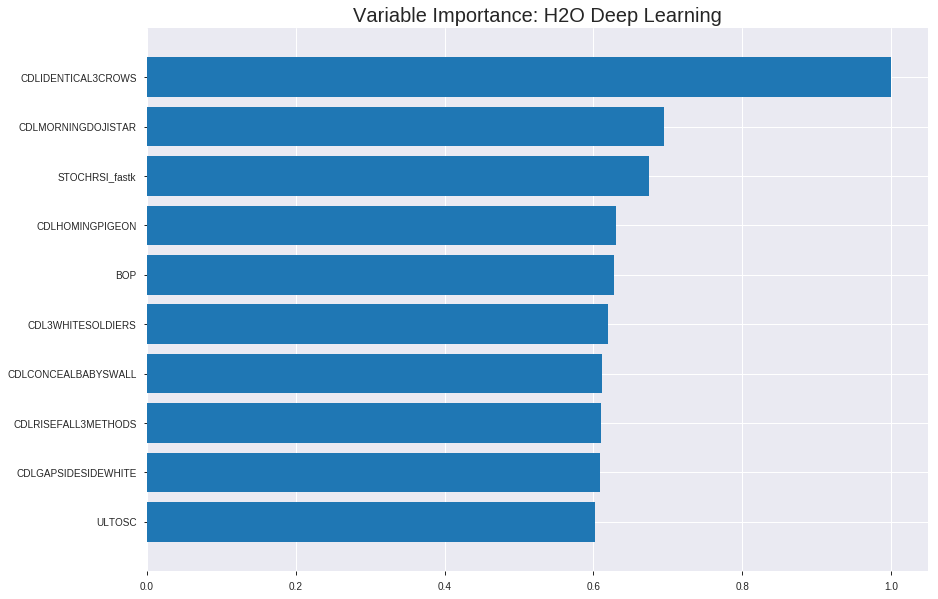

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_180339_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17950070421712436
RMSE: 0.4236752343684067
LogLoss: 0.5537208898176419
Mean Per-Class Error: 0.25905582462906684
AUC: 0.8081558191759906
pr_auc: 0.7530071057900709
Gini: 0.6163116383519811
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3760359303934016: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      498  291  0.3688   (291.0/789.0)
1      129  638  0.1682   (129.0/767.0)
Total  627  929  0.2699   (420.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376036     0.752358  245
max f2                       0.186535     0.848409  331
max f0point5                 0.572241     0.743707  159
max accuracy                 0.425263     0.74036   225
max precision                0.921754     0.927419  26
max recall                   0.000140178  1         399
max specificity              0.99974      0.996198  0
max absolute_mcc             0.425263     0.483232  225
max min_per_class_accuracy   0.462211     0.73384   208
max mean_per_class_accuracy  0.425263     0.740944  225

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 48.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.999907           1.90189   1.90189            0.9375           0.99997    0.9375                      0.99997             0.0195567       0.0195567                  90.189    90.189
    2        0.0205656                   0.999493           1.7751    1.83849            0.875            0.999649   0.90625                     0.99981             0.0182529       0.0378096                  77.5098   83.8494
    3        0.0302057                   0.997756           1.75819   1.81287            0.866667         0.998898   0.893617                    0.999519            0.0169492       0.0547588                  75.8192   81.2866
    4        0.0404884                   0.988284           1.7751    1.80327            0.875            0.995227   0.888889                    0.998429            0.0182529       0.0730117                  77.5098   80.3274
    5        0.0501285                   0.969937           2.02868   1.84662            1                0.979619   0.910256                    0.994811            0.0195567       0.0925684                  102.868   84.6622
    6        0.100257                    0.889833           1.7946    1.82061            0.884615         0.930652   0.897436                    0.962732            0.0899609       0.182529                   79.4604   82.0613
    7        0.150386                    0.826704           1.7686    1.80327            0.871795         0.851549   0.888889                    0.925671            0.0886571       0.271186                   76.8596   80.3274
    8        0.200514                    0.776725           1.63855   1.76209            0.807692         0.800344   0.86859                     0.894339            0.0821382       0.353325                   63.8552   76.2093
    9        0.300129                    0.643431           1.43971   1.65509            0.709677         0.705777   0.815846                    0.831754            0.143416        0.496741                   43.9711   65.5093
    10       0.400386                    0.538609           1.22241   1.54675            0.602564         0.589617   0.76244                     0.771123            0.122555        0.619296                   22.2412   54.6749
    11       0.5                         0.460593           1.20412   1.47849            0.593548         0.497911   0.728792                    0.716691            0.119948        0.739244                   20.4122   47.8488
    12       0.600257                    0.371543           0.936315  1.38793            0.461538         0.412751   0.684154                    0.665926            0.0938722       0.833116                   -6.36847  38.7932
    13       0.699871                    0.303485           0.588973  1.27421            0.290323         0.334561   0.628099                    0.618762            0.0586701       0.891786                   -41.1027  27.4214
    14       0.800129                    0.21836            0.53318   1.18136            0.262821         0.261243   0.582329                    0.573965            0.053455        0.945241                   -46.682   18.1362
    15       0.899743                    0.117206           0.353384  1.08969            0.174194         0.168947   0.537143                    0.529123            0.0352021       0.980443                   -64.6616  8.96927
    16       1                           4.13639e-09        0.195066  1                  0.0961538        0.0544431  0.492931                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19970107511520524
RMSE: 0.44687926234633585
LogLoss: 0.6634653972092666
Mean Per-Class Error: 0.2970965494631588
AUC: 0.7587390377837882
pr_auc: 0.6901767345803824
Gini: 0.5174780755675763
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37794675599330163: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      150  99   0.3976   (99.0/249.0)
1      41   155  0.2092   (41.0/196.0)
Total  191  254  0.3146   (140.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377947     0.688889  226
max f2                       0.0820048    0.806856  372
max f0point5                 0.605101     0.68118   115
max accuracy                 0.605101     0.705618  115
max precision                0.779165     0.847222  64
max recall                   0.00407519   1         396
max specificity              0.999981     0.995984  0
max absolute_mcc             0.471168     0.403556  185
max min_per_class_accuracy   0.471168     0.69898   185
max mean_per_class_accuracy  0.471168     0.702903  185

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 45.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.998205           1.81633   1.81633            0.8              0.999296   0.8                         0.999296            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.985534           1.1352    1.51361            0.5              0.993229   0.666667                    0.996599            0.0102041       0.0306122                  13.5204   51.3605
    3        0.0314607                   0.970346           1.81633   1.62172            0.8              0.978078   0.714286                    0.989985            0.0204082       0.0510204                  81.6327   62.172
    4        0.0404494                   0.963844           2.27041   1.76587            1                0.966971   0.777778                    0.98487             0.0204082       0.0714286                  127.041   76.5873
    5        0.0516854                   0.933397           1.81633   1.77684            0.8              0.947221   0.782609                    0.976686            0.0204082       0.0918367                  81.6327   77.6841
    6        0.101124                    0.861696           1.85761   1.81633            0.818182         0.894846   0.8                         0.936675            0.0918367       0.183673                   85.7607   81.6327
    7        0.150562                    0.784566           2.06401   1.89765            0.909091         0.820798   0.835821                    0.898626            0.102041        0.285714                   106.401   89.7655
    8        0.2                         0.729589           1.65121   1.83673            0.727273         0.759022   0.808989                    0.864117            0.0816327       0.367347                   65.1206   83.6735
    9        0.301124                    0.600577           1.31179   1.66045            0.577778         0.65264    0.731343                    0.793098            0.132653        0.5                        31.1791   66.0448
    10       0.4                         0.517426           1.1868    1.54337            0.522727         0.554535   0.679775                    0.734128            0.117347        0.617347                   18.6804   54.3367
    11       0.501124                    0.42823            1.00907   1.43555            0.444444         0.479008   0.632287                    0.682646            0.102041        0.719388                   0.907029  43.555
    12       0.6                         0.360436           0.877203  1.34354            0.386364         0.393171   0.59176                     0.634942            0.0867347       0.806122                   -12.2797  34.3537
    13       0.698876                    0.29259            0.567602  1.23376            0.25             0.322511   0.543408                    0.59074             0.0561224       0.862245                   -43.2398  23.3759
    14       0.8                         0.203263           0.655896  1.16071            0.288889         0.247497   0.511236                    0.547352            0.0663265       0.928571                   -34.4104  16.0714
    15       0.898876                    0.105655           0.309601  1.06709            0.136364         0.152716   0.47                        0.503942            0.0306122       0.959184                   -69.0399  6.70918
    16       1                           3.09038e-07        0.403628  1                  0.177778         0.0528322  0.440449                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:04:26  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 18:04:28  48.351 sec        5867 obs/sec      10        1             15560      0.433035         0.610681            0.249773       0.79156         0.709571           1.7751           0.285347                         0.447166           0.724829              0.18866          0.761065          0.668096             1.36224            0.321348
    2019-08-26 18:04:35  54.419 sec        7196 obs/sec      40        4             62240      0.423675         0.553721            0.281854       0.808156        0.753007           1.90189          0.269923                         0.446879           0.663465              0.189702         0.758739          0.690177             1.81633            0.314607
    2019-08-26 18:04:41  1 min  0.805 sec  8318 obs/sec      80        8             124480     0.418582         0.557252            0.299015       0.818263        0.740281           1.90189          0.266067                         0.453365           0.710556              0.16601          0.755153          0.678458             1.81633            0.314607
    2019-08-26 18:04:47  1 min  6.472 sec  9080 obs/sec      120       12            186720     0.411842         0.532024            0.321408       0.828854        0.764578           1.90189          0.251928                         0.456025           0.71529               0.156194         0.752592          0.661691             1.81633            0.350562
    2019-08-26 18:04:52  1 min 11.798 sec  9642 obs/sec      160       16            248960     0.403953         0.509602            0.347158       0.841771        0.806842           2.02868          0.224936                         0.451301           0.670978              0.173585         0.750502          0.696087             1.36224            0.314607
    2019-08-26 18:04:57  1 min 17.019 sec  10060 obs/sec     200       20            311200     0.40103          0.496287            0.35657        0.846876        0.802828           2.02868          0.237147                         0.456941           0.72173               0.152803         0.743085          0.686413             1.36224            0.341573
    2019-08-26 18:04:57  1 min 17.096 sec  10058 obs/sec     200       20            311200     0.423675         0.553721            0.281854       0.808156        0.753007           1.90189          0.269923                         0.446879           0.663465              0.189702         0.758739          0.690177             1.81633            0.314607

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLIDENTICAL3CROWS  1.0                    1.0                  0.04428871710911316
CDLMORNINGDOJISTAR  0.6953094005584717     0.6953094005584717   0.0307943613446412
STOCHRSI_fastk      0.6750460863113403     0.6750460863113403   0.029896925152256938
CDLHOMINGPIGEON     0.6297768950462341     0.6297768950462341   0.027892010746558313
BOP                 0.6271733641624451     0.6271733641624451   0.02777670370376134
---                 ---                    ---                  ---
CDLHAMMER           0.2464931458234787     0.2464931458234787   0.010916865204711426
CDLSHOOTINGSTAR     0.23875509202480316    0.23875509202480316  0.010574156729046788
CDL3INSIDE          0.23657403886318207    0.23657403886318207  0.010477560682571814
CDLGRAVESTONEDOJI   0.23517152667045593    0.23517152667045593  0.010415445216826084
CDLMATCHINGLOW      0.21972177922725677    0.21972177922725677  0.009731195722906991


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7040358744394619)

('F1', 0.7307692307692307)

('auc', 0.749757281553398)

('logloss', 0.6786086272687121)

('mean_per_class_error', 0.2853155339805826)

('rmse', 0.4642364903829475)

('mse', 0.2155155190030765)

deeplearning prediction progress: |███████████████████████████████████████| 100%


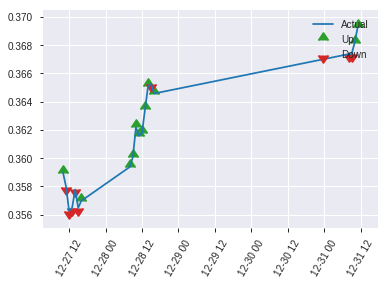


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2155155190030765
RMSE: 0.4642364903829475
LogLoss: 0.6786086272687121
Mean Per-Class Error: 0.2853155339805826
AUC: 0.749757281553398
pr_auc: 0.6639098867640322
Gini: 0.4995145631067961
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22470565291326705: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   62   0.5167   (62.0/120.0)
1      8    95   0.0777   (8.0/103.0)
Total  66   157  0.3139   (70.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.224706     0.730769  156
max f2                       0.21266      0.837696  160
max f0point5                 0.366418     0.675676  112
max accuracy                 0.366418     0.704036  112
max precision                1            1         0
max recall                   0.0196729    1         214
max specificity              1            1         0
max absolute_mcc             0.224706     0.443051  156
max min_per_class_accuracy   0.383724     0.683333  108
max mean_per_class_accuracy  0.254407     0.714684  138

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 42.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.99939            1.44337   1.44337            0.666667         0.999812   0.666667                    0.999812            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.998115           1.08252   1.29903            0.5              0.998644   0.6                         0.999345            0.00970874      0.0291262                  8.25243   29.9029
    3        0.0313901                   0.995537           2.16505   1.54646            1                0.997761   0.714286                    0.998892            0.0194175       0.0485437                  116.505   54.6463
    4        0.0403587                   0.972013           1.08252   1.44337            0.5              0.984087   0.666667                    0.995602            0.00970874      0.0582524                  8.25243   44.3366
    5        0.0538117                   0.955924           1.44337   1.44337            0.666667         0.964082   0.666667                    0.987722            0.0194175       0.0776699                  44.3366   44.3366
    6        0.103139                    0.841995           1.96823   1.69439            0.909091         0.909026   0.782609                    0.950085            0.0970874       0.174757                   96.8226   69.4386
    7        0.152466                    0.781025           1.57458   1.65563            0.727273         0.806815   0.764706                    0.903733            0.0776699       0.252427                   57.4581   65.5625
    8        0.201794                    0.721977           1.57458   1.63581            0.727273         0.748471   0.755556                    0.86578             0.0776699       0.330097                   57.4581   63.5814
    9        0.300448                    0.58652            0.984113  1.42182            0.454545         0.644186   0.656716                    0.793018            0.0970874       0.427184                   -1.5887   42.1823
    10       0.399103                    0.447346           1.27935   1.3866             0.590909         0.51811    0.640449                    0.725063            0.126214        0.553398                   27.9347   38.6604
    11       0.502242                    0.373213           1.60025   1.43048            0.73913          0.410109   0.660714                    0.660385            0.165049        0.718447                   60.0253   43.0479
    12       0.600897                    0.271619           0.984113  1.35719            0.454545         0.316246   0.626866                    0.603884            0.0970874       0.815534                   -1.5887   35.7195
    13       0.699552                    0.22481            0.984113  1.30458            0.454545         0.243061   0.602564                    0.552999            0.0970874       0.912621                   -1.5887   30.4581
    14       0.798206                    0.144802           0.295234  1.17983            0.136364         0.194884   0.544944                    0.508738            0.0291262       0.941748                   -70.4766  17.983
    15       0.896861                    0.0736407          0.393645  1.09335            0.181818         0.10895    0.505                       0.464761            0.038835        0.980583                   -60.6355  9.33495
    16       1                           0.000123592        0.188265  1                  0.0869565        0.0329241  0.461883                    

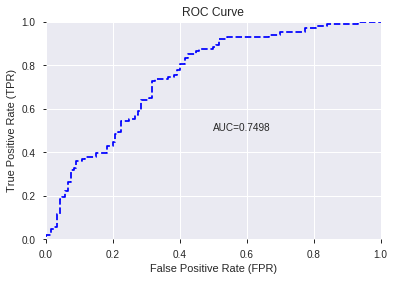

This function is available for GLM models only


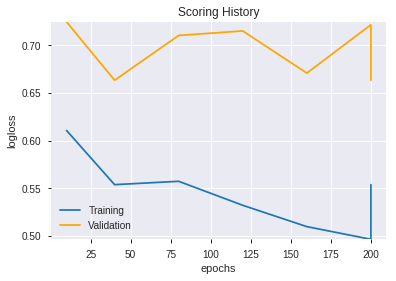

--2019-08-26 18:11:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_180339_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_180339_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLIDENTICAL3CROWS',
 'CDLMORNINGDOJISTAR',
 'STOCHRSI_fastk',
 'CDLHOMINGPIGEON',
 'BOP',
 'CDL3WHITESOLDIERS',
 'CDLCONCEALBABYSWALL',
 'CDLRISEFALL3METHODS',
 'CDLGAPSIDESIDEWHITE',
 'ULTOSC',
 'CDL2CROWS',
 'STOCHF_fastk',
 'CDLTASUKIGAP',
 'CDLONNECK',
 'ADOSC',
 'CDLTHRUSTING',
 'CORREL_30',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLLADDERBOTTOM',
 'CDL3LINESTRIKE',
 'Volume',
 'CDLPIERCING',
 'CDLMORNINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLHIKKAKEMOD',
 'CDLDOJI',
 'TRANGE',
 'CDLSHORTLINE',
 'CDLXSIDEGAP3METHODS',
 'SUB',
 'CDLTAKURI',
 'CDLLONGLINE',
 'is_month_start',
 'DIV',
 'CDLDRAGONFLYDOJI',
 'CDLCLOSINGMARUBOZU',
 'CDLSEPARATINGLINES',
 'CORREL_8',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLADVANCEBLOCK',
 'CDLMARUBOZU',
 'is_month_end',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR',
 'CDL3INSIDE',
 'CDLGRAVESTONEDOJI',
 'CDLMATCHINGLOW']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_181204_model_1  0.727104  0.604208              0.379126  0.457823  0.209602

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.633125           1.000000    0.144266
1    CDLCLOSINGMARUBOZU             0.316761           0.500314    0.072179
2                TRANGE             0.225496           0.356164    0.051382
3    CDLIDENTICAL3CROWS             0.170223           0.268863    0.038788
4           CDLLONGLINE             0.169451           0.267642    0.038612
5                   SUB             0.164280           0.259474    0.037433
6             CDLTAKURI             0.156954           0.247903    0.035764
7        CDL3LINESTRIKE             0.133964           0.211592    0.030526
8          CDLSHORTLINE             0.117954           0.186304    0.026877
9   CDLXSIDEGAP3METHODS             0.116946           0.184712    0.026648
10          CDLMARUBOZU             0.112622           0.177882    0.025662
11            CDLHAMMER             0.106774           0.168647    0.024330
12  CDLRISEFALL3METHODS             0.096338           0.152163    0.021952
13  CDLCONCEALBABYSWALL             0.095843           0.151381    0.021839
14   CDLEVENINGDOJISTAR             0.093454           0.147608    0.021295
15   CDLSEPARATINGLINES             0.092784           0.146550    0.021142
16      CDLHOMINGPIGEON             0.091285           0.144181    0.020800
17    CDLINVERTEDHAMMER             0.086944           0.137325    0.019811
18        CDLHANGINGMAN             0.086644           0.136852    0.019743
19       CDLMORNINGSTAR             0.085124           0.134451    0.019397
20        CDLHIKKAKEMOD             0.082644           0.130534    0.018832
21            CDL2CROWS             0.081886           0.129336    0.018659
22           CDL3INSIDE             0.079211           0.125111    0.018049
23         CDLTASUKIGAP             0.077354           0.122178    0.017626
24     CDLDRAGONFLYDOJI             0.068912           0.108845    0.015703
25    CDLSTALLEDPATTERN             0.064128           0.101288    0.014612
26    CDLGRAVESTONEDOJI             0.061549           0.097215    0.014025
27                  DIV             0.058350           0.092162    0.013296
28               ULTOSC             0.056069           0.088560    0.012776
29             CORREL_8             0.049739           0.078562    0.011334
30    CDL3WHITESOLDIERS             0.047874           0.075615    0.010909
31   CDLMORNINGDOJISTAR             0.046614           0.073625    0.010622
32       is_month_start             0.046141           0.072878    0.010514
33       CDLEVENINGSTAR             0.045842           0.072406    0.010446
34              CDLDOJI             0.040871           0.064555    0.009313
35       STOCHRSI_fastk             0.039501           0.062390    0.009001
36      CDLLADDERBOTTOM             0.038600           0.060967    0.008795
37                ADOSC             0.034619           0.054679    0.007888
38    CDLDARKCLOUDCOVER             0.032325           0.051056    0.007366
39               Volume             0.028350           0.044778    0.006460
40            CORREL_30             0.027671           0.043705    0.006305
41      CDLSHOOTINGSTAR             0.025650           0.040514    0.005845
42      CDLADVANCEBLOCK             0.024863           0.039271    0.005665
43       CDLMATCHINGLOW             0.020863           0.032952    0.004754
44          CDLPIERCING             0.016356           0.025834    0.003727
45         STOCHF_fastk             0.013330           0.021054    0.003037
46         is_month_end             0.011301           0.017850    0.002575
47         CDLTHRUSTING             0.008070           0.012747    0.001839
48            CDLONNECK             0.004466           0.007053    0.001018
49  CDLGAPSIDESIDEWHITE             0.002466           0.003895    0.000562

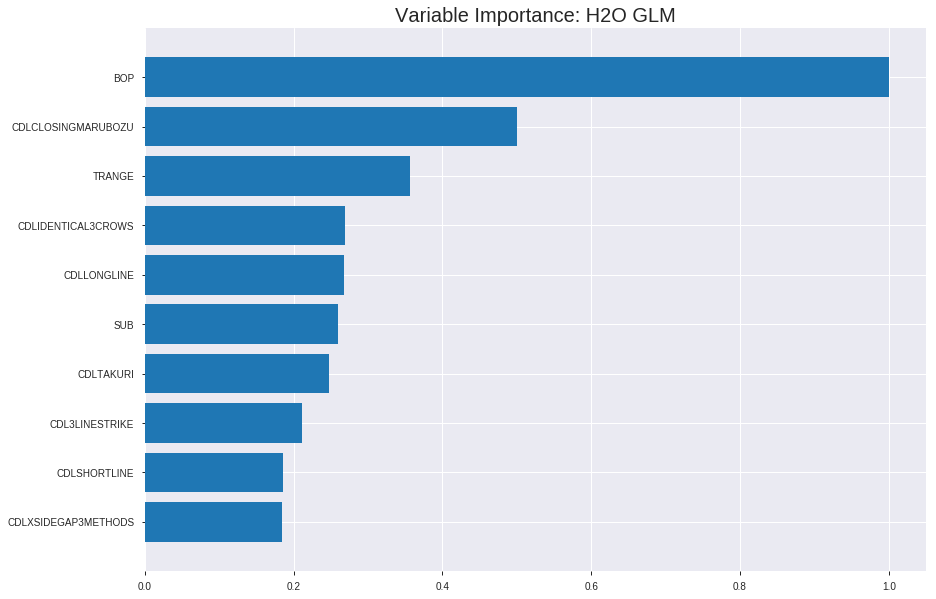

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_181204_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19090317261547393
RMSE: 0.4369246761347703
LogLoss: 0.5630281945344466
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2156.7629615535493
Residual deviance: 1752.143741391198
AIC: 1854.143741391198
AUC: 0.7811201279655234
pr_auc: 0.7774340520813915
Gini: 0.5622402559310469
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43004216544633045: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      476  313  0.3967   (313.0/789.0)
1      152  615  0.1982   (152.0/767.0)
Total  628  928  0.2988   (465.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430042     0.725664  231
max f2                       0.226996     0.838644  325
max f0point5                 0.548555     0.729013  171
max accuracy                 0.548555     0.72108   171
max precision                0.981661     1         0
max recall                   0.0690773    1         383
max specificity              0.981661     1         0
max absolute_mcc             0.548555     0.445424  171
max min_per_class_accuracy   0.493645     0.706649  197
max mean_per_class_accuracy  0.548555     0.720024  171

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 49.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.933196           2.02868   2.02868            1                0.957216   1                           0.957216            0.0208605       0.0208605                  102.868   102.868
    2        0.0205656                   0.915078           1.7751    1.90189            0.875            0.923806   0.9375                      0.940511            0.0182529       0.0391134                  77.5098   90.189
    3        0.0302057                   0.90037            2.02868   1.94236            1                0.909074   0.957447                    0.930478            0.0195567       0.0586701                  102.868   94.2356
    4        0.0404884                   0.886199           1.90189   1.93208            0.9375           0.894884   0.952381                    0.921438            0.0195567       0.0782269                  90.189    93.2079
    5        0.0501285                   0.872671           1.75819   1.89864            0.866667         0.880206   0.935897                    0.913509            0.0169492       0.095176                   75.8192   89.8639
    6        0.100257                    0.814612           1.82061   1.85963            0.897436         0.841675   0.916667                    0.877592            0.0912647       0.186441                   82.0613   85.9626
    7        0.150386                    0.773322           1.63855   1.78593            0.807692         0.791788   0.880342                    0.84899             0.0821382       0.268579                   63.8552   78.5935
    8        0.200514                    0.71229            1.58653   1.73608            0.782051         0.742779   0.855769                    0.822437            0.0795306       0.34811                    58.6534   73.6085
    9        0.300129                    0.633567           1.42662   1.63337            0.703226         0.672125   0.805139                    0.772548            0.142112        0.490222                   42.6622   63.3372
    10       0.400386                    0.564853           1.27443   1.54349            0.628205         0.597974   0.760835                    0.728834            0.127771        0.617992                   27.4429   54.3493
    11       0.5                         0.49061            0.929268  1.42112            0.458065         0.525704   0.700514                    0.688365            0.0925684       0.710561                   -7.07322  42.1121
    12       0.600257                    0.427101           0.936315  1.34015            0.461538         0.45934    0.6606                      0.650112            0.0938722       0.804433                   -6.36847  34.0147
    13       0.699871                    0.353209           0.615149  1.23696            0.303226         0.390654   0.609734                    0.613183            0.0612777       0.865711                   -38.4851  23.6957
    14       0.800129                    0.276035           0.62421   1.16018            0.307692         0.313817   0.571888                    0.575672            0.0625815       0.928292                   -37.579   16.0179
    15       0.899743                    0.163093           0.405737  1.07665            0.2              0.223854   0.530714                    0.536721            0.0404172       0.968709                   -59.4263  7.66511
    16       1                           0.0018551          0.312105  1                  0.153846         0.0999412  0.492931                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1903989817346087
RMSE: 0.43634731778092634
LogLoss: 0.5600829969474249
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 615.4911432999108
Residual deviance: 498.4738672832082
AIC: 600.4738672832082
AUC: 0.7779895090566348
pr_auc: 0.7211814458180594
Gini: 0.5559790181132696
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42351399748464735: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      147  102  0.4096   (102.0/249.0)
1      40   156  0.2041   (40.0/196.0)
Total  187  258  0.3191   (142.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423514     0.687225  230
max f2                       0.222917     0.83118   335
max f0point5                 0.578546     0.694444  139
max accuracy                 0.578546     0.719101  139
max precision                0.840799     0.909091  21
max recall                   0.140752     1         361
max specificity              0.955837     0.995984  0
max absolute_mcc             0.578546     0.425611  139
max min_per_class_accuracy   0.49263      0.709184  189
max mean_per_class_accuracy  0.49263      0.712022  189

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 46.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.905545           1.36224   1.36224            0.6              0.931284   0.6                         0.931284            0.0153061       0.0153061                  36.2245   36.2245
    2        0.0202247                   0.894585           2.27041   1.76587            1                0.899814   0.777778                    0.917297            0.0204082       0.0357143                  127.041   76.5873
    3        0.0314607                   0.867815           2.27041   1.94606            1                0.88122    0.857143                    0.904412            0.0255102       0.0612245                  127.041   94.6064
    4        0.0404494                   0.849643           2.27041   2.01814            1                0.856539   0.888889                    0.893774            0.0204082       0.0816327                  127.041   101.814
    5        0.0516854                   0.828203           1.81633   1.97427            0.8              0.842556   0.869565                    0.882639            0.0204082       0.102041                   81.6327   97.4268
    6        0.101124                    0.782429           2.06401   2.01814            0.909091         0.797326   0.888889                    0.840931            0.102041        0.204082                   106.401   101.814
    7        0.150562                    0.717085           1.85761   1.96543            0.818182         0.75196    0.865672                    0.811716            0.0918367       0.295918                   85.7607   96.5428
    8        0.2                         0.674248           1.44481   1.83673            0.636364         0.692416   0.808989                    0.782226            0.0714286       0.367347                   44.4805   83.6735
    9        0.301124                    0.607863           1.36224   1.67739            0.6              0.640957   0.738806                    0.734785            0.137755        0.505102                   36.2245   67.7391
    10       0.4                         0.536552           1.0836    1.53061            0.477273         0.568152   0.674157                    0.693595            0.107143        0.612245                   8.36039   53.0612
    11       0.501124                    0.471305           1.10998   1.44573            0.488889         0.502964   0.636771                    0.655127            0.112245        0.72449                    10.9977   44.5731
    12       0.6                         0.399899           0.774003  1.33503            0.340909         0.439094   0.588015                    0.619526            0.0765306       0.80102                    -22.5997  33.5034
    13       0.698876                    0.340092           0.670802  1.24106            0.295455         0.367945   0.546624                    0.583932            0.0663265       0.867347                   -32.9198  24.1059
    14       0.8                         0.267807           0.85771   1.1926             0.377778         0.297563   0.525281                    0.547734            0.0867347       0.954082                   -14.229   19.2602
    15       0.898876                    0.160346           0.309601  1.09547            0.136364         0.215438   0.4825                      0.511181            0.0306122       0.984694                   -69.0399  9.54719
    16       1                           0.023278           0.151361  1                  0.0666667        0.0975866  0.440449                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 18:12:04  0.000 sec   2            .2E2      48            1.369025247124896   1.3667926196722844
     2019-08-26 18:12:04  0.007 sec   4            .13E2     50            1.3597096194687013  1.3578345411470125
     2019-08-26 18:12:04  0.016 sec   6            .78E1     51            1.3462162563136268  1.344809796764743
     2019-08-26 18:12:04  0.024 sec   8            .48E1     51            1.3276521310954665  1.3267751446132436
     2019-08-26 18:12:04  0.032 sec   10           .3E1      51            1.3038958637039821  1.303498439898478
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 18:12:04  0.136 sec   36           .61E-2    51            1.1252372573642682  1.1202813368138003
     2019-08-26 18:12:04  0.144 sec   38           .38E-2    51            1.1247220475739046  1.121202977249767
     2019-08-26 18:12:04  0.150 sec   39           .24E-2    51            1.1243687372523266  1.122526596660376
     2019-08-26 18:12:04  0.155 sec   40           .15E-2    51            1.1240623500056153  1.1246141877801785
     2019-08-26 18:12:04  0.160 sec   41           .91E-3    51            1.1237736624267793  1.1273955591283766


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.695067264573991)

('F1', 0.6830985915492959)

('auc', 0.7271035598705501)

('logloss', 0.60420772159549)

('mean_per_class_error', 0.31978155339805825)

('rmse', 0.45782294350811026)

('mse', 0.20960184760243034)

glm prediction progress: |████████████████████████████████████████████████| 100%


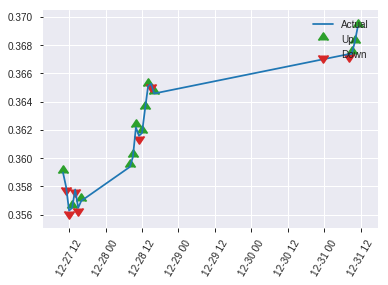


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20960184760243034
RMSE: 0.45782294350811026
LogLoss: 0.60420772159549
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.7074742286341
Residual deviance: 269.4766438315885
AIC: 371.4766438315885
AUC: 0.7271035598705501
pr_auc: 0.6887252296209423
Gini: 0.4542071197411002
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2143084402792057: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      36   84   0.7      (84.0/120.0)
1      6    97   0.0583   (6.0/103.0)
Total  42   181  0.4036   (90.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.214308     0.683099  180
max f2                       0.134566     0.829268  202
max f0point5                 0.596724     0.690141  62
max accuracy                 0.596724     0.695067  62
max precision                0.978849     1         0
max recall                   0.0975573    1         210
max specificity              0.978849     1         0
max absolute_mcc             0.596724     0.397601  62
max min_per_class_accuracy   0.450156     0.666667  108
max mean_per_class_accuracy  0.590252     0.680218  64

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 45.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.914391           2.16505   2.16505            1                0.946824   1                           0.946824            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.910437           1.08252   1.73204            0.5              0.910691   0.8                         0.932371            0.00970874      0.038835                   8.25243   73.2039
    3        0.0313901                   0.889276           1.08252   1.54646            0.5              0.901564   0.714286                    0.923569            0.00970874      0.0485437                  8.25243   54.6463
    4        0.0403587                   0.87444            2.16505   1.68393            1                0.883745   0.777778                    0.914719            0.0194175       0.0679612                  116.505   68.3927
    5        0.0538117                   0.850336           2.16505   1.80421            1                0.85958    0.833333                    0.900934            0.0291262       0.0970874                  116.505   80.4207
    6        0.103139                    0.773103           1.57458   1.69439            0.727273         0.805384   0.782609                    0.855236            0.0776699       0.174757                   57.4581   69.4386
    7        0.152466                    0.735935           1.96823   1.78298            0.909091         0.751528   0.823529                    0.821684            0.0970874       0.271845                   96.8226   78.2981
    8        0.201794                    0.687851           1.7714    1.78015            0.818182         0.714223   0.822222                    0.795416            0.0873786       0.359223                   77.1403   78.0151
    9        0.300448                    0.578495           1.27935   1.61571            0.590909         0.630373   0.746269                    0.741223            0.126214        0.485437                   27.9347   61.5708
    10       0.399103                    0.50486            0.78729   1.41093            0.363636         0.544637   0.651685                    0.692628            0.0776699       0.563107                   -21.271   41.0931
    11       0.502242                    0.438153           1.22372   1.37249            0.565217         0.470068   0.633929                    0.646924            0.126214        0.68932                    22.3723   37.2486
    12       0.600897                    0.365734           0.393645  1.21178            0.181818         0.400931   0.559701                    0.606537            0.038835        0.728155                   -60.6355  21.1781
    13       0.699552                    0.303398           0.885702  1.1658             0.409091         0.334718   0.538462                    0.568204            0.0873786       0.815534                   -11.4298  16.5795
    14       0.798206                    0.225526           1.08252   1.1555             0.5              0.267121   0.533708                    0.530991            0.106796        0.92233                    8.25243   15.5503
    15       0.896861                    0.153209           0.590468  1.09335            0.272727         0.184296   0.505                       0.492855            0.0582524       0.980583                   -40.9532  9.33495
    16       1                           0.0125749          0.188265  1                  0.0869565        0.0841591  0.461883                   

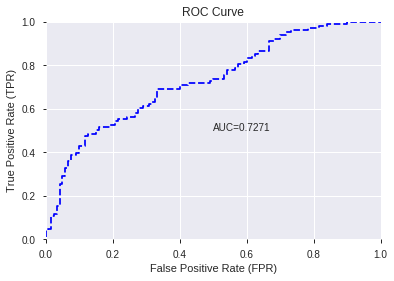

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


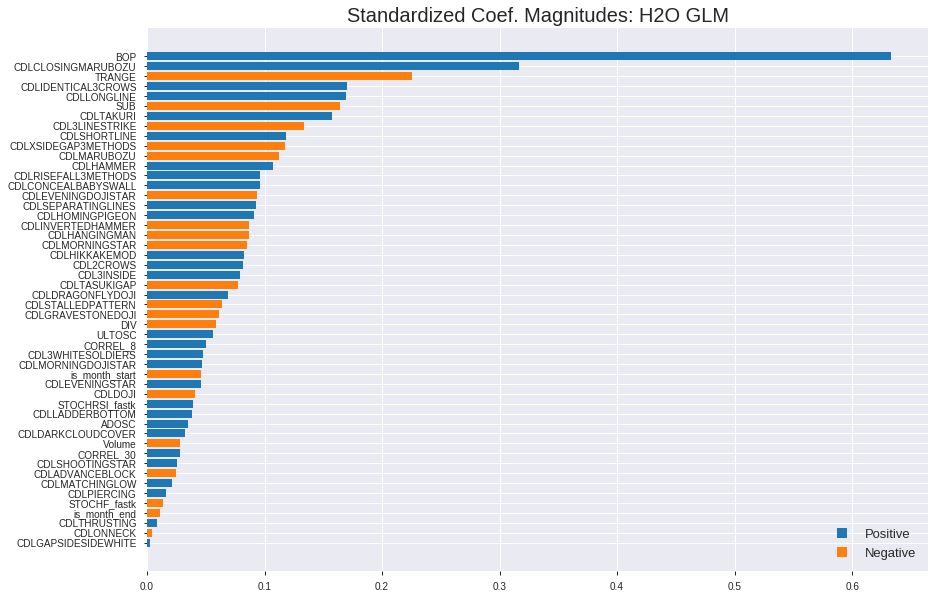

'log_likelihood'
--2019-08-26 18:12:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.180
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.180|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_181204_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_181204_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'CDLIDENTICAL3CROWS',
 'CDLLONGLINE',
 'SUB',
 'CDLTAKURI',
 'CDL3LINESTRIKE',
 'CDLSHORTLINE',
 'CDLXSIDEGAP3METHODS',
 'CDLMARUBOZU',
 'CDLHAMMER',
 'CDLRISEFALL3METHODS',
 'CDLCONCEALBABYSWALL',
 'CDLEVENINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CDLHOMINGPIGEON',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLMORNINGSTAR',
 'CDLHIKKAKEMOD',
 'CDL2CROWS',
 'CDL3INSIDE',
 'CDLTASUKIGAP',
 'CDLDRAGONFLYDOJI',
 'CDLSTALLEDPATTERN',
 'CDLGRAVESTONEDOJI',
 'DIV',
 'ULTOSC',
 'CORREL_8',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'is_month_start',
 'CDLEVENINGSTAR',
 'CDLDOJI',
 'STOCHRSI_fastk',
 'CDLLADDERBOTTOM',
 'ADOSC',
 'CDLDARKCLOUDCOVER',
 'Volume',
 'CORREL_30',
 'CDLSHOOTINGSTAR',
 'CDLADVANCEBLOCK',
 'CDLMATCHINGLOW',
 'CDLPIERCING',
 'STOCHF_fastk',
 'is_month_end',
 'CDLTHRUSTING',
 'CDLONNECK',
 'CDLGAPSIDESIDEWHITE']

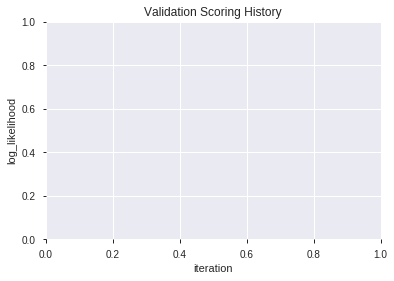

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_181213_model_4  0.772654  0.573628              0.344417  0.442432  0.195746
1  XGBoost_grid_1_AutoML_20190826_181213_model_6  0.767152  0.571670              0.310963  0.441723  0.195119
2               XGBoost_1_AutoML_20190826_181213  0.766748  0.572839              0.285922  0.443148  0.196380
3               XGBoost_2_AutoML_20190826_181213  0.765534  0.578476              0.279652  0.444918  0.197952
4               XGBoost_3_AutoML_20190826_181213  0.761974  0.569602              0.317921  0.442112  0.195463
5  XGBoost_grid_1_AutoML_20190826_181213_model_7  0.761812  0.575646              0.342273  0.444032  0.197165
6  XGBoost_grid_1_AutoML_20190826_181213_model_2  0.761003  0.581410              0.354814  0.445523  0.198491
7  XGBoost_grid_1_AutoML_20190826_181213_model_5  0.759709  0.591688              0.285963  0.449532  0.202079
8  XGBoost_grid_1_AutoML_20190826_181213_model_1  0.755583  0.578398              0.303277  0.445665  0.198618
9  XGBoost_grid_1_AutoML_20190826_181213_model_3  0.740777  0.589325              0.378439  0.449807  0.202327

variable  relative_importance  scaled_importance  percentage
0                  BOP          2048.653076           1.000000    0.454948
1                  DIV           572.716125           0.279557    0.127184
2               TRANGE           385.664703           0.188253    0.085645
3               Volume           266.517792           0.130094    0.059186
4            CORREL_30           263.674896           0.128706    0.058555
5               ULTOSC           246.117157           0.120136    0.054656
6         STOCHF_fastk           200.128677           0.097688    0.044443
7                  SUB           181.857666           0.088769    0.040385
8       STOCHRSI_fastk           173.103760           0.084496    0.038441
9                ADOSC           147.293106           0.071898    0.032710
10         CDLLONGLINE            12.672489           0.006186    0.002814
11  CDLCLOSINGMARUBOZU             4.653879           0.002272    0.001033

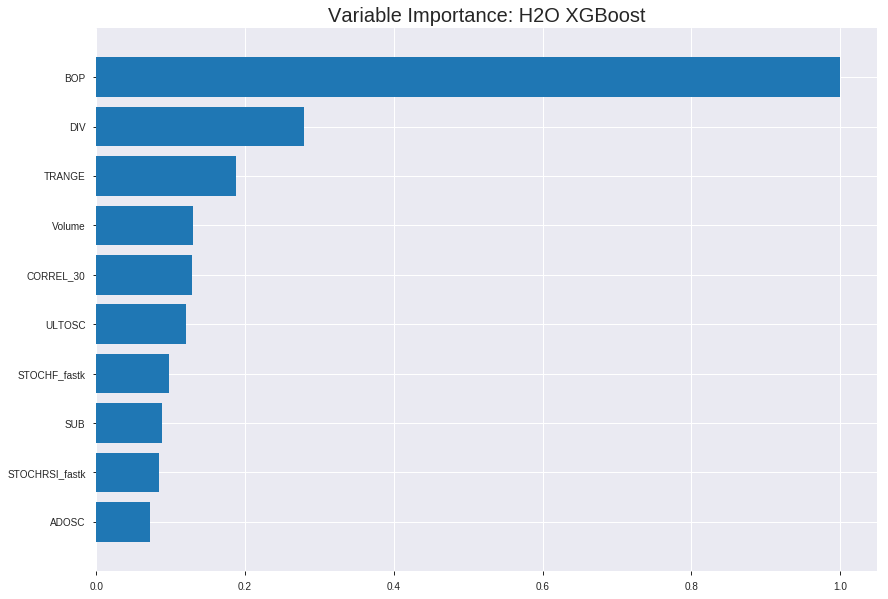

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_181213_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17735996079728433
RMSE: 0.42114125990845913
LogLoss: 0.5333003966515949
Mean Per-Class Error: 0.2540406469000914
AUC: 0.816212326265816
pr_auc: 0.8031570225311933
Gini: 0.6324246525316319
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4346314115183694: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      519  270  0.3422   (270.0/789.0)
1      133  634  0.1734   (133.0/767.0)
Total  652  904  0.259    (403.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434631     0.758827  229
max f2                       0.259797     0.847615  319
max f0point5                 0.550146     0.748159  168
max accuracy                 0.467516     0.745501  210
max precision                0.890651     1         0
max recall                   0.119671     1         388
max specificity              0.890651     1         0
max absolute_mcc             0.467516     0.492694  210
max min_per_class_accuracy   0.496907     0.740548  196
max mean_per_class_accuracy  0.467516     0.745959  210

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 49.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.865713           1.90189   1.90189            0.9375           0.87535   0.9375                      0.87535             0.0195567       0.0195567                  90.189    90.189
    2        0.0205656                   0.855724           2.02868   1.96529            1                0.860461  0.96875                     0.867905            0.0208605       0.0404172                  102.868   96.5287
    3        0.0302057                   0.849536           2.02868   1.98552            1                0.852872  0.978723                    0.863108            0.0195567       0.0599739                  102.868   98.552
    4        0.0404884                   0.840953           1.90189   1.96428            0.9375           0.844757  0.968254                    0.858447            0.0195567       0.0795306                  90.189    96.4281
    5        0.0501285                   0.834843           2.02868   1.97667            1                0.837586  0.974359                    0.854435            0.0195567       0.0990874                  102.868   97.6666
    6        0.100257                    0.794991           1.74259   1.85963            0.858974         0.813438  0.916667                    0.833937            0.0873533       0.186441                   74.2587   85.9626
    7        0.150386                    0.76595            1.66456   1.7946             0.820513         0.781848  0.884615                    0.816574            0.083442        0.269883                   66.4561   79.4604
    8        0.200514                    0.736322           1.56053   1.73608            0.769231         0.752064  0.855769                    0.800446            0.0782269       0.34811                    56.0526   73.6085
    9        0.300129                    0.657133           1.53133   1.66812            0.754839         0.699451  0.82227                     0.766925            0.152542        0.500652                   53.1329   66.8125
    10       0.400386                    0.570386           1.31344   1.57931            0.647436         0.612385  0.778491                    0.728228            0.131682        0.632334                   31.3442   57.9312
    11       0.5                         0.493437           1.13868   1.49153            0.56129          0.530495  0.735219                    0.688834            0.113429        0.745763                   13.868    49.1525
    12       0.600257                    0.415897           0.923311  1.39662            0.455128         0.454464  0.688437                    0.649689            0.0925684       0.838331                   -7.66891  39.662
    13       0.699871                    0.33826            0.615149  1.28539            0.303226         0.373901  0.633609                    0.610435            0.0612777       0.899609                   -38.4851  28.5392
    14       0.800129                    0.260261           0.53318   1.19114            0.262821         0.29761   0.587149                    0.571238            0.053455        0.953064                   -46.682   19.1138
    15       0.899743                    0.184617           0.287942  1.09114            0.141935         0.22825   0.537857                    0.533264            0.0286832       0.981747                   -71.2058  9.11417
    16       1                           0.098579           0.182061  1                  0.0897436        0.134153  0.492931                    0.49325             



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1807454295071664
RMSE: 0.42514165816485966
LogLoss: 0.5390274665359284
Mean Per-Class Error: 0.27484427505942133
AUC: 0.8039812310466355
pr_auc: 0.7490164124237312
Gini: 0.6079624620932711
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2965640723705292: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  130  0.5221   (130.0/249.0)
1      15   181  0.0765   (15.0/196.0)
Total  134  311  0.3258   (145.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.296564     0.714004  285
max f2                       0.284333     0.840072  297
max f0point5                 0.570675     0.717949  137
max accuracy                 0.570675     0.734831  137
max precision                0.896098     1         0
max recall                   0.153453     1         367
max specificity              0.896098     1         0
max absolute_mcc             0.570675     0.45982   137
max min_per_class_accuracy   0.447426     0.719388  195
max mean_per_class_accuracy  0.447426     0.725156  195

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 45.39 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.840917           2.27041    2.27041            1                0.869235  1                           0.869235            0.0255102       0.0255102                  127.041   127.041
    2        0.0202247                   0.8275             1.70281    2.01814            0.75             0.833647  0.888889                    0.853418            0.0153061       0.0408163                  70.2806   101.814
    3        0.0314607                   0.819156           2.27041    2.10824            1                0.823015  0.928571                    0.84256             0.0255102       0.0663265                  127.041   110.824
    4        0.0404494                   0.807146           2.27041    2.14427            1                0.814058  0.944444                    0.836226            0.0204082       0.0867347                  127.041   114.427
    5        0.0516854                   0.801645           1.36224    1.97427            0.6              0.803482  0.869565                    0.829108            0.0153061       0.102041                   36.2245   97.4268
    6        0.101124                    0.757858           1.96081    1.96769            0.863636         0.780942  0.866667                    0.80556             0.0969388       0.19898                    96.0807   96.7687
    7        0.150562                    0.730208           1.75441    1.89765            0.772727         0.746111  0.835821                    0.786039            0.0867347       0.285714                   75.4406   89.7655
    8        0.2                         0.690162           1.75441    1.86224            0.772727         0.712941  0.820225                    0.76797             0.0867347       0.372449                   75.4406   86.2245
    9        0.301124                    0.599624           1.56406    1.76211            0.688889         0.646241  0.776119                    0.727091            0.158163        0.530612                   56.4059   76.2108
    10       0.4                         0.50616            1.1352     1.60714            0.5              0.550093  0.707865                    0.683339            0.112245        0.642857                   13.5204   60.7143
    11       0.501124                    0.427513           0.958617   1.47627            0.422222         0.465922  0.650224                    0.639465            0.0969388       0.739796                   -4.13832  47.6274
    12       0.6                         0.370498           0.774003   1.36054            0.340909         0.396636  0.599251                    0.599449            0.0765306       0.816327                   -22.5997  36.0544
    13       0.698876                    0.294472           1.0836     1.32136            0.477273         0.332952  0.581994                    0.561745            0.107143        0.923469                   8.36039   32.1363
    14       0.8                         0.249109           0.454082   1.21173            0.2              0.273292  0.533708                    0.525283            0.0459184       0.969388                   -54.5918  21.1735
    15       0.898876                    0.16495            0.258001   1.10682            0.113636         0.206301  0.4875                      0.490195            0.0255102       0.994898                   -74.1999  10.6824
    16       1                           0.101877           0.0504535  1                  0.0222222        0.131551  0.440449                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:12:19  2.485 sec   0                  0.5              0.693147            0.5             0                  1                0.507069                         0.5                0.693147              0.5               0                    1                  0.559551
    2019-08-26 18:12:19  2.531 sec   5                  0.47804          0.649935            0.782016        0.736039           2.02868          0.304627                         0.477022           0.647965              0.79182           0.724829             2.27041            0.301124
    2019-08-26 18:12:19  2.560 sec   10                 0.462795         0.620215            0.788398        0.763032           1.90189          0.280206                         0.461057           0.616834              0.797455          0.757508             2.27041            0.289888
    2019-08-26 18:12:19  2.591 sec   15                 0.452538         0.599952            0.791127        0.778485           2.02868          0.280848                         0.44948            0.593961              0.802905          0.764211             2.27041            0.332584
    2019-08-26 18:12:19  2.625 sec   20                 0.445634         0.585933            0.793875        0.78306            1.90189          0.291774                         0.442482           0.579467              0.802444          0.761826             2.27041            0.332584
    2019-08-26 18:12:19  2.664 sec   25                 0.440739         0.575662            0.795353        0.783937           1.90189          0.282776                         0.437508           0.56887               0.803551          0.762724             2.27041            0.330337
    2019-08-26 18:12:19  2.698 sec   30                 0.436806         0.567273            0.797417        0.784524           1.90189          0.284062                         0.433581           0.56017               0.804596          0.763722             2.27041            0.319101
    2019-08-26 18:12:19  2.737 sec   35                 0.433864         0.560973            0.800264        0.786335           1.90189          0.282134                         0.431239           0.554715              0.805057          0.76271              2.27041            0.323596
    2019-08-26 18:12:19  2.777 sec   40                 0.431491         0.555815            0.802003        0.787264           1.90189          0.280206                         0.429335           0.550133              0.806174          0.759642             2.27041            0.330337
    2019-08-26 18:12:19  2.821 sec   45                 0.429592         0.551546            0.803724        0.790698           1.90189          0.278278                         0.427097           0.544907              0.80771           0.762393             2.27041            0.32809
    2019-08-26 18:12:20  2.872 sec   50                 0.427983         0.548001            0.805877        0.794286           1.90189          0.273779                         0.426047           0.542491              0.809165          0.758036             2.27041            0.32809
    2019-08-26 18:12:20  2.916 sec   55                 0.42632          0.544513            0.808842        0.7967             1.90189          0.260925                         0.425922           0.542001              0.807833          0.7

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 2048.65                1                    0.454948
DIV                 572.716                0.279557             0.127184
TRANGE              385.665                0.188253             0.0856452
Volume              266.518                0.130094             0.059186
CORREL_30           263.675                0.128706             0.0585547
ULTOSC              246.117                0.120136             0.0546556
STOCHF_fastk        200.129                0.0976879            0.0444429
SUB                 181.858                0.0887694            0.0403854
STOCHRSI_fastk      173.104                0.0844964            0.0384414
ADOSC               147.293                0.0718975            0.0327096
CDLLONGLINE         12.6725                0.00618577           0.0028142
CDLCLOSINGMARUBOZU  4.65388                0.00227168           0.00103349

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.7071428571428572)

('auc', 0.772653721682848)

('logloss', 0.5736279553053041)

('mean_per_class_error', 0.2879854368932039)

('rmse', 0.4424321611483486)

('mse', 0.19574621721839833)

xgboost prediction progress: |████████████████████████████████████████████| 100%


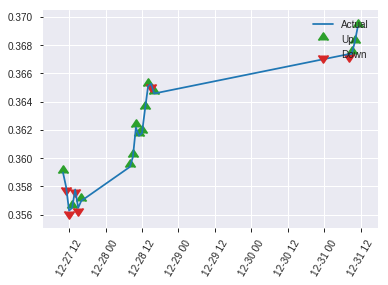


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19574621721839833
RMSE: 0.4424321611483486
LogLoss: 0.5736279553053041
Mean Per-Class Error: 0.2879854368932039
AUC: 0.772653721682848
pr_auc: 0.7391452602983183
Gini: 0.5453074433656959
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2022911161184311: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   78   0.65     (78.0/120.0)
1      4    99   0.0388   (4.0/103.0)
Total  46   177  0.3677   (82.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.202291     0.707143  176
max f2                       0.202291     0.840407  176
max f0point5                 0.495006     0.701149  82
max accuracy                 0.495006     0.713004  82
max precision                0.895045     1         0
max recall                   0.133693     1         207
max specificity              0.895045     1         0
max absolute_mcc             0.423623     0.423515  104
max min_per_class_accuracy   0.420482     0.708333  107
max mean_per_class_accuracy  0.423623     0.712015  104

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 41.98 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.85174            2.16505    2.16505            1                0.869035  1                           0.869035            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.840152           2.16505    2.16505            1                0.845748  1                           0.85972             0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.820063           1.08252    1.85576            0.5              0.829039  0.857143                    0.850954            0.00970874      0.0582524                  8.25243   85.5756
    4        0.0403587                   0.814646           2.16505    1.92449            1                0.818514  0.888889                    0.843745            0.0194175       0.0776699                  116.505   92.4488
    5        0.0538117                   0.793384           1.44337    1.80421            0.666667         0.803479  0.833333                    0.833679            0.0194175       0.0970874                  44.3366   80.4207
    6        0.103139                    0.734021           2.16505    1.97678            1                0.753769  0.913043                    0.795461            0.106796        0.203883                   116.505   97.6783
    7        0.152466                    0.675705           1.7714     1.91034            0.818182         0.698948  0.882353                    0.764236            0.0873786       0.291262                   77.1403   91.0337
    8        0.201794                    0.643326           1.37776    1.78015            0.636364         0.660363  0.822222                    0.738845            0.0679612       0.359223                   37.7758   78.0151
    9        0.300448                    0.541551           1.47617    1.68034            0.681818         0.59815   0.776119                    0.692647            0.145631        0.504854                   47.6169   68.0336
    10       0.399103                    0.471638           1.08252    1.53256            0.5              0.506378  0.707865                    0.646603            0.106796        0.61165                    8.25243   53.2562
    11       0.502242                    0.410235           0.941325   1.41115            0.434783         0.436343  0.651786                    0.603424            0.0970874       0.708738                   -5.86745  41.1148
    12       0.600897                    0.315219           0.688879   1.29257            0.318182         0.364551  0.597015                    0.564206            0.0679612       0.776699                   -31.1121  29.2566
    13       0.699552                    0.267598           0.885702   1.23519            0.409091         0.289653  0.570513                    0.525487            0.0873786       0.864078                   -11.4298  23.5188
    14       0.798206                    0.19647            0.984113   1.20416            0.454545         0.232844  0.55618                     0.489318            0.0970874       0.961165                   -1.5887   20.4156
    15       0.896861                    0.143107           0.295234   1.10417            0.136364         0.164884  0.51                        0.45363             0.0291262       0.990291                   -70.4766  10.4175
    16       1                           0.099039           0.0941325  1                  0.0434783        0.125735  0.461883                   

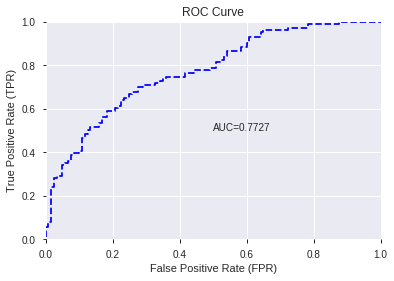

This function is available for GLM models only


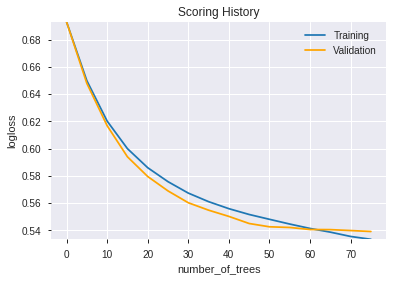

--2019-08-26 18:12:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_181213_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_181213_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'Volume',
 'CORREL_30',
 'ULTOSC',
 'STOCHF_fastk',
 'SUB',
 'STOCHRSI_fastk',
 'ADOSC',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 919] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


50

['Volume',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CMO_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_181235_model_2  0.760599  0.656690              0.309628  0.458853  0.210546
1  DeepLearning_grid_1_AutoML_20190826_181235_model_9  0.757443  0.590201              0.334668  0.449106  0.201696
2  DeepLearning_grid_1_AutoML_20190826_181235_model_6  0.755016  0.608612              0.311731  0.453953  0.206074
3  DeepLearning_grid_1_AutoML_20190826_181235_model_3  0.754531  0.718505              0.299879  0.470166  0.221056
4  DeepLearning_grid_1_AutoML_20190826_181235_model_7  0.752751  0.618962              0.327710  0.458429  0.210157
5  DeepLearning_grid_1_AutoML_20190826_181235_model_8  0.752265  0.591665              0.321440  0.452695  0.204933
6  DeepLearning_grid_1_AutoML_20190826_181235_model_4  0.747330  0.711754              0.343689  0.478286  0.228757
7  DeepLearning_grid_1_AutoML_20190826_181235_model_5  0.745793  0.590881              0.315858  0.453165  0.205358
8               DeepLearning_1_AutoML_20190826_181235  0.734466  0.637533              0.365939  0.468039  0.219061
9  DeepLearning_grid_1_AutoML_20190826_181235_model_1  0.699676  0.906572              0.368689  0.516823  0.267106

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.037197
1       STOCHRSI_fastk             0.839906           0.839906    0.031242
2               ULTOSC             0.756503           0.756503    0.028140
3         STOCHF_fastk             0.731071           0.731071    0.027194
4                CCI_8             0.729268           0.729268    0.027127
5             WILLR_30             0.727010           0.727010    0.027043
6          CDLBELTHOLD             0.719080           0.719080    0.026748
7             WILLR_14             0.698789           0.698789    0.025993
8               TRANGE             0.687172           0.687172    0.025561
9               Volume             0.680093           0.680093    0.025298
10             WILLR_8             0.675248           0.675248    0.025117
11            WILLR_12             0.675079           0.675079    0.025111
12               ADOSC             0.642619           0.642619    0.023904
13        CDLSHORTLINE             0.639427           0.639427    0.023785
14  CDLCLOSINGMARUBOZU             0.634139           0.634139    0.023588
15                 DIV             0.616449           0.616449    0.022930
16              CCI_12             0.615116           0.615116    0.022881
17                 SUB             0.607035           0.607035    0.022580
18            WILLR_24             0.596118           0.596118    0.022174
19            WILLR_20             0.581692           0.581692    0.021637
20              RSI_24             0.558425           0.558425    0.020772
21    CDLDRAGONFLYDOJI             0.542775           0.542775    0.020190
22         CDLLONGLINE             0.533676           0.533676    0.019851
23              CMO_24             0.525353           0.525353    0.019542
24           CDLTAKURI             0.525064           0.525064    0.019531
25        CDLENGULFING             0.489867           0.489867    0.018222
26              RSI_20             0.483353           0.483353    0.017979
27               RSI_8             0.444745           0.444745    0.016543
28              RSI_14             0.441135           0.441135    0.016409
29               CMO_8             0.434887           0.434887    0.016177
30              CMO_14             0.427062           0.427062    0.015886
31              ROC_12             0.423949           0.423949    0.015770
32              MOM_14             0.418633           0.418633    0.015572
33              CMO_20             0.416738           0.416738    0.015502
34             ROCR_14             0.414100           0.414100    0.015403
35             ROCR_12             0.413709           0.413709    0.015389
36           ROCR100_8             0.407205           0.407205    0.015147
37              ROCR_8             0.406904           0.406904    0.015136
38          ROCR100_12             0.406680           0.406680    0.015127
39              CMO_12             0.406226           0.406226    0.015110
40              ROC_14             0.401116           0.401116    0.014920
41               ROC_8             0.397536           0.397536    0.014787
42              ROCP_8             0.397092           0.397092    0.014771
43              RSI_12             0.395806           0.395806    0.014723
44               MOM_8             0.393789           0.393789    0.014648
45             ROCP_12             0.393395           0.393395    0.014633
46         CDLMARUBOZU             0.389718           0.389718    0.014496
47              MOM_12             0.384931           0.384931    0.014318
48             ROCP_14             0.381044           0.381044    0.014174
49          ROCR100_14             0.376965           0.376965    0.014022

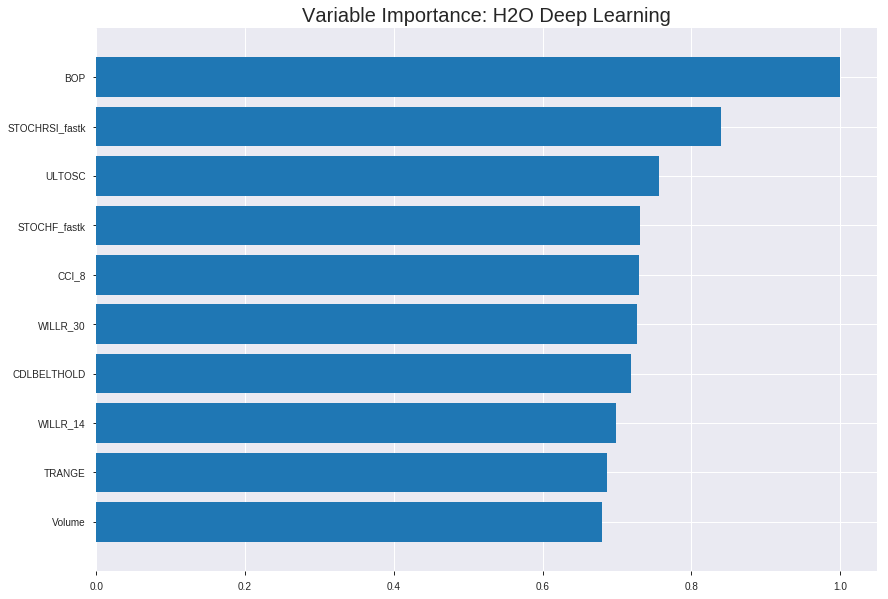

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_181235_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18575493698662326
RMSE: 0.4309929662843969
LogLoss: 0.5640819322568809
Mean Per-Class Error: 0.26456425789415405
AUC: 0.7979701336664666
pr_auc: 0.7820710723574054
Gini: 0.5959402673329333
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35721420767465817: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      489  300  0.3802   (300.0/789.0)
1      147  620  0.1917   (147.0/767.0)
Total  636  920  0.2873   (447.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.357214     0.735033  248
max f2                       0.0419122    0.837373  379
max f0point5                 0.530719     0.750869  171
max accuracy                 0.508393     0.735861  181
max precision                0.999622     1         0
max recall                   0.0160685    1         393
max specificity              0.999622     1         0
max absolute_mcc             0.523354     0.476935  174
max min_per_class_accuracy   0.433735     0.724902  212
max mean_per_class_accuracy  0.457999     0.735436  201

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 45.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.998836           1.7751    1.7751             0.875            0.99943    0.875                       0.99943             0.0182529       0.0182529                  77.5098   77.5098
    2        0.0205656                   0.992199           2.02868   1.90189            1                0.995838   0.9375                      0.997634            0.0208605       0.0391134                  102.868   90.189
    3        0.0302057                   0.983937           1.75819   1.85603            0.866667         0.988383   0.914894                    0.994682            0.0169492       0.0560626                  75.8192   85.6029
    4        0.0404884                   0.975491           2.02868   1.89988            1                0.980798   0.936508                    0.991156            0.0208605       0.0769231                  102.868   89.9878
    5        0.0501285                   0.965067           1.89344   1.89864            0.933333         0.970704   0.935897                    0.987223            0.0182529       0.095176                   89.3438   89.8639
    6        0.100257                    0.89589            1.82061   1.85963            0.897436         0.932921   0.916667                    0.960072            0.0912647       0.186441                   82.0613   85.9626
    7        0.150386                    0.807884           1.7686    1.82928            0.871795         0.846665   0.901709                    0.922269            0.0886571       0.275098                   76.8596   82.9283
    8        0.200514                    0.726885           1.58653   1.7686             0.782051         0.769356   0.871795                    0.884041            0.0795306       0.354628                   58.6534   76.8596
    9        0.300129                    0.620294           1.41353   1.65075            0.696774         0.671153   0.813704                    0.813382            0.140808        0.495437                   41.3534   65.0749
    10       0.400386                    0.517054           1.39147   1.58582            0.685897         0.565683   0.781701                    0.751358            0.139505        0.634941                   39.1469   58.5825
    11       0.5                         0.429125           0.929268  1.45502            0.458065         0.47074    0.717224                    0.695451            0.0925684       0.72751                    -7.07322  45.502
    12       0.600257                    0.348038           0.858289  1.35535            0.423077         0.389743   0.668094                    0.64439             0.0860495       0.813559                   -14.1711  35.5352
    13       0.699871                    0.255231           0.628237  1.25186            0.309677         0.307998   0.61708                     0.596511            0.0625815       0.876141                   -37.1763  25.186
    14       0.800129                    0.162498           0.572193  1.1667             0.282051         0.20861    0.5751                      0.547906            0.0573664       0.933507                   -42.7807  16.6697
    15       0.899743                    0.0750907          0.392648  1.081              0.193548         0.11404    0.532857                    0.499871            0.0391134       0.972621                   -60.7352  8.09983
    16       1                           0.000215109        0.273092  1                  0.134615         0.0389599  0.492931                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18721843968457644
RMSE: 0.4326874618989744
LogLoss: 0.5606315150004446
Mean Per-Class Error: 0.27262109663142364
AUC: 0.7866260962216212
pr_auc: 0.7339450469446421
Gini: 0.5732521924432423
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34152199971249664: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      154  95   0.3815   (95.0/249.0)
1      38   158  0.1939   (38.0/196.0)
Total  192  253  0.2989   (133.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341522     0.703786  229
max f2                       0.103973     0.831191  345
max f0point5                 0.575393     0.707418  123
max accuracy                 0.448712     0.732584  177
max precision                0.999398     1         0
max recall                   0.0609609    1         368
max specificity              0.999398     1         0
max absolute_mcc             0.444505     0.456115  179
max min_per_class_accuracy   0.42896      0.714286  190
max mean_per_class_accuracy  0.444505     0.727379  179

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 43.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.995606           1.81633    1.81633            0.8              0.998463   0.8                         0.998463            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.983078           1.70281    1.76587            0.75             0.989459   0.777778                    0.994461            0.0153061       0.0357143                  70.2806   76.5873
    3        0.0314607                   0.971781           2.27041    1.94606            1                0.977643   0.857143                    0.988455            0.0255102       0.0612245                  127.041   94.6064
    4        0.0404494                   0.958994           2.27041    2.01814            1                0.967946   0.888889                    0.983897            0.0204082       0.0816327                  127.041   101.814
    5        0.0516854                   0.938779           2.27041    2.07298            1                0.9469     0.913043                    0.975854            0.0255102       0.107143                   127.041   107.298
    6        0.101124                    0.874983           1.75441    1.91723            0.772727         0.902267   0.844444                    0.939878            0.0867347       0.193878                   75.4406   91.7234
    7        0.150562                    0.812774           1.96081    1.93154            0.863636         0.847812   0.850746                    0.909647            0.0969388       0.290816                   96.0807   93.1541
    8        0.2                         0.739785           1.75441    1.88776            0.772727         0.76954    0.831461                    0.875014            0.0867347       0.377551                   75.4406   88.7755
    9        0.301124                    0.574009           1.46315    1.74516            0.644444         0.665498   0.768657                    0.804654            0.147959        0.52551                    46.3152   74.5164
    10       0.4                         0.465606           1.1868     1.60714            0.522727         0.516651   0.707865                    0.733462            0.117347        0.642857                   18.6804   60.7143
    11       0.501124                    0.387281           0.908163   1.46609            0.4              0.429431   0.64574                     0.672111            0.0918367       0.734694                   -9.18367  46.6093
    12       0.6                         0.324477           0.825603   1.36054            0.363636         0.354201   0.599251                    0.619721            0.0816327       0.816327                   -17.4397  36.0544
    13       0.698876                    0.241123           0.412801   1.22646            0.181818         0.285229   0.540193                    0.572397            0.0408163       0.857143                   -58.7199  22.6458
    14       0.8                         0.157673           0.958617   1.1926             0.422222         0.199849   0.525281                    0.525306            0.0969388       0.954082                   -4.13832  19.2602
    15       0.898876                    0.0729152          0.412801   1.10682            0.181818         0.113672   0.4875                      0.480026            0.0408163       0.994898                   -58.7199  10.6824
    16       1                           0.000536938        0.0504535  1                  0.0222222        0.0383605  0.440449 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:13:50  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 18:13:52  1 min 16.297 sec  6150 obs/sec      10        1             15560      0.44951          0.601754            0.191601       0.768529        0.755398           2.02868          0.34383                          0.447477           0.60239               0.187534         0.760501          0.703293             1.81633            0.334831
    2019-08-26 18:13:57  1 min 21.302 sec  8342 obs/sec      40        4             62240      0.430993         0.564082            0.256832       0.79797         0.782071           1.7751           0.287275                         0.432687           0.560632              0.240351         0.786626          0.733945             1.81633            0.298876
    2019-08-26 18:14:03  1 min 27.353 sec  10422 obs/sec     90        9             140040     0.428709         0.569641            0.264686       0.818874        0.791454           2.02868          0.270566                         0.452605           0.627569              0.168803         0.771125          0.696414             1.81633            0.323596
    2019-08-26 18:14:09  1 min 32.579 sec  11717 obs/sec     140       14            217840     0.405615         0.518946            0.341775       0.84279         0.80592            2.02868          0.23072                          0.453708           0.644694              0.164749         0.766075          0.69164              2.27041            0.34382
    2019-08-26 18:14:14  1 min 38.476 sec  12744 obs/sec     200       20            311200     0.378182         0.44968             0.4278         0.875472        0.825329           2.02868          0.217866                         0.450069           0.647225              0.178093         0.77301           0.690678             1.81633            0.359551
    2019-08-26 18:14:20  1 min 44.014 sec  13536 obs/sec     260       26            404560     0.373276         0.440729            0.44255        0.881105        0.828902           2.02868          0.197943                         0.453841           0.678672              0.164259         0.772734          0.684476             1.81633            0.38427
    2019-08-26 18:14:20  1 min 44.089 sec  13534 obs/sec     260       26            404560     0.430993         0.564082            0.256832       0.79797         0.782071           1.7751           0.287275                         0.432687           0.560632              0.240351         0.786626          0.733945             1.81633            0.298876

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
BOP             1.0                    1.0                  0.03719727162046422
STOCHRSI_fastk  0.8399063944816589     0.8399063944816589   0.031242226291299035
ULTOSC          0.7565030455589294     0.7565030455589294   0.028139849267363917
STOCHF_fastk    0.7310706973075867     0.7310706973075867   0.02719383530151248
CCI_8           0.7292678952217102     0.7292678952217102   0.027126775982646192
---             ---                    ---                  ---
ROCP_12         0.39339539408683777    0.39339539408683777  0.014633235328087668
CDLMARUBOZU     0.3897176682949066     0.3897176682949066   0.014496433962859618
MOM_12          0.38493120670318604    0.38493120670318604  0.014318390650931467
ROCP_14         0.3810443580150604     0.3810443580150604   0.014173810484531615
ROCR100_14      0.3769645690917969     0.3769645690917969   0.014022053467798818


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7040358744394619)

('F1', 0.712)

('auc', 0.7605987055016181)

('logloss', 0.6566903534483717)

('mean_per_class_error', 0.3046521035598706)

('rmse', 0.45885336880751915)

('mse', 0.21054641406600919)

deeplearning prediction progress: |███████████████████████████████████████| 100%


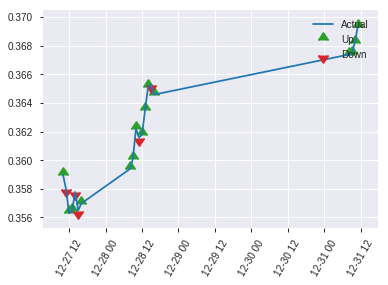


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21054641406600919
RMSE: 0.45885336880751915
LogLoss: 0.6566903534483717
Mean Per-Class Error: 0.3046521035598706
AUC: 0.7605987055016181
pr_auc: 0.6888562989954701
Gini: 0.5211974110032362
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20374662934553456: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   58   0.4833   (58.0/120.0)
1      14   89   0.1359   (14.0/103.0)
Total  76   147  0.3229   (72.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.203747     0.712     146
max f2                       0.0644371    0.840198  194
max f0point5                 0.578439     0.707965  58
max accuracy                 0.578439     0.704036  58
max precision                0.939041     0.857143  13
max recall                   0.0502339    1         200
max specificity              0.999798     0.991667  0
max absolute_mcc             0.578439     0.423099  58
max min_per_class_accuracy   0.351566     0.691667  108
max mean_per_class_accuracy  0.351566     0.695348  108

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 39.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.993256           0.721683   0.721683           0.333333         0.997829   0.333333                    0.997829            0.00970874      0.00970874                 -27.8317  -27.8317
    2        0.0224215                   0.982929           2.16505    1.29903            1                0.984414   0.6                         0.992463            0.0194175       0.0291262                  116.505   29.9029
    3        0.0313901                   0.971033           2.16505    1.54646            1                0.981861   0.714286                    0.989434            0.0194175       0.0485437                  116.505   54.6463
    4        0.0403587                   0.963453           2.16505    1.68393            1                0.965667   0.777778                    0.984152            0.0194175       0.0679612                  116.505   68.3927
    5        0.0538117                   0.945679           2.16505    1.80421            1                0.952556   0.833333                    0.976253            0.0291262       0.0970874                  116.505   80.4207
    6        0.103139                    0.865419           1.37776    1.60025            0.636364         0.895553   0.73913                     0.937657            0.0679612       0.165049                   37.7758   60.0253
    7        0.152466                    0.759697           1.7714     1.65563            0.818182         0.815607   0.764706                    0.898171            0.0873786       0.252427                   77.1403   65.5625
    8        0.201794                    0.678609           1.96823    1.73204            0.909091         0.722609   0.8                         0.855256            0.0970874       0.349515                   96.8226   73.2039
    9        0.300448                    0.535964           1.47617    1.64802            0.681818         0.597159   0.761194                    0.770508            0.145631        0.495146                   47.6169   64.8022
    10       0.399103                    0.441152           0.984113   1.48391            0.454545         0.496754   0.685393                    0.702838            0.0970874       0.592233                   -1.5887   48.391
    11       0.502242                    0.329613           1.03546    1.39182            0.478261         0.386375   0.642857                    0.63785             0.106796        0.699029                   3.5458    39.1817
    12       0.600897                    0.253582           1.08252    1.34104            0.5              0.293694   0.619403                    0.581347            0.106796        0.805825                   8.25243   34.1038
    13       0.699552                    0.187138           0.78729    1.26294            0.363636         0.210083   0.583333                    0.528989            0.0776699       0.883495                   -21.271   26.2945
    14       0.798206                    0.109018           0.590468   1.17983            0.272727         0.140777   0.544944                    0.481008            0.0582524       0.941748                   -40.9532  17.983
    15       0.896861                    0.0506279          0.492056   1.10417            0.227273         0.0795363  0.51                        0.436846            0.0485437       0.990291                   -50.7944  10.4175
    16       1                           0.00114959         0.0941325  1                  0.0434783        0.022149   0.461883  

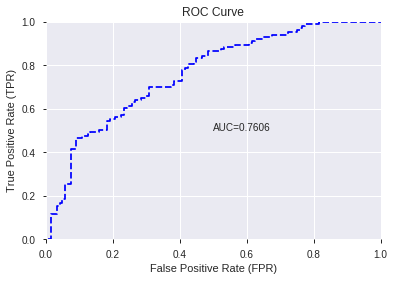

This function is available for GLM models only


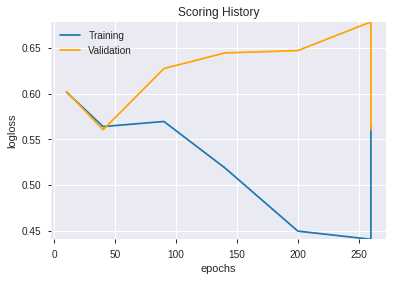

--2019-08-26 18:21:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.101.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.101.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_181235_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_181235_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'STOCHRSI_fastk',
 'ULTOSC',
 'STOCHF_fastk',
 'CCI_8',
 'WILLR_30',
 'CDLBELTHOLD',
 'WILLR_14',
 'TRANGE',
 'Volume',
 'WILLR_8',
 'WILLR_12',
 'ADOSC',
 'CDLSHORTLINE',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'CCI_12',
 'SUB',
 'WILLR_24',
 'WILLR_20',
 'RSI_24',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLINE',
 'CMO_24',
 'CDLTAKURI',
 'CDLENGULFING',
 'RSI_20',
 'RSI_8',
 'RSI_14',
 'CMO_8',
 'CMO_14',
 'ROC_12',
 'MOM_14',
 'CMO_20',
 'ROCR_14',
 'ROCR_12',
 'ROCR100_8',
 'ROCR_8',
 'ROCR100_12',
 'CMO_12',
 'ROC_14',
 'ROC_8',
 'ROCP_8',
 'RSI_12',
 'MOM_8',
 'ROCP_12',
 'CDLMARUBOZU',
 'MOM_12',
 'ROCP_14',
 'ROCR100_14']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_182115_model_1  0.763188  0.578131              0.303358  0.443874  0.197024

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.656732           1.000000    0.139128
1               CCI_12             0.404029           0.615211    0.085593
2               ULTOSC             0.350524           0.533740    0.074258
3   CDLCLOSINGMARUBOZU             0.239636           0.364892    0.050767
4                CCI_8             0.239303           0.364384    0.050696
5             WILLR_12             0.238562           0.363257    0.050539
6               TRANGE             0.217716           0.331514    0.046123
7            CDLTAKURI             0.210874           0.321097    0.044673
8          CDLLONGLINE             0.190229           0.289661    0.040300
9       STOCHRSI_fastk             0.174915           0.266341    0.037055
10        STOCHF_fastk             0.168806           0.257039    0.035761
11                 SUB             0.123151           0.187521    0.026089
12             WILLR_8             0.118067           0.179779    0.025012
13              Volume             0.100595           0.153176    0.021311
14        CDLSHORTLINE             0.095926           0.146066    0.020322
15         CDLMARUBOZU             0.075555           0.115047    0.016006
16            WILLR_20             0.073412           0.111784    0.015552
17               CMO_8             0.070196           0.106886    0.014871
18                 DIV             0.070099           0.106739    0.014850
19               RSI_8             0.066173           0.100761    0.014019
20            WILLR_14             0.063381           0.096509    0.013427
21         CDLBELTHOLD             0.059952           0.091288    0.012701
22              RSI_14             0.058888           0.089669    0.012475
23    CDLDRAGONFLYDOJI             0.057392           0.087390    0.012158
24              CMO_14             0.055696           0.084808    0.011799
25              CMO_20             0.052102           0.079336    0.011038
26              CMO_12             0.051667           0.078673    0.010946
27              RSI_20             0.050471           0.076851    0.010692
28              RSI_12             0.045259           0.068916    0.009588
29        CDLENGULFING             0.035475           0.054017    0.007515
30            WILLR_24             0.024690           0.037596    0.005231
31              MOM_12             0.021784           0.033171    0.004615
32              RSI_24             0.021003           0.031981    0.004449
33           ROCR100_8             0.020493           0.031204    0.004341
34              ROCR_8             0.020196           0.030752    0.004278
35              ROCP_8             0.019857           0.030236    0.004207
36               ROC_8             0.019522           0.029726    0.004136
37              CMO_24             0.019484           0.029668    0.004128
38          ROCR100_12             0.017892           0.027244    0.003790
39             ROCR_12             0.017650           0.026875    0.003739
40             ROCP_12             0.016529           0.025169    0.003502
41              ROC_12             0.015266           0.023245    0.003234
42               MOM_8             0.013580           0.020678    0.002877
43              MOM_14             0.012197           0.018572    0.002584
44            WILLR_30             0.010788           0.016427    0.002285
45               ADOSC             0.008084           0.012310    0.001713
46              ROC_14             0.007825           0.011915    0.001658
47             ROCP_14             0.006724           0.010239    0.001425
48             ROCR_14             0.006005           0.009144    0.001272
49          ROCR100_14             0.005996           0.009130    0.001270

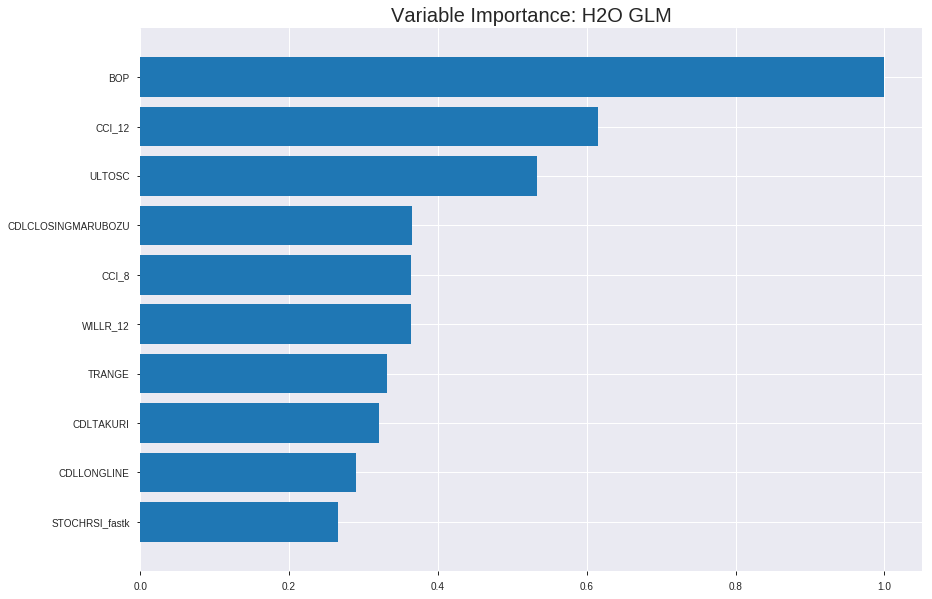

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_182115_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18966302737739726
RMSE: 0.43550318871094074
LogLoss: 0.5623199393663859
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2156.7629615535493
Residual deviance: 1749.939651308193
AIC: 1851.939651308193
AUC: 0.7845051663766622
pr_auc: 0.7719208150690114
Gini: 0.5690103327533245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38933324338170017: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      440  349  0.4423   (349.0/789.0)
1      124  643  0.1617   (124.0/767.0)
Total  564  992  0.304    (473.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389333     0.731097  244
max f2                       0.185521     0.837649  343
max f0point5                 0.586407     0.72792   150
max accuracy                 0.552687     0.717224  166
max precision                0.946228     1         0
max recall                   0.0565125    1         392
max specificity              0.946228     1         0
max absolute_mcc             0.552687     0.437908  166
max min_per_class_accuracy   0.494687     0.712294  192
max mean_per_class_accuracy  0.550541     0.716204  167

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 49.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.927944           1.90189   1.90189            0.9375           0.935565  0.9375                      0.935565            0.0195567       0.0195567                  90.189    90.189
    2        0.0205656                   0.914217           1.90189   1.90189            0.9375           0.922866  0.9375                      0.929215            0.0195567       0.0391134                  90.189    90.189
    3        0.0302057                   0.902092           1.75819   1.85603            0.866667         0.907575  0.914894                    0.922309            0.0169492       0.0560626                  75.8192   85.6029
    4        0.0404884                   0.887349           1.52151   1.77107            0.75             0.894274  0.873016                    0.915189            0.0156454       0.071708                   52.1512   77.1073
    5        0.0501285                   0.877139           2.02868   1.82061            1                0.882481  0.897436                    0.908899            0.0195567       0.0912647                  102.868   82.0613
    6        0.100257                    0.820499           1.7946    1.80761            0.884615         0.847044  0.891026                    0.877971            0.0899609       0.181226                   79.4604   80.7609
    7        0.150386                    0.775334           1.7946    1.80327            0.884615         0.798319  0.888889                    0.85142             0.0899609       0.271186                   79.4604   80.3274
    8        0.200514                    0.722611           1.53452   1.73608            0.75641          0.748623  0.855769                    0.825721            0.0769231       0.34811                    53.4517   73.6085
    9        0.300129                    0.640702           1.40045   1.62468            0.690323         0.680145  0.800857                    0.777403            0.139505        0.487614                   40.0446   62.4684
    10       0.400386                    0.566929           1.26142   1.53372            0.621795         0.605046  0.756019                    0.734245            0.126467        0.614081                   26.1425   53.3724
    11       0.5                         0.492537           1.0078    1.42894            0.496774         0.530315  0.70437                     0.693616            0.100391        0.714472                   0.779745  42.8944
    12       0.600257                    0.420765           0.910307  1.34232            0.448718         0.458655  0.66167                     0.654372            0.0912647       0.805737                   -8.96934  34.2319
    13       0.699871                    0.342098           0.693679  1.25               0.341935         0.378386  0.616162                    0.61509             0.0691004       0.874837                   -30.6321  24.9997
    14       0.800129                    0.258725           0.520175  1.15855            0.25641          0.302644  0.571084                    0.57594             0.0521512       0.926988                   -47.9825  15.8549
    15       0.899743                    0.165412           0.471178  1.08245            0.232258         0.212808  0.533571                    0.535737            0.0469361       0.973924                   -52.8822  8.24474
    16       1                           0.00196812         0.260088  1                  0.128205         0.108775  0.492931                    0.492931           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18452397023869774
RMSE: 0.4295625335602463
LogLoss: 0.546139212666165
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 615.4911432999108
Residual deviance: 486.0638992728869
AIC: 588.0638992728868
AUC: 0.7945250389312352
pr_auc: 0.7470172299516815
Gini: 0.5890500778624703
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2946667827253505: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      105  144  0.5783   (144.0/249.0)
1      13   183  0.0663   (13.0/196.0)
Total  118  327  0.3528   (157.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.294667     0.699809  294
max f2                       0.276578     0.825933  306
max f0point5                 0.628491     0.72861   127
max accuracy                 0.613777     0.741573  134
max precision                0.94015      1         0
max recall                   0.122863     1         372
max specificity              0.94015      1         0
max absolute_mcc             0.613777     0.474545  134
max min_per_class_accuracy   0.493157     0.702811  193
max mean_per_class_accuracy  0.551426     0.729602  160

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 47.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.913385           1.81633   1.81633            0.8              0.925671  0.8                         0.925671            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.892217           2.27041   2.01814            1                0.904252  0.888889                    0.916151            0.0204082       0.0408163                  127.041   101.814
    3        0.0314607                   0.875304           2.27041   2.10824            1                0.884121  0.928571                    0.904712            0.0255102       0.0663265                  127.041   110.824
    4        0.0404494                   0.862175           2.27041   2.14427            1                0.870211  0.944444                    0.897045            0.0204082       0.0867347                  127.041   114.427
    5        0.0516854                   0.845035           1.81633   2.07298            0.8              0.850875  0.913043                    0.887008            0.0204082       0.107143                   81.6327   107.298
    6        0.101124                    0.790669           1.85761   1.96769            0.818182         0.815341  0.866667                    0.851971            0.0918367       0.19898                    85.7607   96.7687
    7        0.150562                    0.735166           1.85761   1.93154            0.818182         0.764965  0.850746                    0.823402            0.0918367       0.290816                   85.7607   93.1541
    8        0.2                         0.696675           1.96081   1.93878            0.863636         0.716506  0.853933                    0.796978            0.0969388       0.387755                   96.0807   93.8776
    9        0.301124                    0.635624           1.46315   1.77905            0.644444         0.669565  0.783582                    0.75419             0.147959        0.535714                   46.3152   77.9051
    10       0.4                         0.543979           1.1868    1.63265            0.522727         0.588952  0.719101                    0.713345            0.117347        0.653061                   18.6804   63.2653
    11       0.501124                    0.47701            0.706349  1.44573            0.311111         0.507313  0.636771                    0.671769            0.0714286       0.72449                    -29.3651  44.5731
    12       0.6                         0.403286           0.774003  1.33503            0.340909         0.440424  0.588015                    0.633645            0.0765306       0.80102                    -22.5997  33.5034
    13       0.698876                    0.335515           0.928803  1.27756            0.409091         0.369917  0.562701                    0.596333            0.0918367       0.892857                   -7.11967  27.7561
    14       0.8                         0.249688           0.554989  1.18622            0.244444         0.287005  0.522472                    0.557232            0.0561224       0.94898                    -44.5011  18.6224
    15       0.898876                    0.178005           0.412801  1.10115            0.181818         0.210956  0.485                       0.519142            0.0408163       0.989796                   -58.7199  10.1148
    16       1                           0.0256555          0.100907  1                  0.0444444        0.106876  0.440449                    0.477452         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 18:21:16  0.000 sec   2            .2E2      51            1.3614010015499396  1.3588568134016854
     2019-08-26 18:21:16  0.008 sec   4            .13E2     51            1.350913301376298   1.3481668680977636
     2019-08-26 18:21:16  0.017 sec   6            .78E1     51            1.3375150219530128  1.3341622988626134
     2019-08-26 18:21:16  0.025 sec   8            .48E1     51            1.3208313734507326  1.316263252093824
     2019-08-26 18:21:16  0.035 sec   10           .3E1      51            1.3006567578463462  1.2940743660595635
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 18:21:16  0.206 sec   38           .38E-2    51            1.1238087088056108  1.0928820198898936
     2019-08-26 18:21:16  0.216 sec   40           .24E-2    51            1.1232255582038144  1.0939661054272198
     2019-08-26 18:21:16  0.222 sec   41           .15E-2    51            1.1228117748464013  1.0953074377154464
     2019-08-26 18:21:16  0.228 sec   42           .91E-3    51            1.1225177254121976  1.0967522702499766
     2019-08-26 18:21:16  0.233 sec   43           .57E-3    51            1.1223148453109986  1.0982140755328311


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7107438016528925)

('auc', 0.7631877022653721)

('logloss', 0.5781305784988657)

('mean_per_class_error', 0.29344660194174765)

('rmse', 0.44387393744985143)

('mse', 0.1970240723472346)

glm prediction progress: |████████████████████████████████████████████████| 100%


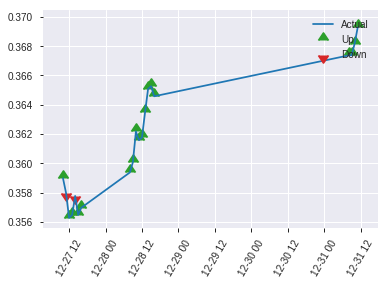


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1970240723472346
RMSE: 0.44387393744985143
LogLoss: 0.5781305784988657
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.7074742286341
Residual deviance: 257.8462380104941
AIC: 359.8462380104941
AUC: 0.7631877022653721
pr_auc: 0.7028540778327421
Gini: 0.5263754045307443
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3580586143760274: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   53   0.4417   (53.0/120.0)
1      17   86   0.165    (17.0/103.0)
Total  84   139  0.3139   (70.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358059     0.710744  138
max f2                       0.149496     0.836066  197
max f0point5                 0.583511     0.714286  73
max accuracy                 0.583511     0.717489  73
max precision                0.947085     1         0
max recall                   0.108663     1         205
max specificity              0.947085     1         0
max absolute_mcc             0.583511     0.435927  73
max min_per_class_accuracy   0.432235     0.683333  108
max mean_per_class_accuracy  0.575687     0.706553  75

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 45.68 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.933043           2.16505    2.16505            1                0.941699  1                           0.941699            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.900276           1.08252    1.73204            0.5              0.917688  0.8                         0.932095            0.00970874      0.038835                   8.25243   73.2039
    3        0.0313901                   0.87981            1.08252    1.54646            0.5              0.890403  0.714286                    0.920183            0.00970874      0.0485437                  8.25243   54.6463
    4        0.0403587                   0.868585           2.16505    1.68393            1                0.87605   0.777778                    0.910376            0.0194175       0.0679612                  116.505   68.3927
    5        0.0538117                   0.86024            1.44337    1.62379            0.666667         0.865473  0.75                        0.89915             0.0194175       0.0873786                  44.3366   62.3786
    6        0.103139                    0.814848           1.57458    1.60025            0.727273         0.831105  0.73913                     0.866606            0.0776699       0.165049                   57.4581   60.0253
    7        0.152466                    0.755788           1.96823    1.7193             0.909091         0.779498  0.794118                    0.838424            0.0970874       0.262136                   96.8226   71.9303
    8        0.201794                    0.716711           1.96823    1.78015            0.909091         0.737397  0.822222                    0.813729            0.0970874       0.359223                   96.8226   78.0151
    9        0.300448                    0.618734           1.37776    1.64802            0.636364         0.659987  0.761194                    0.763246            0.135922        0.495146                   37.7758   64.8022
    10       0.399103                    0.509386           0.885702   1.45958            0.409091         0.568394  0.674157                    0.715081            0.0873786       0.582524                   -11.4298  45.9583
    11       0.502242                    0.427832           1.12959    1.39182            0.521739         0.47103   0.642857                    0.664963            0.116505        0.699029                   12.9591   39.1817
    12       0.600897                    0.366106           1.08252    1.34104            0.5              0.394305  0.619403                    0.620527            0.106796        0.805825                   8.25243   34.1038
    13       0.699552                    0.301852           0.590468   1.23519            0.272727         0.334347  0.570513                    0.580168            0.0582524       0.864078                   -40.9532  23.5188
    14       0.798206                    0.219066           0.590468   1.1555             0.272727         0.260103  0.533708                    0.540609            0.0582524       0.92233                    -40.9532  15.5503
    15       0.896861                    0.13345            0.688879   1.10417            0.318182         0.174156  0.51                        0.5003              0.0679612       0.990291                   -31.1121  10.4175
    16       1                           0.0115533          0.0941325  1                  0.0434783        0.07858   0.461883                   

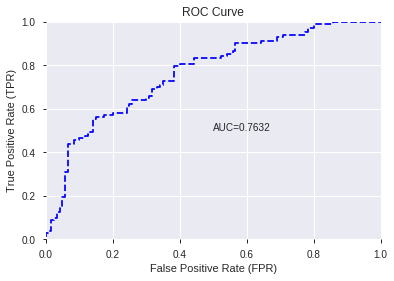

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


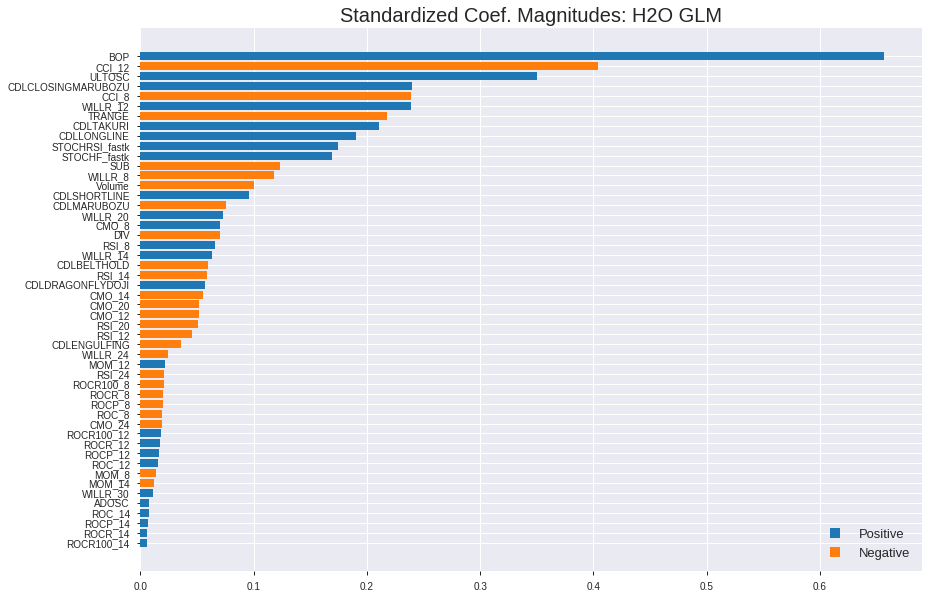

'log_likelihood'
--2019-08-26 18:21:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_182115_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_182115_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CCI_12',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'WILLR_12',
 'TRANGE',
 'CDLTAKURI',
 'CDLLONGLINE',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'SUB',
 'WILLR_8',
 'Volume',
 'CDLSHORTLINE',
 'CDLMARUBOZU',
 'WILLR_20',
 'CMO_8',
 'DIV',
 'RSI_8',
 'WILLR_14',
 'CDLBELTHOLD',
 'RSI_14',
 'CDLDRAGONFLYDOJI',
 'CMO_14',
 'CMO_20',
 'CMO_12',
 'RSI_20',
 'RSI_12',
 'CDLENGULFING',
 'WILLR_24',
 'MOM_12',
 'RSI_24',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'CMO_24',
 'ROCR100_12',
 'ROCR_12',
 'ROCP_12',
 'ROC_12',
 'MOM_8',
 'MOM_14',
 'WILLR_30',
 'ADOSC',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14']

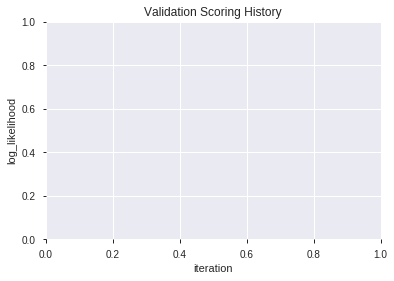

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190826_182125  0.793123  0.549395              0.274150  0.431197  0.185931
1  XGBoost_grid_1_AutoML_20190826_182125_model_6  0.785841  0.557590              0.270672  0.435056  0.189274
2  XGBoost_grid_1_AutoML_20190826_182125_model_7  0.785275  0.558890              0.274150  0.435790  0.189913
3  XGBoost_grid_1_AutoML_20190826_182125_model_5  0.782201  0.566803              0.278317  0.438538  0.192315
4               XGBoost_1_AutoML_20190826_182125  0.780259  0.561824              0.316626  0.437226  0.191166
5  XGBoost_grid_1_AutoML_20190826_182125_model_2  0.778964  0.564914              0.281108  0.437496  0.191403
6  XGBoost_grid_1_AutoML_20190826_182125_model_1  0.778398  0.559528              0.329086  0.436309  0.190365
7               XGBoost_2_AutoML_20190826_182125  0.776133  0.567571              0.311044  0.439894  0.193506
8  XGBoost_grid_1_AutoML_20190826_182125_model_4  0.773786  0.569190              0.329126  0.440391  0.193944
9  XGBoost_grid_1_AutoML_20190826_182125_model_3  0.773301  0.568500              0.328398  0.439750  0.193380

variable  relative_importance  scaled_importance  percentage
0                  BOP          1893.696167           1.000000    0.223581
1                  DIV           622.361694           0.328649    0.073480
2               TRANGE           409.263733           0.216119    0.048320
3               CCI_12           372.341370           0.196621    0.043961
4                  SUB           371.213287           0.196026    0.043828
5                CCI_8           346.177460           0.182805    0.040872
6         STOCHF_fastk           344.326385           0.181828    0.040653
7       STOCHRSI_fastk           323.113373           0.170626    0.038149
8               ULTOSC           298.656372           0.157711    0.035261
9               Volume           267.151184           0.141074    0.031541
10               ADOSC           241.371155           0.127460    0.028498
11  CDLCLOSINGMARUBOZU           213.467880           0.112726    0.025203
12             WILLR_8           191.592087           0.101174    0.022620
13         CDLLONGLINE           165.008545           0.087136    0.019482
14            WILLR_12           155.685196           0.082212    0.018381
15              MOM_14           154.246689           0.081453    0.018211
16              CMO_20           149.564789           0.078980    0.017658
17              ROC_14           147.831741           0.078065    0.017454
18            WILLR_20           141.055817           0.074487    0.016654
19        CDLSHORTLINE           138.922287           0.073360    0.016402
20              MOM_12           128.512894           0.067864    0.015173
21               CMO_8           116.438988           0.061488    0.013747
22               ROC_8           110.899765           0.058563    0.013093
23              CMO_24           106.241371           0.056103    0.012543
24              RSI_20           104.260139           0.055056    0.012310
25            WILLR_14           103.006088           0.054394    0.012161
26            WILLR_30            85.831757           0.045325    0.010134
27              ROC_12            85.171906           0.044977    0.010056
28           CDLTAKURI            77.801186           0.041084    0.009186
29             ROCP_14            67.556396           0.035674    0.007976
30              CMO_14            66.728523           0.035237    0.007878
31            WILLR_24            66.364639           0.035045    0.007835
32              CMO_12            56.306557           0.029734    0.006648
33              RSI_24            51.951805           0.027434    0.006134
34               MOM_8            51.933098           0.027424    0.006132
35               RSI_8            45.404758           0.023977    0.005361
36         CDLBELTHOLD            43.921059           0.023193    0.005186
37              RSI_12            36.265453           0.019151    0.004282
38             ROCP_12            23.787643           0.012561    0.002809
39              ROCR_8            20.053150           0.010589    0.002368
40              ROCP_8            18.040369           0.009527    0.002130
41    CDLDRAGONFLYDOJI            12.950435           0.006839    0.001529
42           ROCR100_8            11.977388           0.006325    0.001414
43             ROCR_12             9.194286           0.004855    0.001086
44              RSI_14             5.985622           0.003161    0.000707
45          ROCR100_14             5.880756           0.003105    0.000694
46             ROCR_14             4.368615           0.002307    0.000516
47          ROCR100_12             3.694519           0.001951    0.000436
48        CDLENGULFING             2.283519           0.001206    0.000270

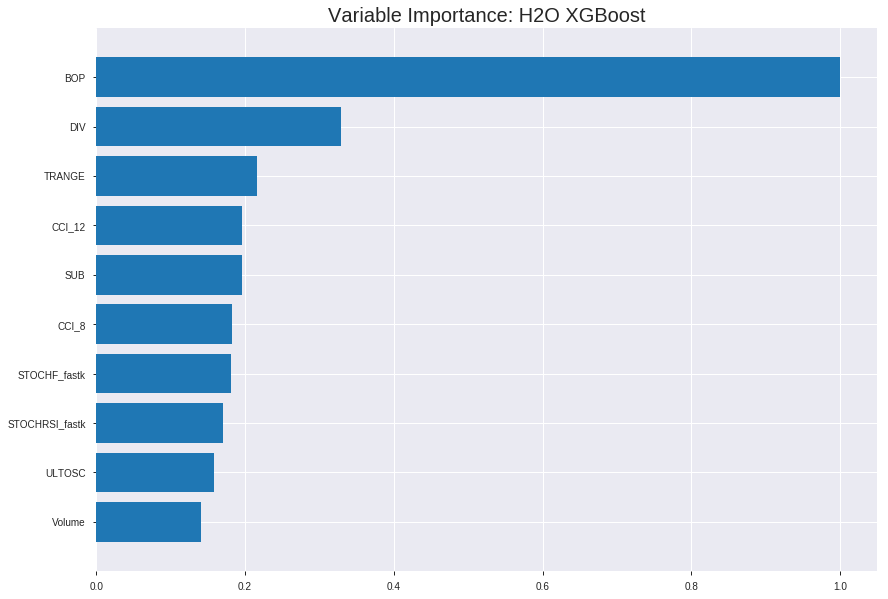

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190826_182125


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12667085676223303
RMSE: 0.3559084949284479
LogLoss: 0.41223632143122874
Mean Per-Class Error: 0.1553217893360962
AUC: 0.9246492267372592
pr_auc: 0.9258012340787031
Gini: 0.8492984534745185
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.446242980659008: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      636  153  0.1939   (153.0/789.0)
1      91   676  0.1186   (91.0/767.0)
Total  727  829  0.1568   (244.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446243     0.847118  219
max f2                       0.311555     0.898673  280
max f0point5                 0.600852     0.851514  155
max accuracy                 0.462557     0.844473  211
max precision                0.95776      1         0
max recall                   0.150444     1         361
max specificity              0.95776      1         0
max absolute_mcc             0.462557     0.689416  211
max min_per_class_accuracy   0.479922     0.840304  204
max mean_per_class_accuracy  0.462557     0.844678  211

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 49.38 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.932674           2.02868    2.02868            1                0.939286  1                           0.939286            0.0208605       0.0208605                  102.868   102.868
    2        0.0205656                   0.925095           2.02868    2.02868            1                0.928805  1                           0.934046            0.0208605       0.041721                   102.868   102.868
    3        0.0302057                   0.914536           2.02868    2.02868            1                0.920424  1                           0.929698            0.0195567       0.0612777                  102.868   102.868
    4        0.0404884                   0.905934           2.02868    2.02868            1                0.910094  1                           0.924719            0.0208605       0.0821382                  102.868   102.868
    5        0.0501285                   0.896421           2.02868    2.02868            1                0.901657  1                           0.920284            0.0195567       0.101695                   102.868   102.868
    6        0.100257                    0.858974           2.02868    2.02868            1                0.876975  1                           0.89863             0.101695        0.20339                    102.868   102.868
    7        0.150386                    0.814907           1.97667    2.01134            0.974359         0.833766  0.991453                    0.877008            0.0990874       0.302477                   97.6666   101.134
    8        0.200514                    0.773635           2.00267    2.00918            0.987179         0.792552  0.990385                    0.855894            0.100391        0.402868                   100.267   100.918
    9        0.300129                    0.66855            1.75383    1.92443            0.864516         0.72507   0.948608                    0.812473            0.174707        0.577575                   75.3829   92.4425
    10       0.400386                    0.575123           1.41748    1.79748            0.698718         0.621002  0.886035                    0.764528            0.142112        0.719687                   41.7477   79.7485
    11       0.5                         0.473328           1.26956    1.69231            0.625806         0.528434  0.83419                     0.717492            0.126467        0.846154                   26.9563   69.2308
    12       0.600257                    0.38667            0.793267   1.54215            0.391026         0.428281  0.760171                    0.669187            0.0795306       0.925684                   -20.6733  54.2147
    13       0.699871                    0.30179            0.45809    1.38785            0.225806         0.345473  0.684114                    0.623112            0.0456323       0.971317                   -54.191   38.785
    14       0.800129                    0.225991           0.20807    1.24002            0.102564         0.26549   0.611245                    0.578301            0.0208605       0.992177                   -79.193   24.0022
    15       0.899743                    0.161864           0.0523531  1.10853            0.0258065        0.196428  0.546429                    0.536022            0.00521512      0.997392                   -94.7647  10.853
    16       1                           0.0572982          0.0260088  1                  0.0128205        0.11489   0.492931                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1768643822895973
RMSE: 0.42055247269466545
LogLoss: 0.5285388359568806
Mean Per-Class Error: 0.25883124334070984
AUC: 0.8116957626424064
pr_auc: 0.7733679489102605
Gini: 0.6233915252848128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42954543232917786: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      168  81   0.3253   (81.0/249.0)
1      39   157  0.199    (39.0/196.0)
Total  207  238  0.2697   (120.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429545     0.723502  219
max f2                       0.221082     0.827556  333
max f0point5                 0.619758     0.722222  122
max accuracy                 0.441651     0.737079  205
max precision                0.940475     1         0
max recall                   0.122967     1         380
max specificity              0.940475     1         0
max absolute_mcc             0.43958      0.478935  207
max min_per_class_accuracy   0.456703     0.722892  195
max mean_per_class_accuracy  0.43958      0.741169  207

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 46.83 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.918127           1.81633    1.81633            0.8              0.931717  0.8                         0.931717            0.0204082       0.0204082                  81.6327   81.6327
    2        0.0202247                   0.906076           2.27041    2.01814            1                0.912624  0.888889                    0.923232            0.0204082       0.0408163                  127.041   101.814
    3        0.0314607                   0.888659           2.27041    2.10824            1                0.897324  0.928571                    0.913979            0.0255102       0.0663265                  127.041   110.824
    4        0.0404494                   0.875752           2.27041    2.14427            1                0.879419  0.944444                    0.906299            0.0204082       0.0867347                  127.041   114.427
    5        0.0516854                   0.868435           2.27041    2.17169            1                0.872862  0.956522                    0.89903             0.0255102       0.112245                   127.041   117.169
    6        0.101124                    0.818619           1.96081    2.06859            0.863636         0.837721  0.911111                    0.869057            0.0969388       0.209184                   96.0807   106.859
    7        0.150562                    0.756829           2.16721    2.10097            0.954545         0.784255  0.925373                    0.841211            0.107143        0.316327                   116.721   110.097
    8        0.2                         0.715677           1.65121    1.9898             0.727273         0.740339  0.876404                    0.816277            0.0816327       0.397959                   65.1206   98.9796
    9        0.301124                    0.607942           1.36224    1.77905            0.6              0.659182  0.783582                    0.763521            0.137755        0.535714                   36.2245   77.9051
    10       0.4                         0.515609           1.032      1.59439            0.454545         0.56191   0.702247                    0.713684            0.102041        0.637755                   3.20037   59.4388
    11       0.501124                    0.441546           1.31179    1.53736            0.577778         0.47301   0.67713                     0.665118            0.132653        0.770408                   31.1791   53.7362
    12       0.6                         0.371838           0.774003   1.41156            0.340909         0.415029  0.621723                    0.623905            0.0765306       0.846939                   -22.5997  41.1565
    13       0.698876                    0.307981           0.619202   1.29946            0.272727         0.338109  0.572347                    0.583471            0.0612245       0.908163                   -38.0798  29.9462
    14       0.8                         0.247032           0.403628   1.18622            0.177778         0.275906  0.522472                    0.544593            0.0408163       0.94898                    -59.6372  18.6224
    15       0.898876                    0.159982           0.464402   1.10682            0.204545         0.205702  0.4875                      0.507315            0.0459184       0.994898                   -53.5598  10.6824
    16       1                           0.0776336          0.0504535  1                  0.0222222        0.121421  0.440449                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:21:28  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.507069                         0.5                0.693147              0.5               0                    1                  0.559551
    2019-08-26 18:21:28  0.060 sec   5                  0.473332         0.640913            0.825809        0.782237           2.02868          0.268638                         0.47533            0.644723              0.806532          0.736906             2.27041            0.289888
    2019-08-26 18:21:28  0.099 sec   10                 0.453255         0.602335            0.842919        0.848711           2.02868          0.231362                         0.458923           0.612897              0.812351          0.778033             2.27041            0.278652
    2019-08-26 18:21:28  0.137 sec   15                 0.439523         0.575675            0.847929        0.851183           2.02868          0.237147                         0.448617           0.592358              0.809606          0.776027             2.27041            0.265169
    2019-08-26 18:21:28  0.179 sec   20                 0.427366         0.551823            0.854974        0.85678            2.02868          0.224293                         0.440978           0.576632              0.807557          0.773724             2.27041            0.283146
    2019-08-26 18:21:28  0.215 sec   25                 0.417899         0.533037            0.863091        0.866315           2.02868          0.220437                         0.435185           0.564573              0.810323          0.775502             2.27041            0.276404
    2019-08-26 18:21:28  0.254 sec   30                 0.408999         0.51536             0.871519        0.873749           2.02868          0.205656                         0.430306           0.554079              0.813499          0.778339             2.27041            0.305618
    2019-08-26 18:21:28  0.291 sec   35                 0.401618         0.500572            0.87926         0.881836           2.02868          0.197301                         0.427093           0.546891              0.814421          0.780089             2.27041            0.296629
    2019-08-26 18:21:28  0.331 sec   40                 0.395021         0.487451            0.884801        0.887265           2.02868          0.200514                         0.424304           0.540435              0.816204          0.783186             2.27041            0.283146
    2019-08-26 18:21:28  0.373 sec   45                 0.388339         0.474384            0.892067        0.894133           2.02868          0.191517                         0.423387           0.537723              0.814861          0.782                2.27041            0.28764
    2019-08-26 18:21:29  0.414 sec   50                 0.382681         0.463203            0.897888        0.898669           2.02868          0.187661                         0.422028           0.534363              0.815005          0.782147             2.27041            0.292135
    2019-08-26 18:21:29  0.454 sec   55                 0.378058         0.453976            0.90243         0.903897           2.02868          0.183805                         0.420197           0.530143              0.816736          0.

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ---------------------
BOP           1893.6961669921875     1.0                   0.22358057749443766
DIV           622.3616943359375      0.32864918099530854   0.07347957368000506
TRANGE        409.26373291015625     0.21611900580661875   0.048320012125767545
CCI_12        372.34136962890625     0.19662149404901993   0.04396074718729901
SUB           371.2132873535156      0.19602579010503277   0.04382755935548665
---           ---                    ---                   ---
RSI_14        5.985622406005859      0.003160814554276147  0.0007066967433978845
ROCR100_14    5.880756378173828      0.003105438179934854  0.00069431566164311
ROCR_14       4.36861515045166       0.00230692506358634   0.0005157836379530261
ROCR100_12    3.69451904296875       0.001950956604003092  0.0004361960041895982
CDLENGULFING  2.2835187911987305     0.001205852781983347  0.000269605261369111


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.7207207207207208)

('auc', 0.7931229773462783)

('logloss', 0.5493954632244253)

('mean_per_class_error', 0.26925566343042073)

('rmse', 0.43119677332614537)

('mse', 0.1859306573268792)

xgboost prediction progress: |████████████████████████████████████████████| 100%


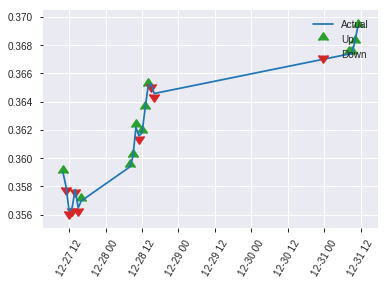


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1859306573268792
RMSE: 0.43119677332614537
LogLoss: 0.5493954632244253
Mean Per-Class Error: 0.26925566343042073
AUC: 0.7931229773462783
pr_auc: 0.7506192737468412
Gini: 0.5862459546925567
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3683502972126007: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   39   0.325    (39.0/120.0)
1      23   80   0.2233   (23.0/103.0)
Total  104  119  0.278    (62.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36835      0.720721  118
max f2                       0.168068     0.840198  194
max f0point5                 0.636786     0.721003  53
max accuracy                 0.419637     0.730942  102
max precision                0.943194     1         0
max recall                   0.127453     1         202
max specificity              0.943194     1         0
max absolute_mcc             0.413531     0.460521  106
max min_per_class_accuracy   0.413531     0.728155  106
max mean_per_class_accuracy  0.413531     0.730744  106

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 43.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.900028           2.16505    2.16505            1                0.917159  1                           0.917159            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.89448            2.16505    2.16505            1                0.897096  1                           0.909134            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.88362            1.08252    1.85576            0.5              0.89301   0.857143                    0.904527            0.00970874      0.0582524                  8.25243   85.5756
    4        0.0403587                   0.862255           2.16505    1.92449            1                0.876682  0.888889                    0.898339            0.0194175       0.0776699                  116.505   92.4488
    5        0.0538117                   0.847569           1.44337    1.80421            0.666667         0.852085  0.833333                    0.886776            0.0194175       0.0970874                  44.3366   80.4207
    6        0.103139                    0.793878           1.96823    1.88265            0.909091         0.817079  0.869565                    0.853443            0.0970874       0.194175                   96.8226   88.2651
    7        0.152466                    0.755595           1.96823    1.91034            0.909091         0.775196  0.882353                    0.828128            0.0970874       0.291262                   96.8226   91.0337
    8        0.201794                    0.702804           1.96823    1.92449            0.909091         0.730168  0.888889                    0.804182            0.0970874       0.38835                    96.8226   92.4488
    9        0.300448                    0.571333           0.984113   1.61571            0.454545         0.631619  0.746269                    0.747519            0.0970874       0.485437                   -1.5887   61.5708
    10       0.399103                    0.456049           1.47617    1.58122            0.681818         0.509434  0.730337                    0.688667            0.145631        0.631068                   47.6169   58.1215
    11       0.502242                    0.401261           1.03546    1.46914            0.478261         0.426298  0.678571                    0.634788            0.106796        0.737864                   3.5458    46.914
    12       0.600897                    0.323127           0.78729    1.35719            0.363636         0.356263  0.626866                    0.58906             0.0776699       0.815534                   -21.271   35.7195
    13       0.699552                    0.265353           0.688879   1.26294            0.318182         0.289471  0.583333                    0.54681             0.0679612       0.883495                   -31.1121  26.2945
    14       0.798206                    0.209753           0.688879   1.19199            0.318182         0.236652  0.550562                    0.508476            0.0679612       0.951456                   -31.1121  19.1993
    15       0.896861                    0.133654           0.393645   1.10417            0.181818         0.180261  0.51                        0.472372            0.038835        0.990291                   -60.6355  10.4175
    16       1                           0.0686985          0.0941325  1                  0.0434783        0.102487  0.461883                    

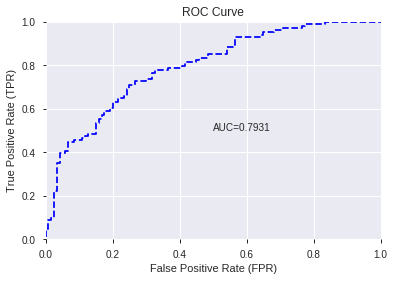

This function is available for GLM models only


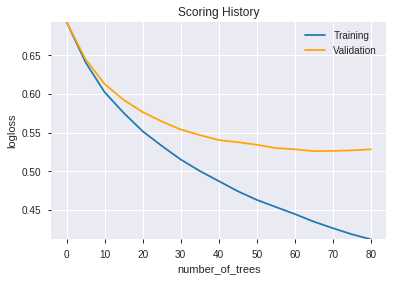

--2019-08-26 18:21:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.84
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.84|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190826_182125',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190826_182125',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_8cec',
   'type

['BOP',
 'DIV',
 'TRANGE',
 'CCI_12',
 'SUB',
 'CCI_8',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'Volume',
 'ADOSC',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'CDLLONGLINE',
 'WILLR_12',
 'MOM_14',
 'CMO_20',
 'ROC_14',
 'WILLR_20',
 'CDLSHORTLINE',
 'MOM_12',
 'CMO_8',
 'ROC_8',
 'CMO_24',
 'RSI_20',
 'WILLR_14',
 'WILLR_30',
 'ROC_12',
 'CDLTAKURI',
 'ROCP_14',
 'CMO_14',
 'WILLR_24',
 'CMO_12',
 'RSI_24',
 'MOM_8',
 'RSI_8',
 'CDLBELTHOLD',
 'RSI_12',
 'ROCP_12',
 'ROCR_8',
 'ROCP_8',
 'CDLDRAGONFLYDOJI',
 'ROCR100_8',
 'ROCR_12',
 'RSI_14',
 'ROCR100_14',
 'ROCR_14',
 'ROCR100_12',
 'CDLENGULFING']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

80

['BBANDS_middleband_14_6_3',
 'BBANDS_middleband_14_7_3',
 'BBANDS_upperband_14_7_4',
 'BBANDS_upperband_20_0_5',
 'BBANDS_middleband_20_1_2',
 'BBANDS_upperband_20_1_3',
 'BBANDS_upperband_20_1_4',
 'BBANDS_middleband_20_3_5',
 'MAVP_20_5',
 'BBANDS_upperband_20_6_2',
 'MA_24_1',
 'BBANDS_upperband_24_1_2',
 'BBANDS_lowerband_24_3_5',
 'BOP',
 'ADXR_8',
 'aroonup_8',
 'AROONOSC_8',
 'CCI_8',
 'MACDFIX_signal_8',
 'MINUS_DM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'WILLR_8',
 'aroondown_12',
 'aroonup_12',
 'DX_12',
 'MFI_12',
 'MOM_12',
 'PLUS_DM_12',
 'ROCP_12',
 'RSI_12',
 'WILLR_12',
 'aroondown_14',
 'aroonup_14',
 'CMO_14',
 'MINUS_DI_14',
 'PLUS_DI_14',
 'PLUS_DM_14',
 'ROCR_14',
 'WILLR_14',
 'aroondown_20',
 'aroonup_20',
 'AROONOSC_20',
 'CCI_20',
 'MACDFIX_hist_20',
 'ADX_24',
 'CCI_24',
 'DX_24',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'RSI_24',
 'WILLR_24',
 'aroondown_30',
 'aroonup_30',
 'MINUS_DM_30',
 'PLUS_DM_30',
 'ROC_30',
 'PPO',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fa

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190826_182238  0.775324  0.715540              0.268002  0.475423  0.226027
1  DeepLearning_grid_1_AutoML_20190826_182238_model_5  0.757120  0.585504              0.295024  0.447936  0.200647
2  DeepLearning_grid_1_AutoML_20190826_182238_model_3  0.751942  0.631747              0.319337  0.460374  0.211945
3  DeepLearning_grid_1_AutoML_20190826_182238_model_6  0.751618  0.591699              0.333252  0.450664  0.203098
4  DeepLearning_grid_1_AutoML_20190826_182238_model_9  0.748139  0.584524              0.379854  0.449438  0.201995
5  DeepLearning_grid_1_AutoML_20190826_182238_model_8  0.743770  0.598397              0.326254  0.454690  0.206743
6  DeepLearning_grid_1_AutoML_20190826_182238_model_7  0.733091  0.621494              0.344377  0.463536  0.214866
7  DeepLearning_grid_1_AutoML_20190826_182238_model_4  0.715210  1.346097              0.362419  0.576346  0.332175
8  DeepLearning_grid_1_AutoML_20190826_182238_model_2  0.707282  1.264951              0.356189  0.579602  0.335939
9  DeepLearning_grid_1_AutoML_20190826_182238_model_1  0.635113  1.271833              0.430542  0.578554  0.334725

variable  relative_importance  scaled_importance  percentage
0   BBANDS_middleband_20_3_5             1.000000           1.000000    0.018196
1                    WILLR_8             0.937314           0.937314    0.017056
2            MACDFIX_hist_20             0.923449           0.923449    0.016803
3                        BOP             0.921940           0.921940    0.016776
4             CDLSPINNINGTOP             0.913461           0.913461    0.016622
..                       ...                  ...                ...         ...
75                MINUS_DM_8             0.455541           0.455541    0.008289
76              HT_TRENDMODE             0.448147           0.448147    0.008155
77                AROONOSC_8             0.429770           0.429770    0.007820
78                    CMO_14             0.405233           0.405233    0.007374
79                   CDLDOJI             0.314997           0.314997    0.005732

[80 rows x 4 columns]

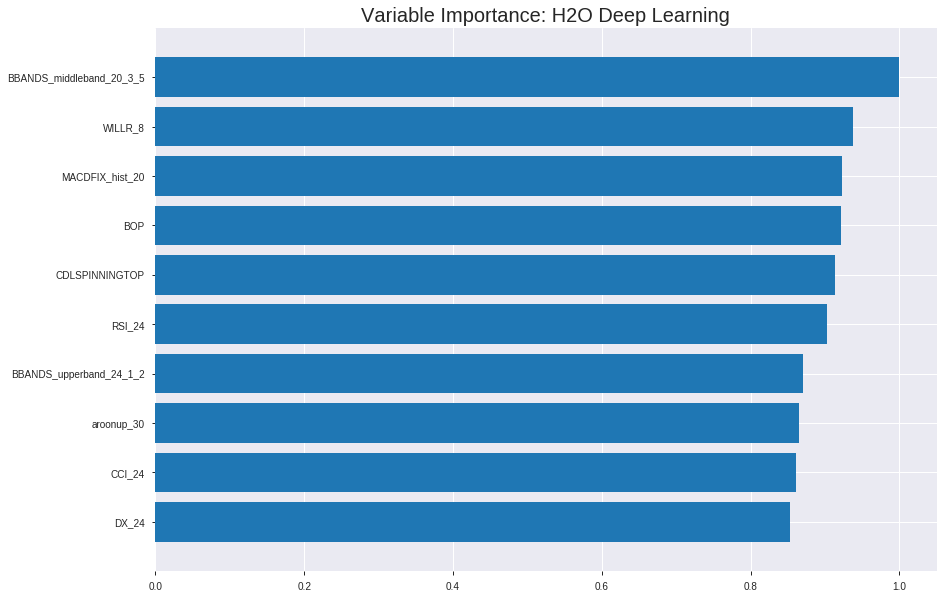

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190826_182238


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19806478823518958
RMSE: 0.4450447036368252
LogLoss: 0.5841597987925993
Mean Per-Class Error: 0.2724026419328346
AUC: 0.7971199495012087
pr_auc: 0.788498865206293
Gini: 0.5942398990024174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18366022480104174: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      391  398   0.5044   (398.0/789.0)
1      82   685   0.1069   (82.0/767.0)
Total  473  1083  0.3085   (480.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.18366      0.740541  302
max f2                       0.071232     0.842697  363
max f0point5                 0.38149      0.729019  213
max accuracy                 0.357801     0.727506  224
max precision                0.990176     1         0
max recall                   0.0158061    1         393
max specificity              0.990176     1         0
max absolute_mcc             0.329146     0.455159  235
max min_per_class_accuracy   0.340811     0.724902  231
max mean_per_class_accuracy  0.329146     0.727597  235

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 38.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.962736           1.90189   1.90189            0.9375           0.974563   0.9375                      0.974563            0.0195567       0.0195567                  90.189    90.189
    2        0.0205656                   0.93914            1.90189   1.90189            0.9375           0.950285   0.9375                      0.962424            0.0195567       0.0391134                  90.189    90.189
    3        0.0302057                   0.917547           1.89344   1.89919            0.933333         0.924576   0.93617                     0.950345            0.0182529       0.0573664                  89.3438   89.9193
    4        0.0404884                   0.900974           1.7751    1.86768            0.875            0.907371   0.920635                    0.939431            0.0182529       0.0756193                  77.5098   86.7677
    5        0.0501285                   0.878673           1.89344   1.87263            0.933333         0.891494   0.923077                    0.930212            0.0182529       0.0938722                  89.3438   87.2631
    6        0.100257                    0.80108            1.87263   1.87263            0.923077         0.841637   0.923077                    0.885925            0.0938722       0.187744                   87.2631   87.2631
    7        0.150386                    0.700336           1.63855   1.7946             0.807692         0.75201    0.884615                    0.841287            0.0821382       0.269883                   63.8552   79.4604
    8        0.200514                    0.639354           1.56053   1.73608            0.769231         0.667795   0.855769                    0.797914            0.0782269       0.34811                    56.0526   73.6085
    9        0.300129                    0.520721           1.38736   1.62034            0.683871         0.576972   0.798715                    0.724582            0.138201        0.48631                    38.7358   62.034
    10       0.400386                    0.417535           1.26142   1.53047            0.621795         0.467408   0.754414                    0.660185            0.126467        0.612777                   26.1425   53.0467
    11       0.5                         0.332014           1.15177   1.45502            0.567742         0.377042   0.717224                    0.603775            0.114733        0.72751                    15.1769   45.502
    12       0.600257                    0.247646           0.819276  1.34884            0.403846         0.289583   0.664882                    0.551297            0.0821382       0.809648                   -18.0724  34.8835
    13       0.699871                    0.180233           0.83765   1.27608            0.412903         0.213289   0.629017                    0.503188            0.083442        0.89309                    -16.235   27.6077
    14       0.800129                    0.120883           0.468158  1.17484            0.230769         0.150423   0.579116                    0.458986            0.0469361       0.940026                   -53.1842  17.4844
    15       0.899743                    0.0642736          0.405737  1.08969            0.2              0.0923526  0.537143                    0.418394            0.0404172       0.980443                   -59.4263  8.96927
    16       1                           0.00118973         0.195066  1                  0.0961538        0.0388132  0.492931                    0.3



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23095629967580164
RMSE: 0.48057912946340237
LogLoss: 0.6639136409924381
Mean Per-Class Error: 0.3422465371690846
AUC: 0.7006085566756823
pr_auc: 0.6401531883190117
Gini: 0.4012171133513647
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30958194971078545: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  143  0.5743   (143.0/249.0)
1      26   170  0.1327   (26.0/196.0)
Total  132  313  0.3798   (169.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309582     0.667976  285
max f2                       0.11857      0.814442  365
max f0point5                 0.41938      0.602894  238
max accuracy                 0.563196     0.647191  173
max precision                0.998513     1         0
max recall                   0.0822962    1         378
max specificity              0.998513     1         0
max absolute_mcc             0.343201     0.318849  270
max min_per_class_accuracy   0.503718     0.638554  196
max mean_per_class_accuracy  0.41938      0.657753  238

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 50.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.989069           2.27041   2.27041            1                0.99253    1                           0.99253             0.0255102       0.0255102                  127.041   127.041
    2        0.0202247                   0.982132           1.70281   2.01814            0.75             0.986033   0.888889                    0.989642            0.0153061       0.0408163                  70.2806   101.814
    3        0.0314607                   0.97619            2.27041   2.10824            1                0.978991   0.928571                    0.985838            0.0255102       0.0663265                  127.041   110.824
    4        0.0404494                   0.961026           2.27041   2.14427            1                0.971215   0.944444                    0.982589            0.0204082       0.0867347                  127.041   114.427
    5        0.0516854                   0.948299           1.36224   1.97427            0.6              0.953325   0.869565                    0.976227            0.0153061       0.102041                   36.2245   97.4268
    6        0.101124                    0.891371           1.54801   1.76587            0.681818         0.915361   0.777778                    0.946471            0.0765306       0.178571                   54.8006   76.5873
    7        0.150562                    0.8355             1.1352    1.55879            0.5              0.858732   0.686567                    0.917661            0.0561224       0.234694                   13.5204   55.8788
    8        0.2                         0.790742           1.2384    1.47959            0.545455         0.813121   0.651685                    0.89182             0.0612245       0.295918                   23.8404   47.9592
    9        0.301124                    0.679289           1.26134   1.4063             0.555556         0.726759   0.619403                    0.836389            0.127551        0.423469                   26.1338   40.6298
    10       0.4                         0.589713           1.1352    1.33929            0.5              0.636156   0.589888                    0.786893            0.112245        0.535714                   13.5204   33.9286
    11       0.501124                    0.485621           1.16043   1.30319            0.511111         0.540333   0.573991                    0.737139            0.117347        0.653061                   16.0431   30.3194
    12       0.6                         0.410439           1.1868    1.28401            0.522727         0.451952   0.565543                    0.690142            0.117347        0.770408                   18.6804   28.4014
    13       0.698876                    0.309938           0.877203  1.22646            0.386364         0.361241   0.540193                    0.643609            0.0867347       0.857143                   -12.2797  22.6458
    14       0.8                         0.221532           0.554989  1.14158            0.244444         0.267896   0.502809                    0.596117            0.0561224       0.913265                   -44.5011  14.1582
    15       0.898876                    0.127755           0.670802  1.0898             0.295455         0.183255   0.48                        0.550702            0.0663265       0.979592                   -32.9198  8.97959
    16       1                           0.0132397          0.201814  1                  0.0888889        0.0780341  0.440449                   


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:22:38  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 18:22:38  0.061 sec   77800 obs/sec     1         1             1556       0.506766         0.776364            -0.027451      0.691941        0.676355           1.90189          0.381105                         0.51992            0.798362              -0.096825        0.649557          0.604809             1.81633            0.444944
    2019-08-26 18:22:38  0.249 sec   81465 obs/sec     10        10            15560      0.445045         0.58416             0.207582       0.79712         0.788499           1.90189          0.308483                         0.480579           0.663914              0.0628817        0.700609          0.640153             2.27041            0.379775

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BBANDS_middleband_20_3_5  1.0                    1.0                  0.01819629557031009
WILLR_8                   0.9373140931129456     0.9373140931129456   0.01705564428050031
MACDFIX_hist_20           0.9234491586685181     0.9234491586685181   0.016803353835286534
BOP                       0.921940267086029      0.921940267086029    0.01677589759806801
CDLSPINNINGTOP            0.9134607315063477     0.9134607315063477   0.016621601462361166
---                       ---                    ---                  ---
MINUS_DM_8                0.4555407464504242     0.4555407464504242   0.008289154066731605
HT_TRENDMODE              0.44814687967300415    0.44814687967300415  0.008154613081442174
AROONOSC_8                0.42977043986320496    0.42977043986320496  0.007820229951133056
CMO_14                    0.4052329957485199     0.4052329957485199   0.00737373936548228
CDLDOJI                   0.3149973452091217     0.3149973452091217   0.005731784797288179


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7509881422924901)

('auc', 0.7753236245954692)

('logloss', 0.7155397130013313)

('mean_per_class_error', 0.2680016181229774)

('rmse', 0.4754226247739256)

('mse', 0.22602667214692887)

deeplearning prediction progress: |███████████████████████████████████████| 100%


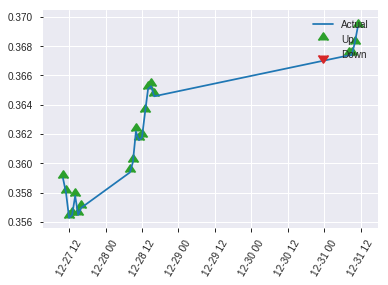


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22602667214692887
RMSE: 0.4754226247739256
LogLoss: 0.7155397130013313
Mean Per-Class Error: 0.2680016181229774
AUC: 0.7753236245954692
pr_auc: 0.7279708744528504
Gini: 0.5506472491909384
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46782644576920224: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   55   0.4583   (55.0/120.0)
1      8    95   0.0777   (8.0/103.0)
Total  73   150  0.2825   (63.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467826     0.750988  149
max f2                       0.462775     0.849558  152
max f0point5                 0.763052     0.677618  95
max accuracy                 0.467826     0.717489  149
max precision                0.997905     1         0
max recall                   0.0753063    1         215
max specificity              0.997905     1         0
max absolute_mcc             0.467826     0.492966  149
max min_per_class_accuracy   0.704944     0.7       108
max mean_per_class_accuracy  0.467826     0.731998  149

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 62.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.996825           2.16505   2.16505            1                0.997228   1                           0.997228            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.995381           2.16505   2.16505            1                0.996166   1                           0.996803            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.993679           2.16505   2.16505            1                0.995045   1                           0.996301            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.992285           2.16505   2.16505            1                0.992742   1                           0.99551             0.0194175       0.0873786                  116.505   116.505
    5        0.0538117                   0.991367           0.721683  1.80421            0.333333         0.991925   0.833333                    0.994614            0.00970874      0.0970874                  -27.8317  80.4207
    6        0.103139                    0.985344           2.16505   1.97678            1                0.988613   0.913043                    0.991744            0.106796        0.203883                   116.505   97.6783
    7        0.152466                    0.972563           1.18094   1.7193             0.545455         0.977877   0.794118                    0.987257            0.0582524       0.262136                   18.0936   71.9303
    8        0.201794                    0.948922           1.7714    1.73204            0.818182         0.961611   0.8                         0.980988            0.0873786       0.349515                   77.1403   73.2039
    9        0.300448                    0.896207           1.18094   1.55108            0.545455         0.919096   0.716418                    0.960665            0.116505        0.466019                   18.0936   55.108
    10       0.399103                    0.789902           1.18094   1.45958            0.545455         0.83961    0.674157                    0.930742            0.116505        0.582524                   18.0936   45.9583
    11       0.502242                    0.682946           1.22372   1.41115            0.565217         0.74302    0.651786                    0.892192            0.126214        0.708738                   22.3723   41.1148
    12       0.600897                    0.555414           1.18094   1.37335            0.545455         0.610746   0.634328                    0.845984            0.116505        0.825243                   18.0936   37.3352
    13       0.699552                    0.451301           1.08252   1.33234            0.5              0.497185   0.615385                    0.796794            0.106796        0.932039                   8.25243   33.2338
    14       0.798206                    0.3039             0.295234  1.20416            0.136364         0.386628   0.55618                     0.7461              0.0291262       0.961165                   -70.4766  20.4156
    15       0.896861                    0.127136           0.196823  1.09335            0.0909091        0.219026   0.505                       0.688122            0.0194175       0.980583                   -80.3177  9.33495
    16       1                           0.0276282          0.188265  1                  0.0869565        0.0847024  0.461883                    

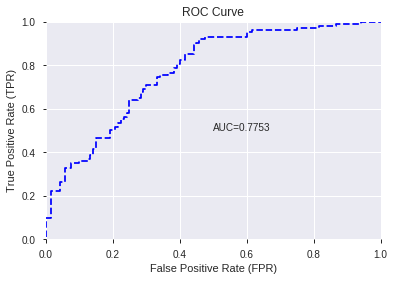

This function is available for GLM models only


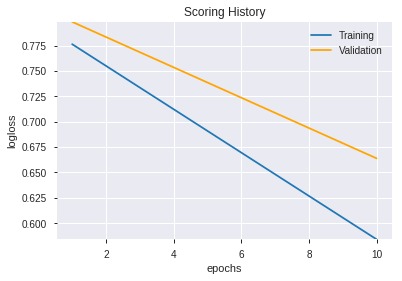

--2019-08-26 18:30:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190826_182238',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190826_182238',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_98_sid_8cec'

['BBANDS_middleband_20_3_5',
 'WILLR_8',
 'MACDFIX_hist_20',
 'BOP',
 'CDLSPINNINGTOP',
 'RSI_24',
 'BBANDS_upperband_24_1_2',
 'aroonup_30',
 'CCI_24',
 'DX_24',
 'CDLLONGLINE',
 'AROONOSC_20',
 'BBANDS_middleband_14_6_3',
 'MAVP_20_5',
 'ADXR_8',
 'ROCR_24',
 'ROCP_8',
 'HT_DCPERIOD',
 'aroondown_30',
 'BBANDS_upperband_20_0_5',
 'PLUS_DM_30',
 'NATR_20',
 'aroondown_20',
 'BBANDS_upperband_14_7_4',
 'TRANGE',
 'ROCR_14',
 'aroonup_12',
 'MACDFIX_signal_8',
 'CDLCLOSINGMARUBOZU',
 'RSI_12',
 'MFI_12',
 'CCI_20',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHRSI_fastk',
 'BBANDS_middleband_20_1_2',
 'MINUS_DI_14',
 'BBANDS_upperband_20_1_4',
 'ROCP_24',
 'ADOSC',
 'PLUS_DM_12',
 'CDLSHORTLINE',
 'HT_PHASOR_inphase',
 'ROC_24',
 'ROCR_8',
 'aroondown_12',
 'aroonup_20',
 'ADX_24',
 'ROCP_12',
 'NATR_12',
 'ROC_30',
 'ULTOSC',
 'MINUS_DM_30',
 'BBANDS_middleband_14_7_3',
 'MOM_12',
 'CCI_8',
 'PLUS_DI_14',
 'PPO',
 'aroondown_14',
 'aroonup_14',
 'WILLR_14',
 'ROC_8',
 'LINEARREG_SLOPE_8',
 'B

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_183040_model_1  0.760841  0.585703              0.293649  0.448723  0.201352

variable  relative_importance  scaled_importance  percentage
0    STOCH_slowk             0.597265           1.000000    0.061896
1         TRANGE             0.591686           0.990659    0.061318
2         ULTOSC             0.458517           0.767696    0.047518
3            BOP             0.444347           0.743970    0.046049
4   STOCHF_fastk             0.443817           0.743083    0.045994
..           ...                  ...                ...         ...
75       ROCR_14             0.006767           0.011330    0.000701
76         ROC_8             0.006281           0.010517    0.000651
77   LINEARREG_8             0.005284           0.008846    0.000548
78        ROCP_8             0.004256           0.007125    0.000441
79        ROCR_8             0.004188           0.007012    0.000434

[80 rows x 4 columns]

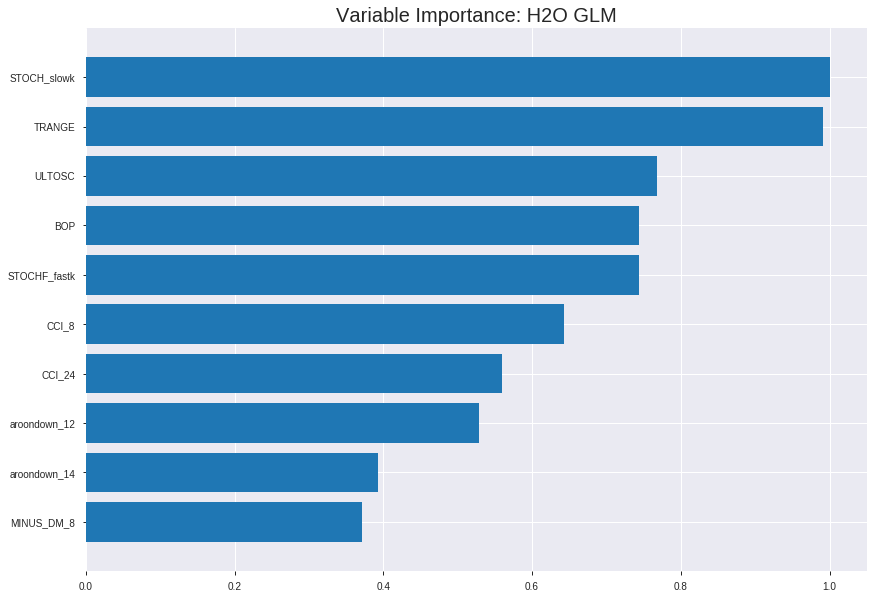

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_183040_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18579157571323143
RMSE: 0.43103546920553004
LogLoss: 0.5518868678098593
Null degrees of freedom: 1555
Residual degrees of freedom: 1475
Null deviance: 2156.7629615535493
Residual deviance: 1717.4719326242823
AIC: 1879.4719326242823
AUC: 0.7933895495924239
pr_auc: 0.7797554301466366
Gini: 0.5867790991848478
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3757413261876351: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      430  359   0.455    (359.0/789.0)
1      104  663   0.1356   (104.0/767.0)
Total  534  1022  0.2976   (463.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375741     0.741196  250
max f2                       0.217058     0.845731  320
max f0point5                 0.567493     0.724947  162
max accuracy                 0.500106     0.720437  194
max precision                0.959732     1         0
max recall                   0.0449533    1         389
max specificity              0.959732     1         0
max absolute_mcc             0.500106     0.441087  194
max min_per_class_accuracy   0.504635     0.716096  192
max mean_per_class_accuracy  0.500106     0.720554  194

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 49.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.925843           1.90189   1.90189            0.9375           0.939671   0.9375                      0.939671            0.0195567       0.0195567                  90.189    90.189
    2        0.0205656                   0.914901           2.02868   1.96529            1                0.921657   0.96875                     0.930664            0.0208605       0.0404172                  102.868   96.5287
    3        0.0302057                   0.901445           1.4877    1.81287            0.733333         0.908187   0.893617                    0.92349             0.0143416       0.0547588                  48.7701   81.2866
    4        0.0404884                   0.884892           1.7751    1.80327            0.875            0.893124   0.888889                    0.915778            0.0182529       0.0730117                  77.5098   80.3274
    5        0.0501285                   0.872924           1.75819   1.7946             0.866667         0.877417   0.884615                    0.908401            0.0169492       0.0899609                  75.8192   79.4604
    6        0.100257                    0.822636           1.7946    1.7946             0.884615         0.848178   0.884615                    0.87829             0.0899609       0.179922                   79.4604   79.4604
    7        0.150386                    0.781886           1.7946    1.7946             0.884615         0.799816   0.884615                    0.852132            0.0899609       0.269883                   79.4604   79.4604
    8        0.200514                    0.734874           1.58653   1.74259            0.782051         0.754002   0.858974                    0.827599            0.0795306       0.349413                   58.6534   74.2587
    9        0.300129                    0.654278           1.41353   1.63337            0.696774         0.694165   0.805139                    0.783311            0.140808        0.490222                   41.3534   63.3372
    10       0.400386                    0.57179            1.24842   1.53698            0.615385         0.610526   0.757624                    0.740046            0.125163        0.615385                   24.842    53.698
    11       0.5                         0.503182           1.07324   1.44459            0.529032         0.537862   0.712082                    0.699765            0.10691         0.722295                   7.32388   44.4589
    12       0.600257                    0.420219           0.94932   1.36187            0.467949         0.460841   0.671306                    0.659859            0.095176        0.817471                   -5.06803  36.1868
    13       0.699871                    0.337932           0.706767  1.26863            0.348387         0.380094   0.625344                    0.620039            0.0704042       0.887875                   -29.3233  26.8626
    14       0.800129                    0.253589           0.546184  1.1781             0.269231         0.297959   0.580723                    0.579682            0.0547588       0.942634                   -45.3816  17.8103
    15       0.899743                    0.147955           0.353384  1.08679            0.174194         0.202483   0.535714                    0.537921            0.0352021       0.977836                   -64.6616  8.67946
    16       1                           0.000494414        0.221074  1                  0.108974         0.0891707  0.492931                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18860469527246393
RMSE: 0.43428642077834295
LogLoss: 0.5530007793017074
Null degrees of freedom: 444
Residual degrees of freedom: 364
Null deviance: 615.4911432999108
Residual deviance: 492.17069357851966
AIC: 654.1706935785196
AUC: 0.7928448487828866
pr_auc: 0.7486129526689068
Gini: 0.5856896975657733
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34618456645099277: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  129  0.5181   (129.0/249.0)
1      21   175  0.1071   (21.0/196.0)
Total  141  304  0.3371   (150.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346185     0.7       272
max f2                       0.226545     0.829732  334
max f0point5                 0.667891     0.720899  125
max accuracy                 0.667891     0.734831  125
max precision                0.981973     1         0
max recall                   0.117315     1         371
max specificity              0.981973     1         0
max absolute_mcc             0.667891     0.461445  125
max min_per_class_accuracy   0.534657     0.698795  189
max mean_per_class_accuracy  0.591272     0.727758  164

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.92037            2.27041   2.27041            1                0.941325   1                           0.941325            0.0255102       0.0255102                  127.041   127.041
    2        0.0202247                   0.898207           2.27041   2.27041            1                0.912343   1                           0.928444            0.0204082       0.0459184                  127.041   127.041
    3        0.0314607                   0.88908            1.81633   2.10824            0.8              0.892383   0.928571                    0.915565            0.0204082       0.0663265                  81.6327   110.824
    4        0.0404494                   0.880549           1.70281   2.01814            0.75             0.885813   0.888889                    0.908954            0.0153061       0.0816327                  70.2806   101.814
    5        0.0516854                   0.87019            2.27041   2.07298            1                0.875117   0.913043                    0.901598            0.0255102       0.107143                   127.041   107.298
    6        0.101124                    0.821164           1.96081   2.01814            0.863636         0.845812   0.888889                    0.874325            0.0969388       0.204082                   96.0807   101.814
    7        0.150562                    0.792828           1.75441   1.93154            0.772727         0.807987   0.850746                    0.852542            0.0867347       0.290816                   75.4406   93.1541
    8        0.2                         0.743644           1.65121   1.86224            0.727273         0.761508   0.820225                    0.830039            0.0816327       0.372449                   65.1206   86.2245
    9        0.301124                    0.680743           1.56406   1.76211            0.688889         0.715742   0.776119                    0.791656            0.158163        0.530612                   56.4059   76.2108
    10       0.4                         0.609998           1.1868    1.6199             0.522727         0.644193   0.713483                    0.755204            0.117347        0.647959                   18.6804   61.9898
    11       0.501124                    0.513191           0.807256  1.45591            0.355556         0.558033   0.641256                    0.715416            0.0816327       0.729592                   -19.2744  45.5912
    12       0.6                         0.428819           0.825603  1.35204            0.363636         0.470501   0.595506                    0.675056            0.0816327       0.811224                   -17.4397  35.2041
    13       0.698876                    0.338468           0.928803  1.29216            0.409091         0.381883   0.569132                    0.633578            0.0918367       0.903061                   -7.11967  29.2162
    14       0.8                         0.266765           0.504535  1.1926             0.222222         0.303677   0.525281                    0.591877            0.0510204       0.954082                   -49.5465  19.2602
    15       0.898876                    0.154905           0.361201  1.10115            0.159091         0.211909   0.485                       0.55008             0.0357143       0.989796                   -63.8799  10.1148
    16       1                           0.0113312          0.100907  1                  0.0444444        0.0915878  0.440449                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 18:30:40  0.000 sec   2            .2E2      81            1.366495756908357   1.3674611520710345
     2019-08-26 18:30:40  0.016 sec   4            .13E2     81            1.3573103724996236  1.3598821419550937
     2019-08-26 18:30:40  0.033 sec   6            .78E1     81            1.34490249472516    1.3492814300884952
     2019-08-26 18:30:40  0.050 sec   8            .48E1     81            1.3286801503750791  1.334742358375386
     2019-08-26 18:30:40  0.068 sec   10           .3E1      81            1.3083883978979753  1.3154164680168923
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 18:30:41  0.334 sec   40           .24E-2    81            1.1021584683763999  1.1061816556899995
     2019-08-26 18:30:41  0.350 sec   42           .15E-2    81            1.100979177038591   1.106419577601121
     2019-08-26 18:30:41  0.369 sec   44           .91E-3    81            1.1000597239374592  1.1066880497600278
     2019-08-26 18:30:41  0.390 sec   46           .57E-3    81            1.0993430282815788  1.107138196756406
     2019-08-26 18:30:41  0.407 sec   48           .35E-3    81            1.098779185187988   1.1077210872236374


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6995515695067265)

('F1', 0.721311475409836)

('auc', 0.7608414239482201)

('logloss', 0.5857026717660219)

('mean_per_class_error', 0.29364886731391593)

('rmse', 0.448722907734821)

('mse', 0.20135224792599266)

glm prediction progress: |████████████████████████████████████████████████| 100%


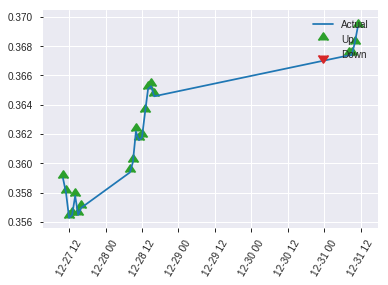


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20135224792599266
RMSE: 0.448722907734821
LogLoss: 0.5857026717660219
Null degrees of freedom: 222
Residual degrees of freedom: 142
Null deviance: 308.7074742286341
Residual deviance: 261.22339160764574
AIC: 423.22339160764574
AUC: 0.7608414239482201
pr_auc: 0.6982208001982285
Gini: 0.5216828478964401
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39233376206121234: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   53   0.4417   (53.0/120.0)
1      15   88   0.1456   (15.0/103.0)
Total  82   141  0.3049   (68.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392334     0.721311  140
max f2                       0.2043       0.847315  183
max f0point5                 0.63947      0.687961  75
max accuracy                 0.63947      0.699552  75
max precision                0.952512     1         0
max recall                   0.107704     1         208
max specificity              0.952512     1         0
max absolute_mcc             0.392334     0.426707  140
max min_per_class_accuracy   0.50771      0.679612  107
max mean_per_class_accuracy  0.392334     0.706351  140

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 49.84 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.930237           1.44337    1.44337            0.666667         0.938334   0.666667                    0.938334            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.917896           2.16505    1.73204            1                0.923452   0.8                         0.932381            0.0194175       0.038835                   116.505   73.2039
    3        0.0313901                   0.914897           2.16505    1.85576            1                0.916351   0.857143                    0.927801            0.0194175       0.0582524                  116.505   85.5756
    4        0.0403587                   0.910563           2.16505    1.92449            1                0.913737   0.888889                    0.924676            0.0194175       0.0776699                  116.505   92.4488
    5        0.0538117                   0.904972           1.44337    1.80421            0.666667         0.907321   0.833333                    0.920337            0.0194175       0.0970874                  44.3366   80.4207
    6        0.103139                    0.857705           1.7714     1.78852            0.818182         0.880304   0.826087                    0.901191            0.0873786       0.184466                   77.1403   78.8518
    7        0.152466                    0.806876           1.57458    1.7193             0.727273         0.841081   0.794118                    0.881743            0.0776699       0.262136                   57.4581   71.9303
    8        0.201794                    0.762524           1.37776    1.63581            0.636364         0.782346   0.755556                    0.857446            0.0679612       0.330097                   37.7758   63.5814
    9        0.300448                    0.675703           1.57458    1.61571            0.727273         0.713493   0.746269                    0.810178            0.15534         0.485437                   57.4581   61.5708
    10       0.399103                    0.589754           0.984113   1.45958            0.454545         0.62735    0.674157                    0.764984            0.0970874       0.582524                   -1.5887   45.9583
    11       0.502242                    0.495976           1.12959    1.39182            0.521739         0.5341     0.642857                    0.71757             0.116505        0.699029                   12.9591   39.1817
    12       0.600897                    0.413195           1.08252    1.34104            0.5              0.457032   0.619403                    0.674796            0.106796        0.805825                   8.25243   34.1038
    13       0.699552                    0.354145           0.78729    1.26294            0.363636         0.383178   0.583333                    0.63367             0.0776699       0.883495                   -21.271   26.2945
    14       0.798206                    0.237135           0.492056   1.16767            0.227273         0.289104   0.539326                    0.591083            0.0485437       0.932039                   -50.7944  16.7667
    15       0.896861                    0.126441           0.590468   1.10417            0.272727         0.180661   0.51                        0.545937            0.0582524       0.990291                   -40.9532  10.4175
    16       1                           0.00855073         0.0941325  1                  0.0434783        0.0848042  0.461883 

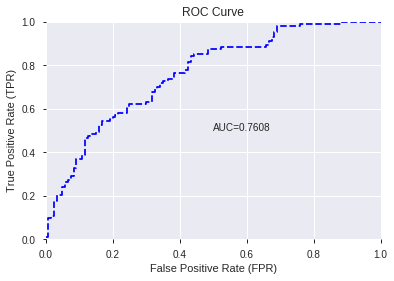

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


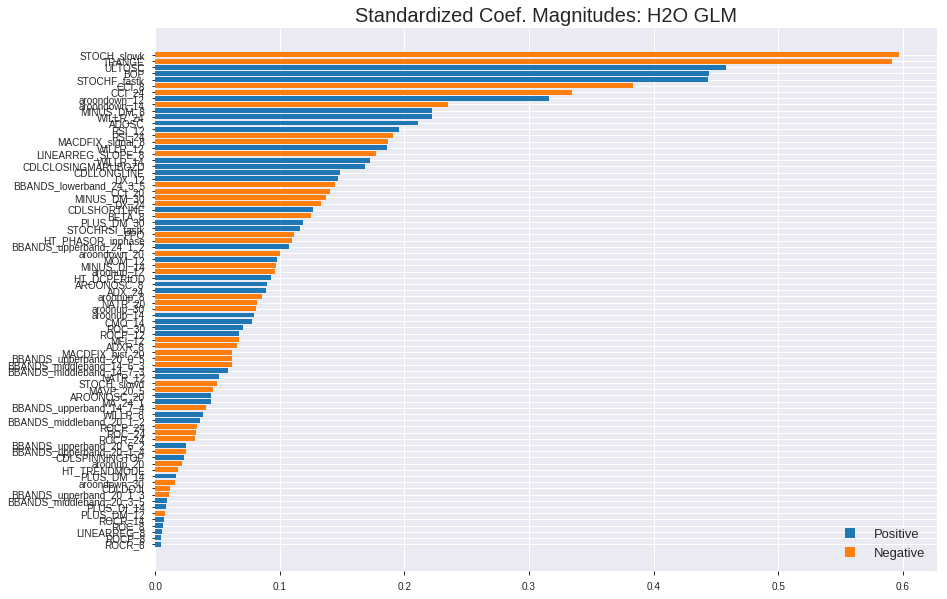

'log_likelihood'
--2019-08-26 18:30:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_183040_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_183040_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['STOCH_slowk',
 'TRANGE',
 'ULTOSC',
 'BOP',
 'STOCHF_fastk',
 'CCI_8',
 'CCI_24',
 'aroondown_12',
 'aroondown_14',
 'MINUS_DM_8',
 'WILLR_24',
 'ADOSC',
 'RSI_12',
 'RSI_24',
 'MACDFIX_signal_8',
 'WILLR_12',
 'LINEARREG_SLOPE_8',
 'WILLR_14',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'DX_12',
 'BBANDS_lowerband_24_3_5',
 'CCI_20',
 'MINUS_DM_30',
 'DX_24',
 'CDLSHORTLINE',
 'BETA_8',
 'PLUS_DM_30',
 'STOCHRSI_fastk',
 'PPO',
 'HT_PHASOR_inphase',
 'BBANDS_upperband_24_1_2',
 'aroondown_20',
 'MOM_12',
 'MINUS_DI_14',
 'aroonup_12',
 'HT_DCPERIOD',
 'AROONOSC_8',
 'ADX_24',
 'aroonup_8',
 'NATR_20',
 'aroonup_30',
 'aroonup_14',
 'CMO_14',
 'ROC_30',
 'ROCP_12',
 'MFI_12',
 'ADXR_8',
 'MACDFIX_hist_20',
 'BBANDS_upperband_20_0_5',
 'BBANDS_middleband_14_6_3',
 'BBANDS_middleband_14_7_3',
 'NATR_12',
 'STOCH_slowd',
 'MAVP_20_5',
 'AROONOSC_20',
 'MA_24_1',
 'BBANDS_upperband_14_7_4',
 'WILLR_8',
 'BBANDS_middleband_20_1_2',
 'ROCP_24',
 'ROC_24',
 'ROCR_24',
 'BBANDS_upperband_20_6_2'

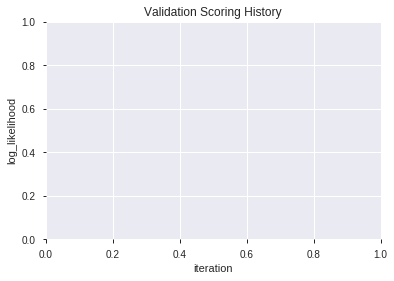

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_183050_model_3  0.799434  0.556916              0.286691  0.433566  0.187980
1               XGBoost_2_AutoML_20190826_183050  0.785922  0.554127              0.284547  0.432406  0.186975
2               XGBoost_3_AutoML_20190826_183050  0.783900  0.562841              0.292880  0.436754  0.190754
3  XGBoost_grid_1_AutoML_20190826_183050_model_6  0.773867  0.570751              0.278317  0.439039  0.192756
4  XGBoost_grid_1_AutoML_20190826_183050_model_2  0.773706  0.574587              0.280380  0.441648  0.195053
5  XGBoost_grid_1_AutoML_20190826_183050_model_4  0.770631  0.572028              0.362460  0.441239  0.194692
6  XGBoost_grid_1_AutoML_20190826_183050_model_1  0.767476  0.569248              0.320024  0.441270  0.194719
7  XGBoost_grid_1_AutoML_20190826_183050_model_5  0.761003  0.597812              0.335316  0.454654  0.206710
8               XGBoost_1_AutoML_20190826_183050  0.758900  0.581152              0.313754  0.445307  0.198298
9  XGBoost_grid_1_AutoML_20190826_183050_model_7  0.749272  0.592895              0.334587  0.450204  0.202684

variable  relative_importance  scaled_importance  percentage
0                        BOP          1355.086060           1.000000    0.172480
1                     TRANGE           797.862915           0.588791    0.101554
2             STOCHRSI_fastk           324.515106           0.239479    0.041305
3                     ULTOSC           258.540741           0.190793    0.032908
4               STOCHF_fastk           227.365326           0.167787    0.028940
..                       ...                  ...                ...         ...
73              HT_TRENDMODE            16.668938           0.012301    0.002122
74            CDLSPINNINGTOP            13.677168           0.010093    0.001741
75  BBANDS_middleband_20_3_5            12.242890           0.009035    0.001558
76                   ROCR_24             6.425161           0.004742    0.000818
77                   MA_24_1             6.287188           0.004640    0.000800

[78 rows x 4 columns]

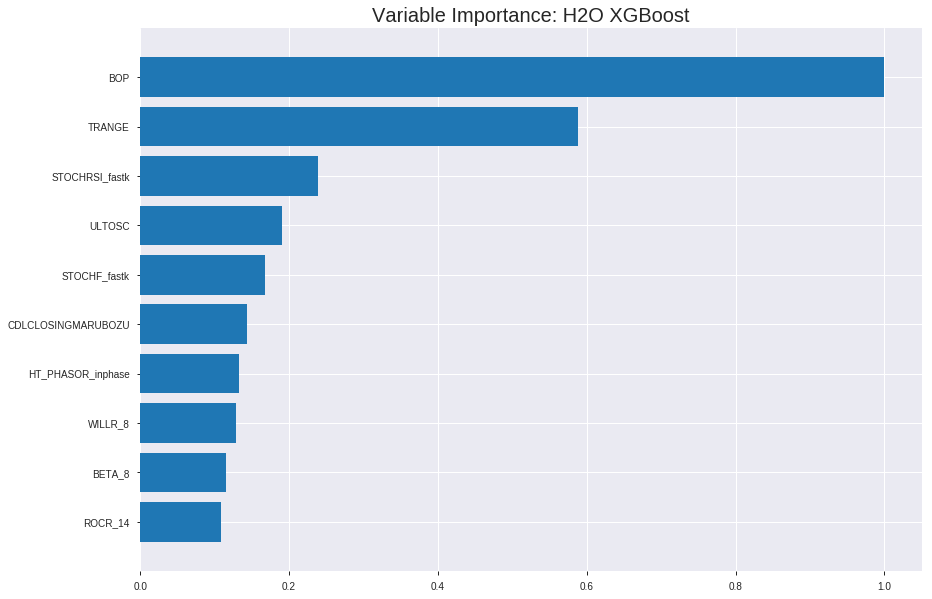

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_183050_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1270413578925091
RMSE: 0.3564286154232136
LogLoss: 0.4172265338984296
Mean Per-Class Error: 0.1537271776364384
AUC: 0.9317208752022182
pr_auc: 0.9317889117738629
Gini: 0.8634417504044365
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4589362069964409: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      639  150  0.1901   (150.0/789.0)
1      90   677  0.1173   (90.0/767.0)
Total  729  827  0.1542   (240.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458936     0.849435  215
max f2                       0.318672     0.904486  279
max f0point5                 0.610146     0.871694  152
max accuracy                 0.458936     0.845758  215
max precision                0.950737     1         0
max recall                   0.170008     1         354
max specificity              0.950737     1         0
max absolute_mcc             0.458936     0.693854  215
max min_per_class_accuracy   0.489584     0.841572  202
max mean_per_class_accuracy  0.458936     0.846273  215

Gains/Lift Table: Avg response rate: 49.29 %, avg score: 49.35 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.917188           2.02868    2.02868            1                0.931713  1                           0.931713            0.0208605       0.0208605                  102.868   102.868
    2        0.0205656                   0.902994           2.02868    2.02868            1                0.910809  1                           0.921261            0.0208605       0.041721                   102.868   102.868
    3        0.0302057                   0.895279           2.02868    2.02868            1                0.899653  1                           0.914365            0.0195567       0.0612777                  102.868   102.868
    4        0.0404884                   0.877246           2.02868    2.02868            1                0.88472   1                           0.906836            0.0208605       0.0821382                  102.868   102.868
    5        0.0501285                   0.868906           2.02868    2.02868            1                0.872721  1                           0.900275            0.0195567       0.101695                   102.868   102.868
    6        0.100257                    0.828787           2.00267    2.01568            0.987179         0.847678  0.99359                     0.873977            0.100391        0.202086                   100.267   101.568
    7        0.150386                    0.784203           2.00267    2.01134            0.987179         0.806552  0.991453                    0.851502            0.100391        0.302477                   100.267   101.134
    8        0.200514                    0.750399           1.97667    2.00267            0.974359         0.768635  0.987179                    0.830785            0.0990874       0.401565                   97.6666   100.267
    9        0.300129                    0.667426           1.83236    1.94615            0.903226         0.710742  0.959315                    0.790942            0.182529        0.584094                   83.2359   94.6146
    10       0.400386                    0.574906           1.50851    1.83656            0.74359          0.624112  0.905297                    0.749168            0.151239        0.735332                   50.8508   83.6561
    11       0.5                         0.486448           1.1125     1.69231            0.548387         0.530068  0.83419                     0.705517            0.110821        0.846154                   11.2504   69.2308
    12       0.600257                    0.387998           0.819276   1.54649            0.403846         0.436999  0.762313                    0.660668            0.0821382       0.928292                   -18.0724  54.6491
    13       0.699871                    0.310141           0.510443   1.39903            0.251613         0.350539  0.689624                    0.616527            0.0508475       0.97914                    -48.9557  39.9028
    14       0.800129                    0.24657            0.143048   1.24165            0.0705128        0.277687  0.612048                    0.57407             0.0143416       0.993481                   -85.6952  24.1652
    15       0.899743                    0.173361           0.0523531  1.10998            0.0258065        0.213817  0.547143                    0.534184            0.00521512      0.998696                   -94.7647  10.998
    16       1                           0.0548794          0.0130044  1                  0.00641026       0.128688  0.492931                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18665822477305738
RMSE: 0.43203961018991927
LogLoss: 0.5546476186225486
Mean Per-Class Error: 0.25970207360052455
AUC: 0.802895254487337
pr_auc: 0.7533564083680749
Gini: 0.605790508974674
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46020516753196716: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      159  90   0.3614   (90.0/249.0)
1      34   162  0.1735   (34.0/196.0)
Total  193  252  0.2787   (124.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460205     0.723214  224
max f2                       0.241072     0.821277  349
max f0point5                 0.631384     0.71875   134
max accuracy                 0.539493     0.741573  182
max precision                0.916878     1         0
max recall                   0.184698     1         375
max specificity              0.916878     1         0
max absolute_mcc             0.539493     0.478658  182
max min_per_class_accuracy   0.513627     0.73494   188
max mean_per_class_accuracy  0.539493     0.740298  182

Gains/Lift Table: Avg response rate: 44.04 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.899025           2.27041   2.27041            1                0.90887   1                           0.90887             0.0255102       0.0255102                  127.041   127.041
    2        0.0202247                   0.876271           1.70281   2.01814            0.75             0.887565  0.888889                    0.899401            0.0153061       0.0408163                  70.2806   101.814
    3        0.0314607                   0.871382           2.27041   2.10824            1                0.873378  0.928571                    0.890107            0.0255102       0.0663265                  127.041   110.824
    4        0.0404494                   0.866844           1.70281   2.01814            0.75             0.870127  0.888889                    0.885667            0.0153061       0.0816327                  70.2806   101.814
    5        0.0516854                   0.85116            1.81633   1.97427            0.8              0.857346  0.869565                    0.87951             0.0204082       0.102041                   81.6327   97.4268
    6        0.101124                    0.814732           2.06401   2.01814            0.909091         0.830587  0.888889                    0.855592            0.102041        0.204082                   106.401   101.814
    7        0.150562                    0.770843           1.96081   1.99931            0.863636         0.795754  0.880597                    0.835944            0.0969388       0.30102                    96.0807   99.9315
    8        0.2                         0.743078           1.3416    1.83673            0.590909         0.758428  0.808989                    0.816783            0.0663265       0.367347                   34.1605   83.6735
    9        0.301124                    0.656916           1.51361   1.72822            0.666667         0.700906  0.761194                    0.777869            0.153061        0.520408                   51.3605   72.8221
    10       0.4                         0.590187           1.29      1.6199             0.568182         0.622458  0.713483                    0.739453            0.127551        0.647959                   29.0005   61.9898
    11       0.501124                    0.496596           1.00907   1.49664            0.444444         0.542703  0.659193                    0.69975             0.102041        0.75                       0.907029  49.6637
    12       0.6                         0.432369           0.980404  1.41156            0.431818         0.464191  0.621723                    0.660931            0.0969388       0.846939                   -1.95965  41.1565
    13       0.698876                    0.373701           0.567602  1.29216            0.25             0.402969  0.569132                    0.624435            0.0561224       0.903061                   -43.2398  29.2162
    14       0.8                         0.295048           0.454082  1.18622            0.2              0.336505  0.522472                    0.588039            0.0459184       0.94898                    -54.5918  18.6224
    15       0.898876                    0.220562           0.412801  1.10115            0.181818         0.267645  0.485                       0.552796            0.0408163       0.989796                   -58.7199  10.1148
    16       1                           0.0935952          0.100907  1                  0.0444444        0.172873  0.440449                    0.514376         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:30:56  1.771 sec   0                  0.5              0.693147            0.5             0                  1                0.507069                         0.5                0.693147              0.5               0                    1                  0.559551
    2019-08-26 18:30:56  1.848 sec   5                  0.47309          0.640461            0.833672        0.826961           2.02868          0.260925                         0.479253           0.652299              0.782272          0.728612             1.81633            0.276404
    2019-08-26 18:30:56  1.900 sec   10                 0.4543           0.604487            0.853506        0.855923           2.02868          0.252571                         0.465854           0.62621               0.786083          0.742237             2.27041            0.283146
    2019-08-26 18:30:56  1.955 sec   15                 0.436863         0.571157            0.865834        0.867121           2.02868          0.244216                         0.454218           0.603387              0.797803          0.754257             1.81633            0.269663
    2019-08-26 18:30:56  2.014 sec   20                 0.423863         0.54627             0.87573         0.875412           2.02868          0.234576                         0.443583           0.582231              0.807014          0.768902             2.27041            0.267416
    2019-08-26 18:30:56  2.073 sec   25                 0.411519         0.522513            0.885249        0.887492           2.02868          0.215296                         0.439599           0.573698              0.804104          0.758427             2.27041            0.298876
    2019-08-26 18:30:56  2.133 sec   30                 0.400677         0.501699            0.894067        0.895614           2.02868          0.205013                         0.435116           0.564089              0.806758          0.77028              2.27041            0.265169
    2019-08-26 18:30:56  2.192 sec   35                 0.39421          0.488759            0.897941        0.898671           2.02868          0.189589                         0.43164            0.556644              0.808735          0.768826             2.27041            0.258427
    2019-08-26 18:30:56  2.255 sec   40                 0.386472         0.473493            0.903289        0.904548           2.02868          0.190874                         0.431802           0.556314              0.806635          0.761517             2.27041            0.265169
    2019-08-26 18:30:56  2.321 sec   45                 0.378659         0.458636            0.910784        0.911924           2.02868          0.177378                         0.430395           0.552961              0.805026          0.758175             2.27041            0.262921
    2019-08-26 18:30:56  2.387 sec   50                 0.373055         0.447864            0.916065        0.916216           2.02868          0.181877                         0.431211           0.554065              0.804985          0.756279             2.27041            0.265169
    2019-08-26 18:30:57  2.466 sec   55                 0.365678         0.434348            0.923594        0.923587           2.02868          0.163239                         0.430175           0.551489              0.806235          0

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
BOP                       1355.0860595703125     1.0                   0.17247950387009786
TRANGE                    797.8629150390625      0.5887913239193522    0.10155443543262796
STOCHRSI_fastk            324.5151062011719      0.23947933336726462   0.04130527660632757
ULTOSC                    258.5407409667969      0.19079285713320537   0.03290785734029373
STOCHF_fastk              227.36532592773438     0.1677866319426459    0.028939755033502282
---                       ---                    ---                   ---
HT_TRENDMODE              16.66893768310547      0.012301017758526024  0.002121673440087832
CDLSPINNINGTOP            13.677167892456055     0.010093209797164455  0.0017408718182717363
BBANDS_middleband_20_3_5  12.242890357971191     0.009034769615926327  0.0015583125809356074
ROCR_24                   6.425161361694336      0.004741515357136583  0.0008178142163913679
MA_24_1                   6.287187576293945      0.004639696152056619  0.0008002524904147278


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7399103139013453)

('F1', 0.7226890756302521)

('auc', 0.7994336569579288)

('logloss', 0.5569155246167335)

('mean_per_class_error', 0.26711165048543695)

('rmse', 0.4335664654079303)

('mse', 0.18797987992632603)

xgboost prediction progress: |████████████████████████████████████████████| 100%


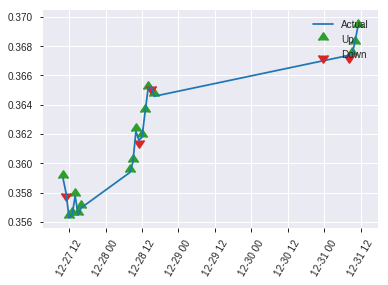


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18797987992632603
RMSE: 0.4335664654079303
LogLoss: 0.5569155246167335
Mean Per-Class Error: 0.26711165048543695
AUC: 0.7994336569579288
pr_auc: 0.7636264985746176
Gini: 0.5988673139158576
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4509821832180023: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   49   0.4083   (49.0/120.0)
1      17   86   0.165    (17.0/103.0)
Total  88   135  0.296    (66.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450982     0.722689  134
max f2                       0.285653     0.837521  184
max f0point5                 0.61104      0.739857  78
max accuracy                 0.61104      0.73991   78
max precision                0.920426     1         0
max recall                   0.212255     1         203
max specificity              0.920426     1         0
max absolute_mcc             0.61104      0.479769  78
max min_per_class_accuracy   0.527354     0.725     107
max mean_per_class_accuracy  0.589716     0.732888  86

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 52.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.912437           2.16505   2.16505            1                0.915996  1                           0.915996            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.902495           2.16505   2.16505            1                0.907252  1                           0.912498            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.882033           2.16505   2.16505            1                0.894091  1                           0.907239            0.0194175       0.0679612                  116.505   116.505
    4        0.0403587                   0.87255            1.08252   1.92449            0.5              0.876656  0.888889                    0.900443            0.00970874      0.0776699                  8.25243   92.4488
    5        0.0538117                   0.861238           2.16505   1.98463            1                0.867281  0.916667                    0.892152            0.0291262       0.106796                   116.505   98.4628
    6        0.103139                    0.832546           1.57458   1.78852            0.727273         0.846908  0.826087                    0.870513            0.0776699       0.184466                   57.4581   78.8518
    7        0.152466                    0.793651           1.96823   1.84666            0.909091         0.809613  0.852941                    0.85081             0.0970874       0.281553                   96.8226   84.6659
    8        0.201794                    0.753479           1.96823   1.87638            0.909091         0.773843  0.866667                    0.831996            0.0970874       0.378641                   96.8226   87.6375
    9        0.300448                    0.664005           1.37776   1.71265            0.636364         0.70834   0.791045                    0.791393            0.135922        0.514563                   37.7758   71.265
    10       0.399103                    0.584047           1.27935   1.60554            0.590909         0.620171  0.741573                    0.749068            0.126214        0.640777                   27.9347   60.5542
    11       0.502242                    0.514841           0.941325  1.46914            0.434783         0.547756  0.678571                    0.707728            0.0970874       0.737864                   -5.86745  46.914
    12       0.600897                    0.451746           0.885702  1.37335            0.409091         0.480611  0.634328                    0.67044             0.0873786       0.825243                   -11.4298  37.3352
    13       0.699552                    0.383994           0.688879  1.27682            0.318182         0.426592  0.589744                    0.636051            0.0679612       0.893204                   -31.1121  27.6824
    14       0.798206                    0.312724           0.590468  1.19199            0.272727         0.348312  0.550562                    0.600488            0.0582524       0.951456                   -40.9532  19.1993
    15       0.896861                    0.232066           0.196823  1.08252            0.0909091        0.276665  0.5                         0.564867            0.0194175       0.970874                   -80.3177  8.25243
    16       1                           0.123239           0.282398  1                  0.130435         0.181059  0.461883                    0.525282           

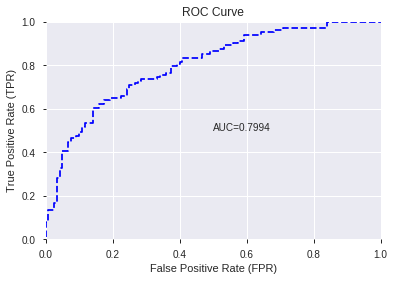

This function is available for GLM models only


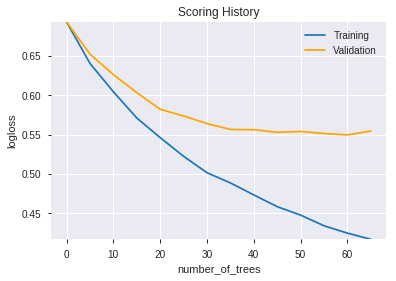

--2019-08-26 18:31:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_183050_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_183050_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8cec',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHRSI_fastk',
 'ULTOSC',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'HT_PHASOR_inphase',
 'WILLR_8',
 'BETA_8',
 'ROCR_14',
 'STOCH_slowk',
 'MFI_12',
 'NATR_12',
 'CCI_20',
 'ADOSC',
 'WILLR_14',
 'PLUS_DM_30',
 'CCI_8',
 'STOCH_slowd',
 'ADX_24',
 'CDLLONGLINE',
 'LINEARREG_SLOPE_8',
 'aroonup_30',
 'HT_DCPERIOD',
 'MOM_12',
 'ROC_8',
 'aroonup_8',
 'ADXR_8',
 'BBANDS_lowerband_24_3_5',
 'MACDFIX_signal_8',
 'CCI_24',
 'PLUS_DI_14',
 'PPO',
 'DX_24',
 'BBANDS_upperband_14_7_4',
 'PLUS_DM_12',
 'ROCP_12',
 'MINUS_DM_30',
 'WILLR_24',
 'BBANDS_upperband_20_1_4',
 'MINUS_DI_14',
 'NATR_20',
 'MINUS_DM_8',
 'aroonup_12',
 'CMO_14',
 'AROONOSC_8',
 'RSI_24',
 'CDLSHORTLINE',
 'MACDFIX_hist_20',
 'AROONOSC_20',
 'DX_12',
 'BBANDS_middleband_14_7_3',
 'ROCP_8',
 'BBANDS_middleband_14_6_3',
 'ROC_30',
 'RSI_12',
 'BBANDS_upperband_20_0_5',
 'aroonup_20',
 'LINEARREG_8',
 'BBANDS_upperband_20_1_3',
 'aroondown_14',
 'PLUS_DM_14',
 'aroondown_12',
 'aroondown_20',
 'ROCP_

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.717
GLM             0.717
XGBoost         0.749
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.713    0.749
DLF          0.704  0.695    0.713
Fwe          0.704  0.717    0.731
RFE          0.717  0.700    0.740
XGBF         0.704  0.695    0.713





F1


DeepLearning    0.751
GLM             0.721
XGBoost         0.723
dtype: float64

DeepLearning    GLM  XGBoost
All          0.705  0.708    0.715
DLF          0.712  0.683    0.707
Fwe          0.712  0.711    0.721
RFE          0.751  0.721    0.723
XGBF         0.731  0.683    0.707





auc


DeepLearning    0.775
GLM             0.763
XGBoost         0.799
dtype: float64

DeepLearning    GLM  XGBoost
All          0.754  0.753    0.787
DLF          0.752  0.727    0.773
Fwe          0.761  0.763    0.793
RFE          0.775  0.761    0.799
XGBF         0.750  0.727    0.773





logloss


DeepLearning    0.716
GLM             0.604
XGBoost         0.575
dtype: float64

DeepLearning    GLM  XGBoost
All          0.655  0.590    0.575
DLF          0.602  0.604    0.574
Fwe          0.657  0.578    0.549
RFE          0.716  0.586    0.557
XGBF         0.679  0.604    0.574





mean_per_class_error


DeepLearning    0.316
GLM             0.320
XGBoost         0.288
dtype: float64

DeepLearning    GLM  XGBoost
All          0.316  0.298    0.257
DLF          0.299  0.320    0.288
Fwe          0.305  0.293    0.269
RFE          0.268  0.294    0.267
XGBF         0.285  0.320    0.288





rmse


DeepLearning    0.475
GLM             0.458
XGBoost         0.442
dtype: float64

DeepLearning    GLM  XGBoost
All          0.469  0.450    0.442
DLF          0.456  0.458    0.442
Fwe          0.459  0.444    0.431
RFE          0.475  0.449    0.434
XGBF         0.464  0.458    0.442





mse


DeepLearning    0.226
GLM             0.210
XGBoost         0.196
dtype: float64

DeepLearning    GLM  XGBoost
All          0.220  0.202    0.195
DLF          0.208  0.210    0.196
Fwe          0.211  0.197    0.186
RFE          0.226  0.201    0.188
XGBF         0.216  0.210    0.196

{'F1':       DeepLearning    GLM  XGBoost
 All          0.705    NaN      NaN
 DLF          0.712    NaN      NaN
 DLF            NaN  0.683      NaN
 DLF            NaN    NaN    0.707
 All            NaN  0.708      NaN
 All            NaN    NaN    0.715
 XGBF         0.731    NaN      NaN
 XGBF           NaN  0.683      NaN
 XGBF           NaN    NaN    0.707
 Fwe          0.712    NaN      NaN
 Fwe            NaN  0.711      NaN
 Fwe            NaN    NaN    0.721
 RFE          0.751    NaN      NaN
 RFE            NaN  0.721      NaN
 RFE            NaN    NaN    0.723,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.691    NaN      NaN
 DLF          0.704    NaN      NaN
 DLF            NaN  0.695      NaN
 DLF            NaN    NaN    0.713
 All            NaN  0.713      NaN
 All            NaN    NaN    0.749
 XGBF         0.704    NaN      NaN
 XGBF           NaN  0.695      NaN
 XGBF           NaN    NaN    0.713
 Fwe          0.704    NaN      NaN
 Fwe     